# Morphen: Image Sersic-Fitting decomposition
Author: Geferson Lucatelli <br>
email: geferson.lucatelli@postgrad.manchester.ac.uk <br>
email2: gefersonlucatelli@gmail.com<br>
Code Version: 0.3 <br>
Codename: Pelicoto <br>

This notebooks contains sets of tools to:
   1. perform image fitting to astronomical images (currently testing on radio and optical image) using scipy and LMTIT in a fashinable way; 
   2. analyse results from the image decomposition, plotting results, etc
   3. Perform mcmc experiments (currently not fully developed) on optimised results.
  
This notebook is integrated with casa, so it operates on numpy-arrays, CASA tasks and astropy+scipy capabilities.

Warning: This package is not fully automated. It requires user interaction for optimal results. <br> 
I am working to make this fully automated in the near future. <br> 
The reason of why I am going slowly is that radio emission is sometimes complex, <br> 
and cannot be easily modelled by a combination of functions.

The code is flexible as possible so you can experiments with multiple ways to perform the fit. 

1. [Introduction](#imports) <br>
2. [Data Selection](#data_selection) <br>
    2.1 [Preparing Images](#preparing_images) <br>
    2.2 [Masking](#masking) <br>
3. [Source Extraction](#source_extraction) <br>

<a id='imports'></a>

```
 _           ___                            _
/ |         |_ _|_ __ ___  _ __   ___  _ __| |_ ___
| |  _____   | || '_ ` _ \| '_ \ / _ \| '__| __/ __|
| | |_____|  | || | | | | | |_) | (_) | |  | |_\__ \
|_|         |___|_| |_| |_| .__/ \___/|_|   \__|___/
                          |_|

````
Lets start by import some libraries and define paths.

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import casatasks
from casatasks import *
import casatools
# from casatools import *
from scipy.ndimage import rotate
# import analysisUtils as au
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits as pf
from casatools import image as IA
import lmfit
import string
from matplotlib.gridspec import GridSpec
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
import glob
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import os
from astropy.stats import mad_std
from scipy.ndimage import gaussian_filter
from astropy import visualization
from astropy.visualization import simple_norm
from astropy.convolution import Gaussian2DKernel
import scipy.special as sp
from matplotlib import rcParams,rc

try:
    import casaviewer.imview as imview
except:
    pass


In [64]:

# reset_rc_params()
import sys
sys.path.append('../analysis_scripts/')
sys.path.append('/opt/casa-6.4.1-12-pipeline-2022.2.0.64/')
sys.path.append('../../phd_lucatelli_work/analysis/')
from libs import *
from libs import Gradindex
from libs import polarim


# os.environ['CASAPATH'] = "/opt/casa-6.4.1-12-pipeline-2022.2.0.64/"
import analysisUtils as au
from analysisUtils import *

import warnings
from astropy.utils.exceptions import AstropyDeprecationWarning

# warnings.filterwarnings('ignore', category=AstropyDeprecationWarning)

    


def reset_rc_params():
    import matplotlib as mpl
    from matplotlib import rcParams,rc
    mpl.rcParams.update({'font.size': 14, 
        'xtick.labelsize':16,
        'ytick.labelsize':16,
        'axes.labelsize' : 16,
        'xtick.major.width':1,
        'ytick.major.width':1,
        'axes.linewidth':1,
        'legend.fontsize':14,            
        })
    pass
reset_rc_params()


def reset_rc_params():
    mpl.rcParams.update({'font.size': 14, 
        'mathtext.fontset': 'stix',
        "text.usetex": False,
        "font.family": "sans-serif",
        "font.family": "sans",
        "font.serif": ["Exo 2"],
        "font.sans-serif": ["Exo 2"],
        'font.family': 'STIXGeneral', 
        'xtick.labelsize':16,
        'ytick.labelsize':16,
        'axes.labelsize' : 16,
        'xtick.major.width':1,
        'ytick.major.width':1,
        'axes.linewidth':1,
        'lines.linewidth':2,
        'legend.fontsize':14,
        "grid.linestyle":'--',                
        })
    pass
reset_rc_params()
def reload_libs():
    '''
    Reload libs
    '''
    import libs
    import fitEllipse2018
#     from libs import *
    import importlib
    importlib.reload(libs)
    importlib.reload(fitEllipse2018)
    
# import warnings
# warnings.filterwarnings('ignore', category=DeprecationWarning)




Configure the environment to limit GPU memory usage. 

In [65]:
# %env XLA_PYTHON_CLIENT_MEM_FRACTION=0.25 #use only half of the total GPU video memory.
# %env TF_CPP_MIN_LOG_LEVEL=0 #print XLA/JAX/CUDA related info. 

In [66]:
#root path to where the imaging data is stored. 
root_path  = '/home/sagauga/pCloudDrive/PhD/'

In [67]:
def run_image_fitting(imagelist,residuallist,sources_photometries,n_components,mask,comp_ids,
                      save_name_append='_ls_n0G0G0G',z=None,aspect=None,
                      convolution_mode='GPU',workers=6,
                      method1 = 'least_squares',method2 = 'least_squares',
                      loss="cauchy",tr_solver="exact",
                      init_params = 0.25,final_params = 4.0,
                      fix_n = [True,True,True,True,True,True,False],
                      fix_value_n=[0.5,0.5,0.5, 1.0],fix_geometry=True,
                      dr_fix=[10,10,10,10,10,10,10,10]):
    results_fit = []
    lmfit_results = []
    lmfit_results_1st_pass = []
    errors_fit = []
    models = []
    list_results_compact_conv_morpho = []
    list_results_compact_deconv_morpho = []
    list_results_ext_conv_morpho = []
    list_results_ext_deconv_morpho = []
    
    all_comps_ids = np.arange(1,n_components_new+1).astype('str')    
    mask_compact_ids = np.isin(all_comps_ids,np.asarray(comp_ids))
    ext_ids = list(all_comps_ids[~mask_compact_ids])
    
    for i in range(len(imagelist)):
#         model_dict_results = {}
        # try:
        crop_image = imagelist[i]
        crop_residual = residuallist[i]
        print('Fitting', os.path.basename(crop_image))
#             dict_results['#imagename'] = crop_image
        data_2D = ctn(crop_image)
        res_2D = ctn(crop_residual)
        rms_std_data = mad_std(data_2D)
        rms_std_res = mad_std(res_2D)
        print('rms res = ', rms_std_res/rms_std_data)
        print('rms data = ', rms_std_data*1e6,
                '; rms res = ',rms_std_res*1e6, 
                '; ratio = ', rms_std_res/rms_std_data)

        sigma_level = 3
        vmin = 3
        # i = 0 #to be used in indices[0], e.g. first component
        # omaj, omin, _, _, _ = beam_shape(crop_image)
        # dilation_size = int(
        # np.sqrt(omaj * omin) / (2 * get_cell_size(crop_image)))
        _, mask_region = mask_dilation(crop_image,
                                                rms=rms_std_res,
                                                sigma=6.0, dilation_size=None,
                                                iterations=2,PLOT=True)
        # psf_size = dilation_size*6
        # psf_size = (2 * psf_size) // 2 +1
        psf_size = int(ctn(crop_image).shape[0])
        print('PSF SIZE is',psf_size )
        #creates a psf from the beam shape. 
        psf_name = tcreate_beam_psf(crop_image,size=(psf_size,psf_size),
                                        aspect=aspect,
                                    # aspect=None,
                                    )#,app_name='_'+str(psf_size)+'x'+str(psf_size)+'')

        result_mini, mini,result_1,result_extra,model_dict, \
        image_results_conv,image_results_deconv, \
                            smodel2D, model_temp = do_fit2D(imagename=crop_image,residualname=crop_residual,
                                                            init_constraints=sources_photometries,psf_name=psf_name,
                                                            params_values_init = None,#imfit_conf_values[0:-1],
        #                                                    fix_n = False,fix_x0_y0=[False,False,False],
                                                            ncomponents=n_components,constrained=True,
                                                            fix_n=fix_n,
#                                                                 mask_region=mask_region,
                                                            fix_value_n = fix_value_n,
                                                            fix_x0_y0=[True,True,True,True,True,True,True,True],
                                                            dr_fix = dr_fix,
                                                            # n_to_fix = [0.5,None,1.0,None]
                                                            convolution_mode=convolution_mode,fix_geometry=fix_geometry,
                                                            workers=workers,
                                                            #do not fix the n of the extra component
                                                            method1 = method1, method2 = method2,
                                                            loss=loss,tr_solver=tr_solver,
                                                            init_params = init_params,final_params = final_params,
                                                            save_name_append=save_name_append)
        print(result_mini.params)
        models.append(model_dict)
        lmfit_results.append(result_mini.params)
        lmfit_results_1st_pass.append(result_1.params)
        special_name = '_'+str(n_components_new)+'C'+save_name_append
        compact_model = 0
        extended_model = 0
        compact_model_deconv = 0
        extended_model_deconv = 0
        for lc in comp_ids:
            compact_model = compact_model + model_dict['model_c'+lc+'_conv']
            compact_model_deconv = compact_model_deconv + model_dict['model_c'+lc]
        if ext_ids is not None:
            for le in ext_ids:
                extended_model = extended_model + model_dict['model_c'+le+'_conv']
                extended_model_deconv = extended_model_deconv + model_dict['model_c'+le]
                nfunctions = None
        else:
            extended_model = 0
            extended_model_deconv = 0
            nfunctions = 1
            

        decomp_results = plot_decomp_results(imagename=crop_image,
                            compact=compact_model,
                            extended_model=extended_model,
                            rms = rms_std_res,nfunctions=nfunctions,
                            special_name=special_name)
        plot_fit_results(crop_image,model_dict,image_results_conv,sources_photometries,
                            crop=False,box_size=200,
                            vmax_factor=0.3,vmin_factor=1.0)
        # plt.xlim(0,3)
        plot_slices(ctn(crop_image),ctn(crop_residual),model_dict,image_results_conv[-2],sources_photometries)
        parameter_results = result_mini.params.valuesdict().copy()
        parameter_results['#imagename'] = os.path.basename(crop_image)
        parameter_results['residualname'] = os.path.basename(crop_residual)

        results_compact_conv_morpho,_ = shape_measures(imagename=crop_image, residualname=crop_residual, z=z, mask_component=None, sigma_mask=1,
                        last_level=1.0, vmin_factor=1.0, plot_catalog=False,data_2D=compact_model*mask*mask_region,
                        npixels=128, fwhm=81, kernel_size=21, dilation_size=None,
                        main_feature_index=0, results_final={}, iterations=2,
                        fracX=0.10, fracY=0.10, deblend=False, bkg_sub=False,
                        bkg_to_sub=None, rms=rms_std_res,
                        apply_mask=False, do_PLOT=True, SAVE=True, show_figure=True,
                        mask=mask,do_measurements='partial',
                        add_save_name='_compact_conv')
        list_results_compact_conv_morpho.append(results_compact_conv_morpho)

        results_compact_deconv_morpho,_ = shape_measures(imagename=crop_image, residualname=crop_residual, z=z, mask_component=None, sigma_mask=1,
                        last_level=3.0, vmin_factor=1.0, plot_catalog=False,data_2D=compact_model_deconv*mask*mask_region,
                        npixels=128, fwhm=81, kernel_size=21, dilation_size=None,
                        main_feature_index=0, results_final={}, iterations=2,
                        fracX=0.10, fracY=0.10, deblend=False, bkg_sub=False,
                        bkg_to_sub=None, rms=rms_std_res,
                        apply_mask=False, do_PLOT=True, SAVE=True, show_figure=True,
                        mask=mask,do_measurements='partial',
                        add_save_name='_compact_deconv')
        list_results_compact_deconv_morpho.append(results_compact_deconv_morpho)
        
        if nfunctions == 1:
            results_ext_conv_morpho,_ = shape_measures(imagename=crop_image, residualname=crop_residual, z=z, mask_component=None, sigma_mask=3,
                            last_level=3.0, vmin_factor=3.0, plot_catalog=False,data_2D=(ctn(crop_image)-compact_model)*mask_region,
                            npixels=128, fwhm=81, kernel_size=21, dilation_size=None,
                            main_feature_index=0, results_final={}, iterations=2,
                            fracX=0.10, fracY=0.10, deblend=False, bkg_sub=False,
                            bkg_to_sub=None, rms=rms_std_res,
                            apply_mask=False, do_PLOT=True, SAVE=True, show_figure=True,
                            mask=mask,do_measurements='partial',
                            add_save_name='_extended_conv')
            list_results_ext_conv_morpho.append(results_ext_conv_morpho)
            results_ext_deconv_morpho = results_ext_conv_morpho
            list_results_ext_deconv_morpho.append(results_ext_deconv_morpho)
        else:
            results_ext_conv_morpho,_ = shape_measures(imagename=crop_image, residualname=crop_residual, z=z, mask_component=None, sigma_mask=1,
                            last_level=1.0, vmin_factor=1.0, plot_catalog=False,data_2D=extended_model*mask*mask_region,
                            npixels=128, fwhm=81, kernel_size=21, dilation_size=None,
                            main_feature_index=0, results_final={}, iterations=2,
                            fracX=0.10, fracY=0.10, deblend=False, bkg_sub=False,
                            bkg_to_sub=None, rms=rms_std_res/2,
                            apply_mask=False, do_PLOT=True, SAVE=True, show_figure=True,
                            mask=mask,do_measurements='partial',
                            add_save_name='_extended_conv')
            list_results_ext_conv_morpho.append(results_ext_conv_morpho)
            
            results_ext_deconv_morpho,_ = shape_measures(imagename=crop_image, residualname=crop_residual, z=z, mask_component=None, sigma_mask=1,
                            last_level=3.0, vmin_factor=1.0, plot_catalog=False,data_2D=extended_model_deconv*mask*mask_region,
                            npixels=128, fwhm=81, kernel_size=21, dilation_size=None,
                            main_feature_index=0, results_final={}, iterations=2,
                            fracX=0.10, fracY=0.10, deblend=False, bkg_sub=False,
                            bkg_to_sub=None, rms=rms_std_res/2,
                            apply_mask=False, do_PLOT=True, SAVE=True, show_figure=True,
                            mask=mask,do_measurements='partial',
                            add_save_name='_extended_deconv')
            list_results_ext_deconv_morpho.append(results_ext_deconv_morpho)



        all_results = {**parameter_results,**decomp_results}
        results_fit.append(all_results)
            
        # except:
        #     print('Error on fitting', os.path.basename(crop_image))
        #     errors_fit.append(crop_image)
    return(pd.DataFrame(results_fit),
           lmfit_results,lmfit_results_1st_pass,errors_fit,models,
           pd.DataFrame(list_results_compact_conv_morpho),
           pd.DataFrame(list_results_compact_deconv_morpho),
           pd.DataFrame(list_results_ext_conv_morpho),
           pd.DataFrame(list_results_ext_deconv_morpho))



def compute_model_stats_GPU(params, imagename, residualname, psf_name,
                            ncomponents, num_simulations=2000,
                            sigma=6, iterations=2,compact_ids=[0],extended_ids=[-1], 
                            save_results=False, special_name=''):
    """
    Function to run a Monte Carlo simulation from the best optmized fit parameters.
    This can is used to  compute a proper error for the total flux on the model.
    Be aweare that this function is computing expensive as it requires to
    run a 2D convolution on each iteration. This function is optmized to run
    on a CUDA GPU.
    """

    BA = beam_area2(imagename)
    data_2D_cpu = ctn(imagename)
    data_2D = jnp.asarray(data_2D_cpu)
    residual_2D_cpu = ctn(residualname)
    residual_2D = jnp.asarray(residual_2D_cpu)
    residual_2D_shuffled = shuffle_2D(residual_2D_cpu)
    background = jnp.asarray(residual_2D_shuffled)
    model_temp = Model(sersic2D_GPU)
    PSF_BEAM_raw = ctn(psf_name)

    PSF_BEAM = jnp.asarray(PSF_BEAM_raw)
    omaj, omin, _, _, _ = beam_shape(imagename)
    dilation_size = int(np.sqrt(omaj * omin) / (2 * get_cell_size(imagename)))
    _, mask_cpu = mask_dilation(imagename, sigma=sigma, iterations=iterations,
                                dilation_size=dilation_size, PLOT=True)
    mask = jnp.asarray(mask_cpu)
    values = params.valuesdict()
    stderr = jnp.asarray(
        [params[name].stderr for name in values.keys()])
    #     dfstderr = pd.DataFrame({'value': list(values.values()), 'stderr': stderr},
    #                       index=values.keys())
    params_values = jnp.asarray(list(values.values()))
    #     random_params = generate_random_params(params_values,stderr)

    size = ctn(imagename).shape
    FlatSky_level = mad_std(data_2D_cpu)
    xy = jnp.meshgrid(jnp.arange((size[0])), jnp.arange((size[1])))
    model_dict = {}
    image_results_conv = []
    image_results_deconv = []

    #     num_simulations = 50

    # Generate a set of random parameters for each simulation and compute the total flux
    #     total_fluxes = []
    #     random_params_list = []
    print('Running MCMC on best-fit parameters (using cuda gpu).')

    def mcmc_sim(random_params):
        #         params_values, stderr = params_result
        #     for l in tqdm(range(num_simulations)):
        #         random_params_list.append(random_params)
        model = 0
        #         model_comps = []
        sub_com_res_results = jnp.zeros(ncomponents)
        sub_com_flux_results = jnp.zeros(ncomponents)
        for i in range(1, ncomponents + 1):
            # 8 means that we have 8 parameters per model-component.
            # e.g. In, Rn, n, q, c, PA, x0 and y0,
            mcmc_params = random_params[int(8 * (i - 1)):int(8 * (i))]
            model_temp = sersic2D(xy,
                                  mcmc_params[0],
                                  # params['f' + str(i) + '_x0'],
                                  mcmc_params[1],
                                  # params['f' + str(i) + '_y0'],
                                  mcmc_params[2],
                                  # params['f' + str(i) + '_PA'],
                                  mcmc_params[3],
                                  # params['f' + str(i) + '_ell'],
                                  mcmc_params[4],  # params['f' + str(i) + '_n'],
                                  mcmc_params[5],
                                  # params['f' + str(i) + '_In'],
                                  mcmc_params[6],
                                  # params['f' + str(i) + '_Rn'],
                                  mcmc_params[7]) + background / ncomponents + \
                         FlatSky(FlatSky_level, random_params[-1]) / ncomponents
            # print(model_temp[0])
            model_temp_dec = model_temp
            model_temp_conv = jax.scipy.signal.fftconvolve(model_temp_dec,
                                                             PSF_BEAM, 'same')
#             cp.cuda.Stream.null.synchronize()
            #             model_comps.append(model_temp_conv)
            model = model + model_temp_conv
            total_flux_comp_i = jnp.sum(model_temp_conv * mask) / BA
            
        
#             sub_com_flux_results[i - 1] = total_flux_comp_i
            sub_com_flux_results = sub_com_flux_results.at[i-1].set(total_flux_comp_i)

            total_res_flux_sub_comp_i = jnp.sum((data_2D - model) * mask) / BA
#             sub_com_res_results[i - 1] = total_res_flux_sub_comp_i
            sub_com_res_results = sub_com_res_results.at[i-1].set(total_res_flux_sub_comp_i)

        model_total_conv = model
        total_flux_random_model = jnp.sum(model_total_conv * mask) / BA
        residual_model = jnp.sum(((data_2D - model_total_conv) * mask) ** 2.0)
        residual_nrss_model = calc_nrss(data_2D * mask, model_total_conv * mask)

        if np.isnan(total_flux_random_model) == True:
            # Discard nans fluxes (mcmc parameters are distant from priors). 
            good_model = False
        else:
            good_model = True

        #         total_fluxes.append(total_flux_random_model)
        return (
            total_flux_random_model, good_model, residual_model,
            residual_nrss_model,
            sub_com_flux_results, sub_com_res_results)

    random_params_list = []
    for i in range(num_simulations):
        random_params = generate_random_params_normal(params_values, stderr)
        random_params_list.append(random_params)
    random_params_list = np.asarray(random_params_list)



    results = []
    for i in tqdm(range(len(random_params_list))):
        results.append(mcmc_sim(random_params_list[i]))

    total_fluxes_all_gpu = []
    residuals_gpu = []
    residuals_nrss_gpu = []
    flags_gpu = []
    sub_comp_fluxes_gpu = []
    sub_comp_residuals_gpu = []
    for dict_temp in results:
        total_fluxes_all_gpu.append(dict_temp[0])
        flags_gpu.append(dict_temp[1])
        residuals_gpu.append(dict_temp[2])
        residuals_nrss_gpu.append(dict_temp[3])
        sub_comp_fluxes_gpu.append(dict_temp[4])
        sub_comp_residuals_gpu.append(dict_temp[5])

    total_fluxes_all = jnp.asarray(total_fluxes_all_gpu)
    flags = jnp.asarray(flags_gpu)
    residuals = jnp.asarray(residuals_gpu)
    residuals_nrss = jnp.asarray(residuals_nrss_gpu)
    sub_comp_fluxes = jnp.asarray(sub_comp_fluxes_gpu)[flags]
    sub_comp_residuals = jnp.asarray(sub_comp_residuals_gpu)[flags]

    total_fluxes = total_fluxes_all[flags]
    random_params_list = random_params_list[flags]
    residuals = residuals[flags]
    residuals_nrss = residuals_nrss[flags]
    add_flags = jnp.where(abs(total_fluxes) > 100 * mad_std(abs(total_fluxes)))[0]
    total_fluxes = jnp.delete(total_fluxes, add_flags, axis=0)
    random_params_list = jnp.delete(random_params_list, add_flags, axis=0)
    residuals = jnp.delete(residuals, add_flags, axis=0)
    residuals_nrss = jnp.delete(residuals_nrss, add_flags, axis=0)
    sub_comp_fluxes = jnp.delete(sub_comp_fluxes, add_flags, axis=0)
    sub_comp_residuals = jnp.delete(sub_comp_residuals, add_flags, axis=0)

    mean_flux = jnp.mean(total_fluxes)
    std_flux = jnp.std(total_fluxes)
    total_fluxes_compact = jnp.sum(sub_comp_fluxes[:,compact_ids],axis=1)
    total_fluxes_extended = jnp.sum(sub_comp_fluxes[:,extended_ids],axis=1)
    print("Estimated total flux = %.4f +/- %.4f" % (mean_flux, std_flux))
    labels_names = list(params.valuesdict().keys())
    #     labels = ["Parameter {}".format(i+1) for i in range(len(params))] + ["Total Flux"]
    labels = ["" + i for i in labels_names] + ["Total Flux"] + ["Total Flux Compact"] + ["Total Flux Extended"]

    data_results = jnp.column_stack([random_params_list, total_fluxes*1000,total_fluxes_compact*1000,total_fluxes_extended*1000])
    #     fig = corner.corner(data_results, labels=labels, quantiles=[0.16, 0.5, 0.84],
    #                         show_titles=True, title_kwargs={"fontsize": 12}, label_kwargs={"fontsize": 12})
    #     fig.suptitle("Monte Carlo Simulation Results", fontsize=16, y=1.0)

    #     model_dict['best_residual'] = data_2D - model_dict['model_total']
    #     model_dict['best_residual_conv'] = data_2D - model_dict['model_total_conv']
    return (
        total_fluxes, random_params_list, data_results, residuals,
        residuals_nrss,
        sub_comp_fluxes, sub_comp_residuals, labels)


def run_mcmc_mini(imagename,psf_name,mini_results,residualname=None,rms_map=None,
                  n_components=None,nwalkers_multiplier=20,backend_name="filename.h5",
                  burn_in_phase=1000, production_steps = 6000):
    """
    GPU Optimized function to run a MCMC of a multi-dimensional sersic model.
    It uses JAX. 
    This function is not feasible to be run on a CPU. 
    
    Please, only use if you have a GPU, if not, it can take days....
    
    """
    import emcee
    import corner 
    
    if residualname is not None:
        residual_2D = pf.getdata(residualname)
        residual_2D_shuffled = shuffle_2D(residual_2D)
        background = jnp.array(residual_2D_shuffled)
    else:
        background = jnp.array(rms_map)
        

    omaj, omin, _, _, _ = beam_shape(imagename)
    dilation_size = int(
    np.sqrt(omaj * omin) / (2 * get_cell_size(imagename)))
    
    rms_std_res = mad_std(rms_map)
    _, mask_region = mask_dilation(imagename,
                                            rms=rms_std_res,
                                            sigma=6.0, dilation_size=dilation_size,
                                            iterations=5,PLOT=True)
    
    
    data_2D = ctn(imagename) * mask_region
    data_2D_gpu = jnp.array(data_2D)
    PSF_BEAM = jnp.array(ctn(psf_name))
    size = data_2D.shape
    xy = jnp.meshgrid(jnp.arange((size[1])), jnp.arange((size[0])))
    FlatSky_level_GPU = jnp.array(mad_std(data_2D))
    
    # Read input parameters and std
    params = mini_results.copy()
#     opt_params = jnp.asarray(list(params.valuesdict().values()))
    opt_params = jnp.array(list(params.valuesdict().values()))
    stderr = jnp.array([params[name].stderr for name in params.valuesdict().keys()])
    
    if n_components is None:
        n_components = int((stderr.shape[0] - 1) / 8)
    
    nfunctions = n_components
#     @jit
#     def convolve_on_gpu(image, psf):
#         image_fft = fft2(image)
#         psf_fft = fft2(psf)
#         conv_fft = image_fft * psf_fft
#         return fftshift(jnp.real(ifft2(conv_fft)))
    @jit
    def jitted_convolve(image, psf):
        return jax.scipy.signal.fftconvolve(image, psf, mode='same')

    @jit
    def convolve_on_gpu(image, psf):
        # Calculate the new padded shape
        padded_shape = (image.shape[0] + psf.shape[0] - 1,
                        image.shape[1] + psf.shape[1] - 1)

        # Pad both image and psf to the new shape
        # image_padded = pad_for_convolution(image, padded_shape)
        pad_shape = [(0, ts - s) for s, ts in zip(image.shape, padded_shape)]
        image_padded = jnp.pad(image, pad_shape, mode='constant')
        pad_shape = [(0, ts - s) for s, ts in zip(psf.shape, padded_shape)]
        psf_padded = jnp.pad(psf, pad_shape, mode='constant')
        # psf_padded = pad_for_convolution(psf, padded_shape)
        image_fft = jnp.fft.fft2(image_padded)
        psf_fft = jnp.fft.fft2(psf_padded)

        conv_fft = image_fft * psf_fft

        # Get the real part of the inverse FFT and crop to the original image size
        result_full = jnp.real(jnp.fft.ifft2(conv_fft))
        return result_full[psf.shape[0] // 2:image.shape[0] + psf.shape[0] // 2,
               psf.shape[1] // 2:image.shape[1] + psf.shape[1] // 2]

    jax_convolve = jit(convolve_on_gpu)
    
    @jit
    def log_likelihood(random_params):
        for i in range(1, nfunctions + 1):
            mcmc_params = random_params[int(8 * (i - 1)):int(8 * (i))]
            model = sersic2D_GPU(xy,
                                  mcmc_params[0],
                                  # params['f' + str(i) + '_x0'],
                                  mcmc_params[1],
                                  # params['f' + str(i) + '_y0'],
                                  mcmc_params[2],
                                  # params['f' + str(i) + '_PA'],
                                  mcmc_params[3],
                                  # params['f' + str(i) + '_ell'],
                                  mcmc_params[4],  # params['f' + str(i) + '_n'],
                                  mcmc_params[5],
                                  # params['f' + str(i) + '_In'],
                                  mcmc_params[6],
                                  # params['f' + str(i) + '_Rn'],
                                  mcmc_params[7]) + background / nfunctions + \
                         FlatSky(FlatSky_level_GPU, random_params[-1]) / nfunctions
        
        
        MODEL_2D_conv = convolve_on_gpu(model, PSF_BEAM)
#         print(model)
        residual = data_2D_gpu - MODEL_2D_conv
        chi2 = jnp.sum(residual ** 2) / jnp.sum(data_2D_gpu)
        
#         inv_sigma2 = 1.0/(1+MODEL_2D_conv**2*jnp.exp(2))
#     #     return -0.5*(chi2*inv_sigma2 - np.log(inv_sigma2)))
        dof = len(model) - len(params)
        log_like = -0.5 * (chi2 + dof * jnp.log(2 * jnp.pi))
        total_flux_model = jnp.sum(MODEL_2D_conv)
        total_flux_res = jnp.sum(residual)
#         log_like = chi2
#         log_like = -0.5*(jnp.sum(residual ** 2*inv_sigma2 - jnp.log(inv_sigma2)))
        return log_like,(total_flux_model,total_flux_res)
        
    jax_log_likelihood = jit(log_likelihood)

    def ln_prob(p, params):
        # Calculate log-prior probability
        log_prior_prob = log_prior(p, params)
        if jnp.isinf(log_prior_prob):
            return log_prior_prob

        # Update parameter values based on proposed step
        for i, (param_name, param) in enumerate(params.items()):
            param.value = p[i]

        params_model = jnp.array(list(params.valuesdict().values()))
        log_likelihood_prob = log_likelihood(params_model)[0]
        return log_prior_prob + log_likelihood_prob

    # @jit
    def log_prior(p, params):
        out_of_bounds = []
        for i, (param_name, param) in enumerate(params.items()):
            pvalue = param.value
            if (p[i] < pvalue*0.8 or p[i] > pvalue*1.25) and '_n' in param_name:
                out_of_bounds.append(param_name)
            if (p[i] < pvalue*0.8 or p[i] > pvalue*1.25) and '_In' in param_name:
                out_of_bounds.append(param_name)
            if (p[i] < pvalue*0.8 or p[i] > pvalue*1.25) and '_Rn' in param_name:
                out_of_bounds.append(param_name)
            if (p[i] < 0.0 or p[i] > pvalue+0.2) and '_ell' in param_name:
                out_of_bounds.append(param_name)
            if (p[i] < pvalue-20 or p[i] > pvalue+20) and '_PA' in param_name:
                out_of_bounds.append(param_name)
            if (p[i] < pvalue-10 or p[i] > pvalue+10) and '_x0' in param_name:
                out_of_bounds.append(param_name)
            if (p[i] < pvalue-10 or p[i] > pvalue+10) and '_y0' in param_name:
                out_of_bounds.append(param_name)
            if (p[i] < pvalue-0.1 or p[i] > pvalue+0.1) and '_cg' in param_name:
                out_of_bounds.append(param_name)
            if (p[i] < 0.0 or p[i] > pvalue+1) and 's_a' in param_name:
                out_of_bounds.append(param_name)
        if len(out_of_bounds) == 0:
            return 0.0  # Return zero for in-bounds parameters
        else:
            return -jnp.inf  # Return negative infinity for out-of-bounds parameters


    # Define the log-posterior function for the MCMC
    # @jit
    def log_posterior(params):
        lp = log_prior(params)
        if not jnp.isfinite(lp):
            return -jnp.inf  # Return negative infinity for out-of-bounds parameters
        return lp + log_likelihood(params)[0]
    
    # prepare the mcmc
    nwalkers = nwalkers_multiplier*len(params) 
    ndim = len(params)
    print('    ### Initi of MCMC ###')
    print('--------------------------------')
    print('    >> Number of Sersics:',n_components)
    print('    >> Number of parameters:',ndim)
    print('    >> Number of walkers:   ',nwalkers)
    print('--------------------------------')
    print('    >> Burn-in:   ',burn_in_phase)
    print('    >> Main-Phase Steps:   ',production_steps)
    p0 = []
    for i in range(nwalkers):
        walker_params = []
        random_params = jnp.array(generate_random_params_normal(jnp.asarray(list(params.valuesdict().values())),stderr))
        p0.append(random_params)
    
#     print(p0)
    backend = emcee.backends.HDFBackend(backend_name)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_prob, args=(params,),threads=6,backend=backend)
    sampler.run_mcmc(p0, production_steps,progress=True)
#     samples = sampler.chain[:, burn_in_phase:, :].reshape((-1, ndim))
#     backend.store(chain=sampler.get_chain(), log_prob=sampler.get_log_prob(), blobs=sampler.get_blobs())
    samples = sampler.get_chain(discard=burn_in_phase, flat=True)
#     RESIDUAL = []
#     TOTAL_FLUX = []
#     for result in sampler.sample(p0,ndim):
#     # Unpack the result tuple and save the residual and total flux to the backend
#         residual, total_flux = result
#         RESIDUAL.append(residual)
#         TOTAL_FLUX.append(total_flux)
        
#     sampler.backend.write_to_hdf5(backend_name)
#     backend.close()

    
    print('--------------------------------')
    print('    Parameter Errors            ')
    # Compute the median and 1-sigma error bars for each parameter
    params_median = jnp.median(samples, axis=0)
    params_err_minus = jnp.percentile(samples, 16, axis=0) - params_median
    params_err_plus = jnp.percentile(samples, 84, axis=0) - params_median
    params_err = 0.5 * (params_err_minus + params_err_plus)

    # Print the results
    for i, param_name in enumerate(params):
        print(f"{param_name} = {params_median[i]} +/- {params_err[i]}")
    
    idx_cut = [] # only select n, In and Rn parameters
    for i in range(0, n_components):
        idx_cut.append(int(i * 8 + 4))
        idx_cut.append(int(i * 8 + 5))
        idx_cut.append(int(i * 8 + 6))


    labels = [f"{param_name}" for param_name in params]
    # Plot the corner plot
#     fig = corner.corner(samples[:,idx_cut], 
#                         labels=np.asarray(labels)[idx_cut], 
#                         truths=list(params_median[idx_cut]))

#     plt.show()
    
#     # Plot the chains
#     fig, axes = plt.subplots(len(idx_cut), figsize=(10, 27), sharex=True)
#     labels = [f"{param_name}" for param_name in params]
#     for i in range(0,len(idx_cut)):
#     # for i in idx_cut:
#         ax = axes[i]
#         ax.plot(sampler.get_chain()[:, :, idx_cut[i]], color="k", alpha=0.1)
#         ax.set_xlim(0, len(sampler.get_chain()))
#         ax.set_ylabel(labels[idx_cut[i]])
#     axes[-1].set_xlabel("Step")
    
    return(samples,sampler,backend)

# def run_mcmc_mini(imagename,residualname,psf_name,mini_results,
#                   n_components=None,
#                   burn_in_phase=500, production_steps = 3000):

def generate_random_params_uniform(params, param_errors):
    # Generate a set of random numbers from a normal distribution with mean 0 and standard deviation 1
    # try:
    #     # Scale the random numbers by the standard errors of the parameters
    param_errors_corr = param_errors.copy()
    random_nums = np.random.uniform(-5, 5, size=len(params))
    scaled_random_nums = random_nums * param_errors
    random_params = params + scaled_random_nums
    return random_params

def generate_random_params_normal(params, param_errors):
    # Generate a set of random numbers from a normal distribution with mean 0 and standard deviation 1    
    param_errors_corr = param_errors.copy()
    
#     ndim_params = int((len(params)-1)/(len(params[0:8])))
#     weights = np.asarray([3,3,5,0.05,0.1,0.00001,5,0.01])
#     weights_m = np.tile(weights, (ndim_params, 1))
#     weights_f = weights_m.flatten()
#     weights_f = np.append(weights_f,np.asarray([0.1]))
# #     np.random.seed(123)

#     # Generate a random distribution of values between -1 and 1
#     random_noise = np.random.uniform(low=-1, high=1, size=len(weights_f))
# #     random_noise = np.random.random(len(weights_f)) * weights_f    
    
    random_nums = np.random.normal(0.0, 5.0, size=len(params))
    scaled_random_nums = random_nums * param_errors #+ random_noise
#     random_nums = np.random.normal(0.0, 0.1, size=len(params))
#     scaled_random_nums = random_nums * params
    random_params = params + scaled_random_nums
    return random_params

def generate_random_params_tukeylambda(params, param_errors):
    from scipy.stats import tukeylambda
    # Generate a set of random numbers from a normal distribution with mean 0 and standard deviation 1    
    param_errors_corr = param_errors.copy()
    random_nums =  tukeylambda.rvs(0.5, size=len(params)) *10
    scaled_random_nums = random_nums * param_errors
#     random_nums =  tukeylambda.rvs(0.5, size=len(params)) *0.1
#     scaled_random_nums = random_nums * params
    random_params = params + scaled_random_nums
    return random_params



def add_extra_component(petro_properties, copy_from_id):
    """
    Create another component from a dictionary (petro_properties) having
    photometric properties for N detected components in an image.

    Params
    ------
    petro_properties: dict
        Contain parameters of a number o N components obtained
        by a petrosian analysis of all detected sources.
        Example (these are actually the keys() from the dictionary):
        ['c1_PA', 'c1_q', 'c1_area', 'c1_Re',
        'c1_x0c', 'c1_y0c', 'c1_label', 'c1_R50',
        'c1_Snu', 'c1_Rp', 'c1_Rpidx', 'c1_rlast',
        'c1_I50']
    copy_from: int
        From which component copy parameters from.
        This is useful, for example, the source has two components detected,
        1 compact and the other a structure that can not be modelled by a single
        sersic function. Then, we need one function to model the compact structure,
        but 2 sersic functions to model the other structure.

        Assume that we have a blob surrounded by a disky emission ( detected
        as one source). Both are placed on the same region, on top of each other
        (e.g. from optical, we can call for example] a bulge and
        a disk). We need two functions to model this region.

        So, if component i=1 is the blob (or the bulge) we copy the parameters from it and
        create a second component. We just have to ajust some of the parameters.
        E.g. the effective radius of this new component, is in principle, larger than the original component.
        As well, the effective intensity will be smaller because we are adding a component
        further away from the centre. Other quantities, however, are uncertain, such as the Sersic index, position angle
        etc, but may be (or not!) close to those of component i.

    """

    from collections import OrderedDict
    dict_keys = list(petro_properties.keys())
    unique_list = list(OrderedDict.fromkeys(
        [elem.split('_')[1] for elem in dict_keys if '_' in elem]))
    #     print(unique_list)

    petro_properties_copy = petro_properties.copy()
    new_comp_id = petro_properties['ncomps'] + 1
    for k in range(len(unique_list)):
        #         print(unique_list[k])
        # do not change anything for other parameters.
        petro_properties_copy['c' + str(new_comp_id) + '_' + unique_list[k]] = \
        petro_properties_copy['c' + str(copy_from_id) + '_' + unique_list[k]]
        if unique_list[k] == 'R50':
            # multiply the R50 value by a factor, e.g., 4.0.
            factor = 4
            petro_properties_copy[
                'c' + str(new_comp_id) + '_' + unique_list[k]] = \
            petro_properties_copy[
                'c' + str(copy_from_id) + '_' + unique_list[k]] * factor
        if unique_list[k] == 'I50':
            # divide the I50 value by a factor, e.g., 10
            factor = 0.1
            petro_properties_copy[
                'c' + str(new_comp_id) + '_' + unique_list[k]] = \
            petro_properties_copy[
                'c' + str(copy_from_id) + '_' + unique_list[k]] * factor
    # update number of components
    petro_properties_copy['ncomps'] = petro_properties_copy['ncomps'] + 1
    return (petro_properties_copy)

<a id='data_selection'></a>

```
 ____            ____        _
|___ \          |  _ \  __ _| |_ __ _
  __) |  _____  | | | |/ _` | __/ _` |
 / __/  |_____| | |_| | (_| | || (_| |
|_____|         |____/ \__,_|\__\__,_|

 ____       _           _   _
/ ___|  ___| | ___  ___| |_(_) ___  _ __
\___ \ / _ \ |/ _ \/ __| __| |/ _ \| '_ \
 ___) |  __/ |  __/ (__| |_| | (_) | | | |
|____/ \___|_|\___|\___|\__|_|\___/|_| |_|
````

# Load List of Images (and their cleaning residuals)

## VV705 North

In [68]:
root_path_vla = '../data_examples/vla_only/VV705_C/' #only with JVLA images.
root_path_combined = '../data_examples/combined/VV705_C/' #only with JVLA images.
root_path_eM = '../data_examples/emerlin_only/VV705_C/' #only with e-MERLIN images.
prefix_images = 'MFS_images/north/*MFS-image.cutout_north.fits'
prefix_residuals = 'MFS_residuals/north/*MFS-residual.cutout_north.fits' # in many parts of the code, we require the residual images.

### JVLA Images

In [69]:
imagelist_vla = glob.glob(root_path_combined+prefix_images)
residuallist_vla = glob.glob(root_path_combined+prefix_residuals)
#this function is helpfull to sort the image list according to the restoring beam size (from smaller beams to larger beams). 
imagelist_vla,residuallist_vla=sort_list_by_beam_size(imagelist_vla,residuallist_vla)

100%|██████████| 7/7 [00:00<00:00, 86.88it/s]

0 >> clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..-1.0-MFS-image.cutout_north.fits
1 >> clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..-0.6-MFS-image.cutout_north.fits
2 >> clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..-0.4-MFS-image.cutout_north.fits
3 >> clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..-0.2-MFS-image.cutout_north.fits
4 >> clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..0.0-MFS-image.cutout_north.fits
5 >> clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..0.5-MFS-image.cutout_north.fits
6 >> clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..1.0-MFS-image.cutout_north.fits


In [70]:
residuallist_vla

array(['../data_examples/combined/VV705_C/MFS_residuals/north/clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..-1.0-MFS-residual.cutout_north.fits',
       '../data_examples/combined/VV705_C/MFS_residuals/north/clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..-0.6-MFS-residual.cutout_north.fits',
       '../data_examples/combined/VV705_C/MFS_residuals/north/clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..-0.4-MFS-residual.cutout_north.fits',
       '../data_examples/combined/VV705_C/MFS_residuals/north/clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..-0.2-MFS-residual.cutout_north.fits',
       '../data_examples/combined/VV705_C/MFS_residuals/north/clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..0.0-MFS-residual.cutout_north.fits',
       '../data_examples/combined/VV705_C/MFS_residuals/north/clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.bri

<a id='preparing_images'></a>

## Preparing Images
The data examples provided are cutouts of the original images. Because they are smaller, it turn things a bit faster. Just be aware that your cutouts must have a reasonable size to contain all the emission from the galaxy and a fraction of background noise. 

In [71]:
# Here I am just picking up one particular image from the list of images, 
# naming as `crop_image` and its associated residual `crop_residual`.
crop_image = imagelist_vla[-1]
crop_residual = residuallist_vla[-1]


In [72]:
# For this work, we require to have in hands the pixel scale in physical units.
# Be aware that this `pixsize_to_pc` is going to work only for radio images 
# since it reads the header information looking for the `cell_size`. If you are using any other 
# data, set `pixel_to_pc` to 1. 
try:
    pix_to_pc = pixsize_to_pc(z=z_d['VV705'], cell_size=get_cell_size(crop_image))
except:
    pix_to_pc = 1


D_a =  169.24419931373572 Mpc
Linear Distance =  6.564152262058192 pc


<WCSAxes: >

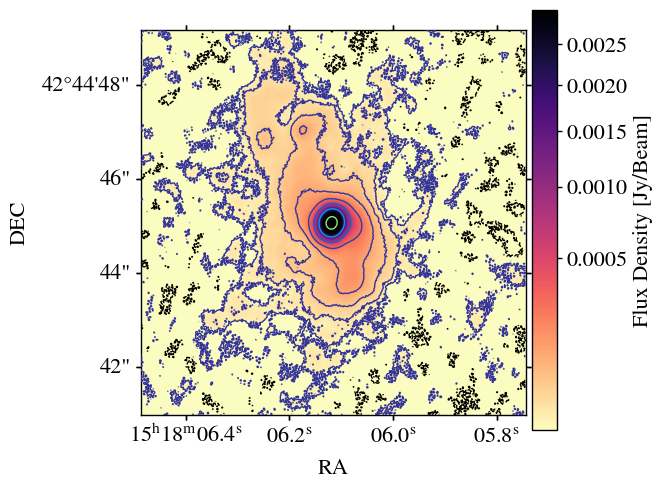

In [73]:
eimshow(crop_image,
        vmin_factor=1,neg_levels=np.asarray([-1]))

<a id='masking'></a>
## Masking
We may want also mask the data which we want to fit. For radio images, the function `mask_dilation` will apply a mask dilation above certain rms value. The size of the dilation is proportional to the restoring beam size. 

This mask will be used later when computing statistics on the image and on the model components fits. 

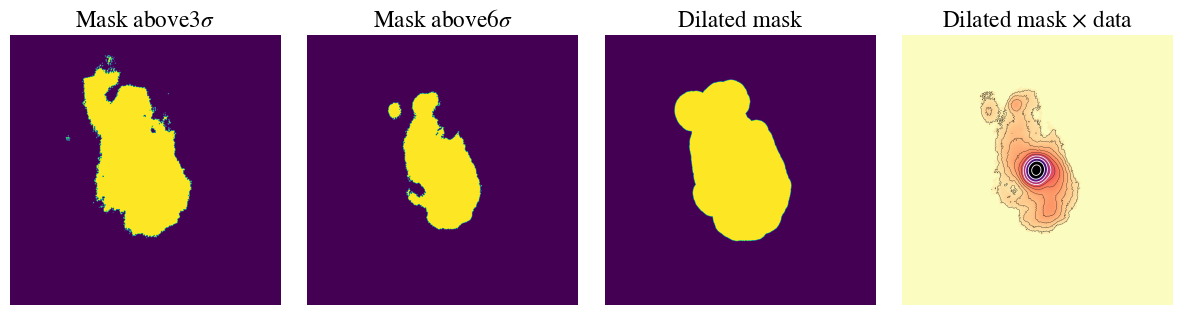

In [74]:
_, mask = mask_dilation(crop_image,sigma=6,
                        dilation_size=None,#If None, will compute the beam size from the image
                        iterations=2)

In [75]:
# The averaged beam size in pixels can be inspected with:
bspx,aO,bO=get_beam_size_px(crop_image)
print(bspx,'px')

45.877270635221294 px


<a id='source_extraction'></a>
# Source Extraction
After we have our data ready, we can run a source extraction to identify the relevant structures of emission. 
For that, we are going to use `SEP`. <br>

We impose that the min source size is limited by the beam area. 

In [76]:
beam_area2??

Signature: beam_area2(image, cellsize=None)
Source:   
def beam_area2(image, cellsize=None):
    '''
    Computes the estimated projected beam area (theroetical),
    given the semi-major and minor axis
    and the cell size used during cleaning.
    Return the beam area in pixels.
    '''
    if cellsize is None:
        try:
            cellsize = get_cell_size(image)
        except:
            print('Unable to read cell size from image header. '
                  'Please, provide the cell size of the image!')
            pass
    imhd = imhead(image)
    Omaj = imhd['restoringbeam']['major']['value']
    Omin = imhd['restoringbeam']['minor']['value']
    BArea = ((np.pi * Omaj * Omin) / (4 * np.log(2))) / (cellsize ** 2.0)
    return (BArea)
File:      /run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/phd_lucatelli_work/analysis/libs.py
Type:      function

In [77]:
# check what is the beam area in pixels square
minarea = beam_area2(crop_image)
print('Beam Area:', minarea, 'px^2')

Beam Area: 2384.8417475252613 px^2


2.196838295276393e-06
1.7609556834941031e-06
object 0: flux = 0.001416 +/- 0.037627
object 1: flux = 0.134040 +/- 0.366115
object 2: flux = 0.002147 +/- 0.046331


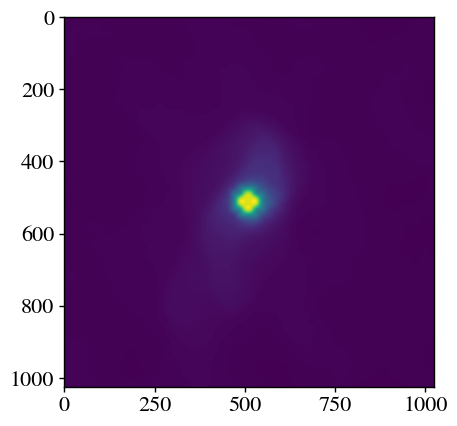

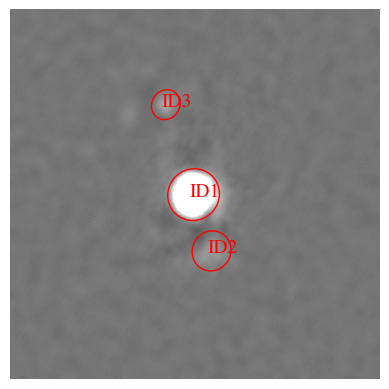

In [78]:
masks, indices, seg_maps = sep_source_ext(crop_image,
                                          bw=bspx/3,bh=bspx/3,fw=bspx/6,fh=bspx/6,#filtering options for source detection
                                          minarea=minarea,
                                          segmentation_map=True,filter_type='matched',mask=None,
                                          deblend_nthresh=50,deblend_cont = 0.00000000000000000001,
                                          clean_param=0.5,clean=True,
                                          sort_by='flux',#sort detected source by flux
                                          sigma=10,#min rms to search for sources
                                          ell_size_factor=3.0,#unstable, please inspect!
#                                           sigma=5,ell_size_factor=1.5,
                                          apply_mask=False # experimental, keep False for now
                                         )

We have now an array of the masked regions of every source/component detected. <br> 
By default, the maks are sorted according to the total flux enclosed. <br>
Note that these are temporary masks, and they will not be used to delimitate the amount of emission to be included in the fit. 

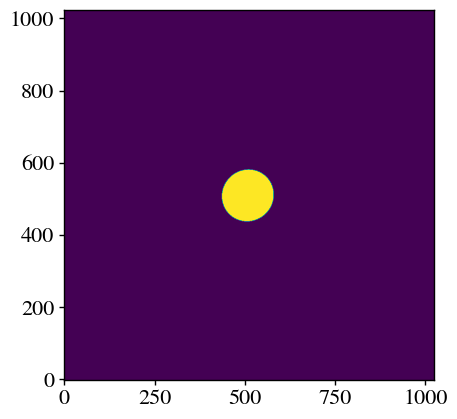

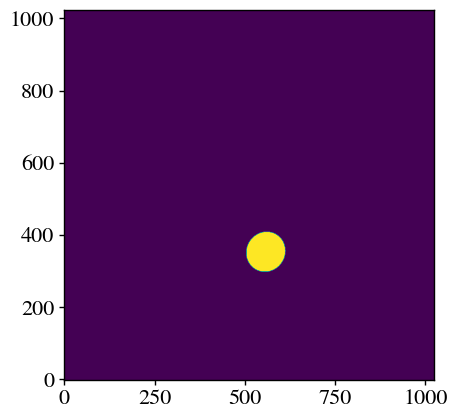

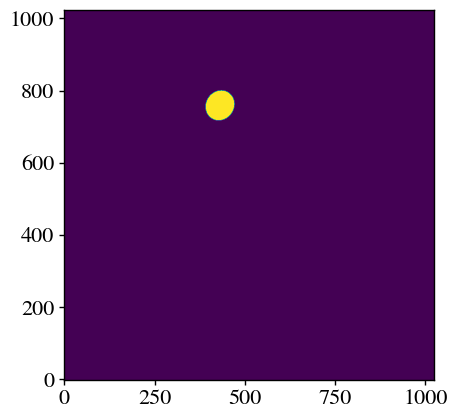

In [79]:
for mask_indice in indices:
    plt.figure()
    plt.imshow(masks[mask_indice],origin='lower')

 The previous step is supposed to provide us an overall idea of the source structure, number os components, etc. 

 We are going to use that knowledge do conduct the next step below.

# The `prepare_fit` function
We now want to estimate basic photometric properties for each one of these detected regions. <br>
For that, we can use a function called `prepare_fit`, which will actually do the mask dilation <br>
and compute the regional masks previouslly presented. This function is a helper, to include <br> 
all previous and additional steps required to do the fit. 

With this function we also are going to determine the nature of the emission, how many model components will be required to model the source. <br>

D_a =  169.24419931373572 Mpc
Linear Distance =  6.564152262058192 pc


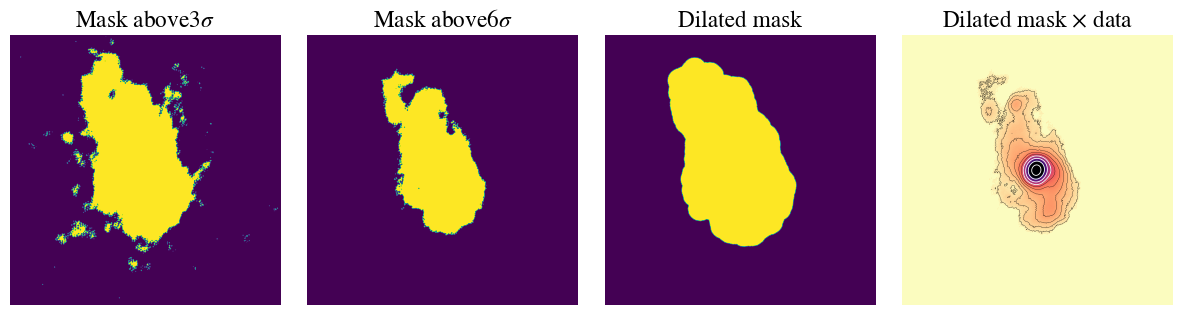

<Figure size 640x480 with 0 Axes>

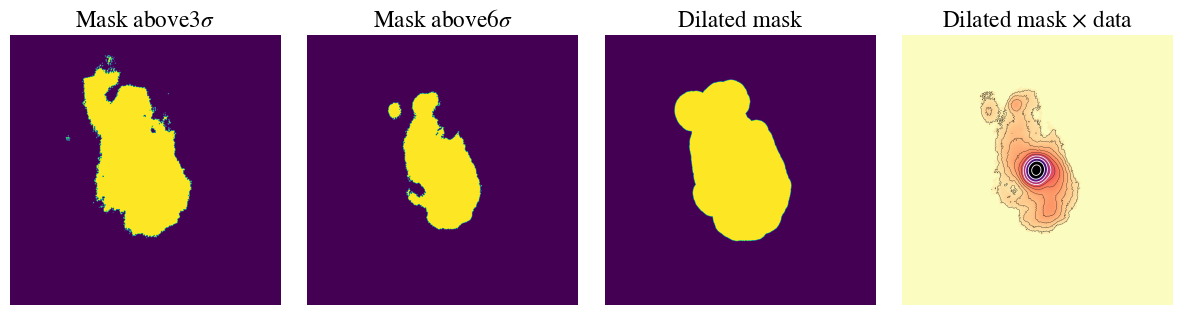

2.196838295276393e-06
1.7609556834941031e-06
object 0: flux = 0.001419 +/- 0.037670
object 1: flux = 0.134557 +/- 0.366821
object 2: flux = 0.002146 +/- 0.046329
1


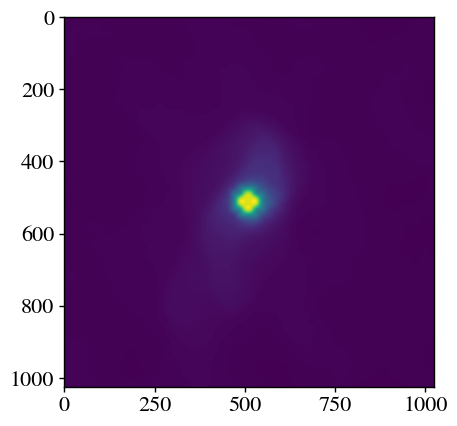

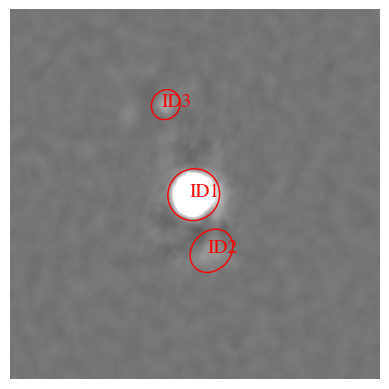

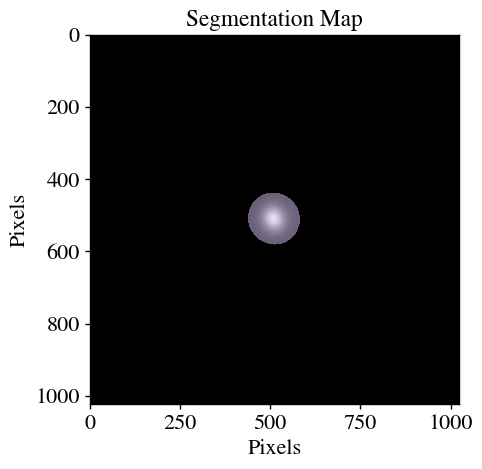

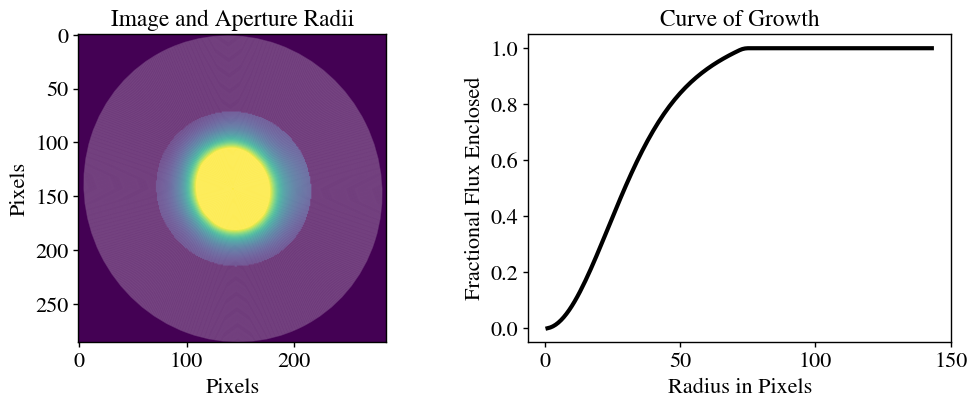

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:3590: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


1


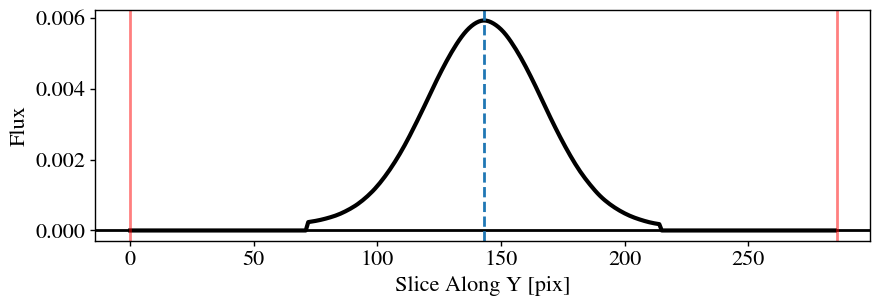

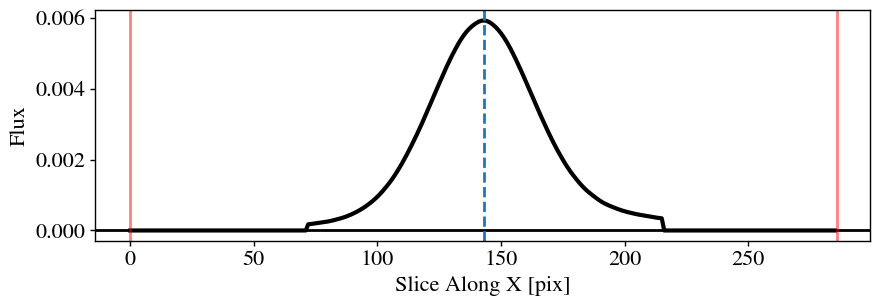

<Figure size 640x480 with 0 Axes>

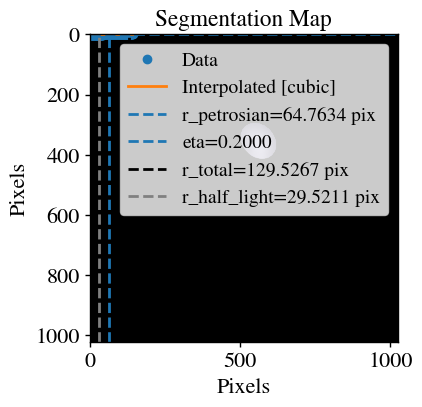

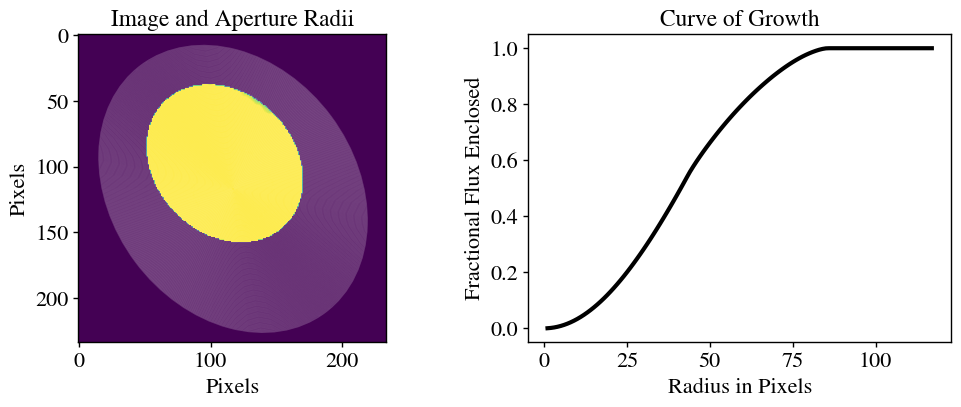

1


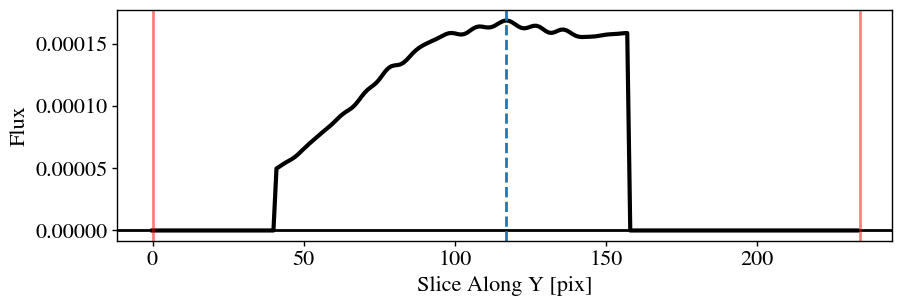

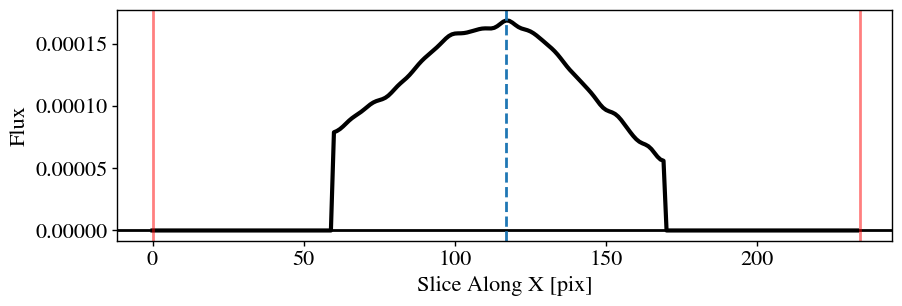

<Figure size 640x480 with 0 Axes>

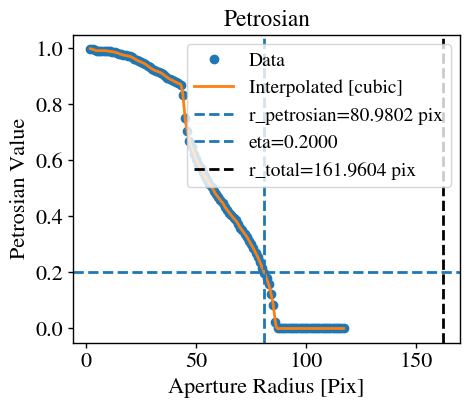

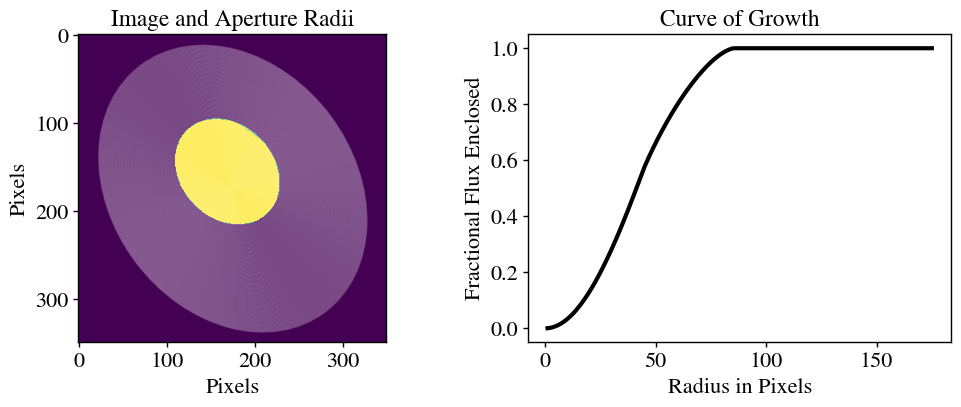

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:3590: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


1


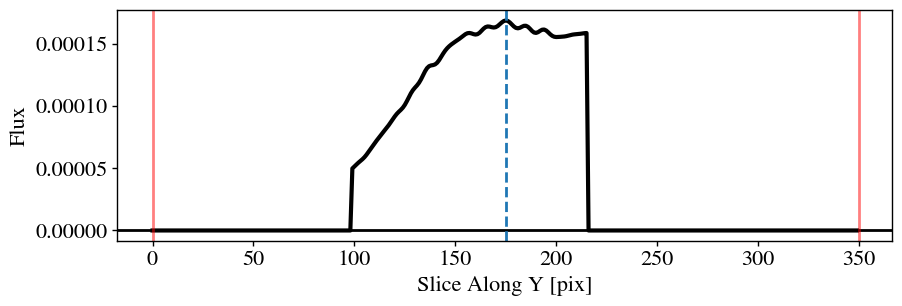

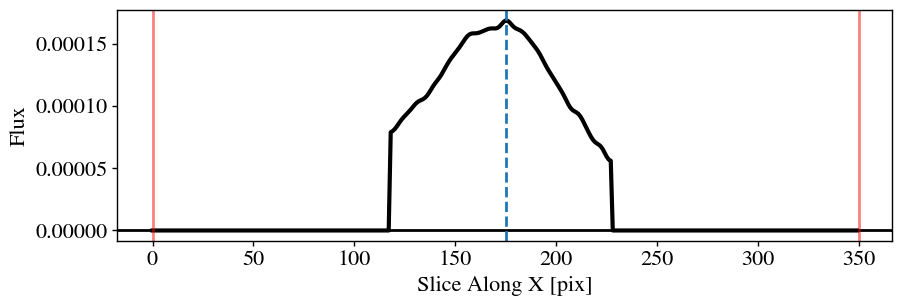

<Figure size 640x480 with 0 Axes>

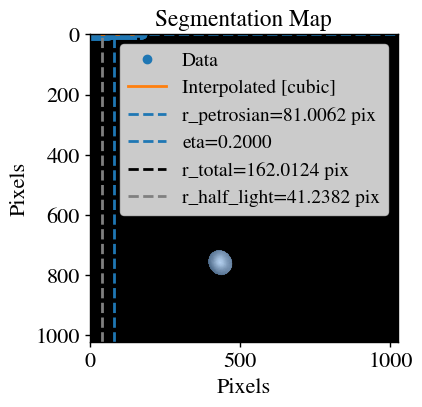

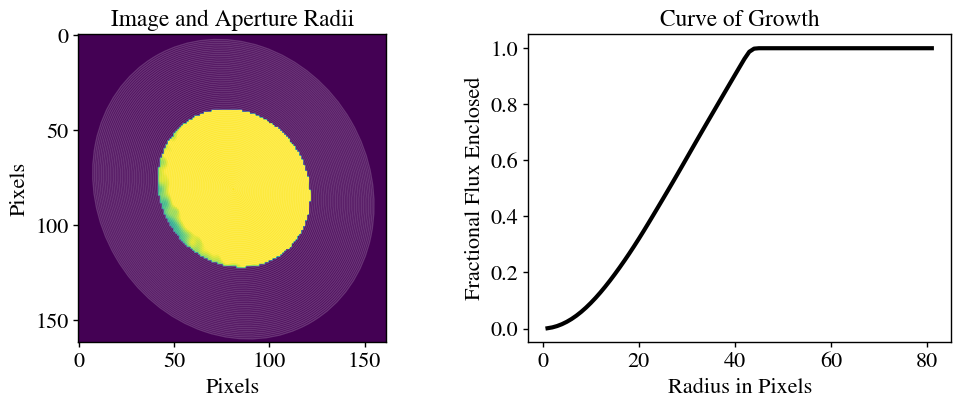

1


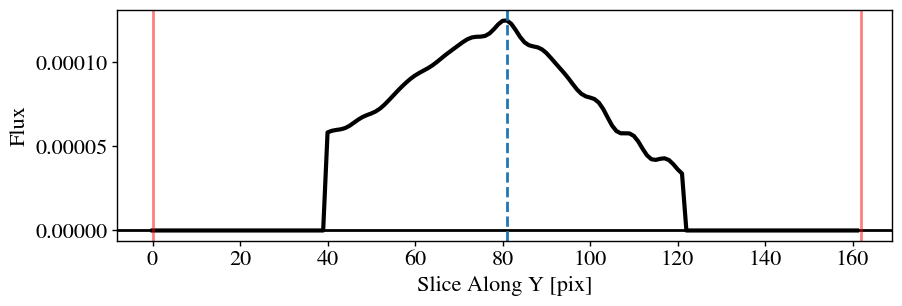

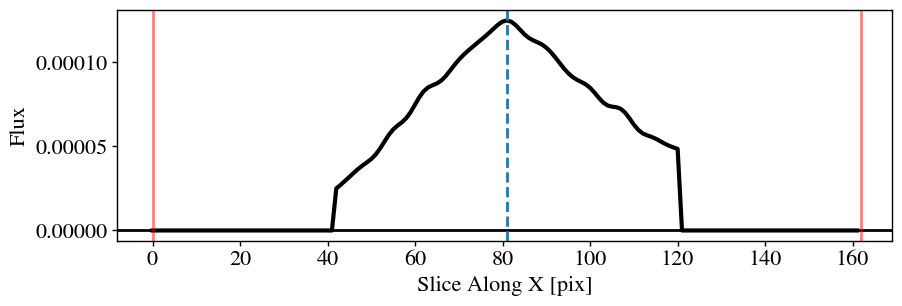

<Figure size 640x480 with 0 Axes>

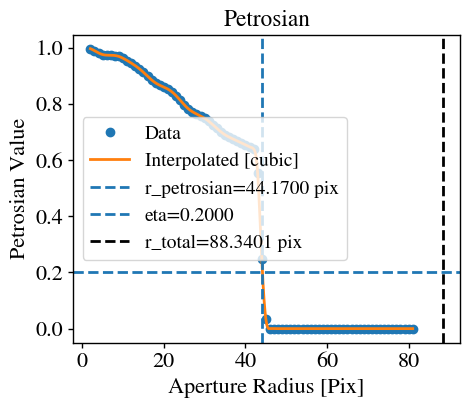

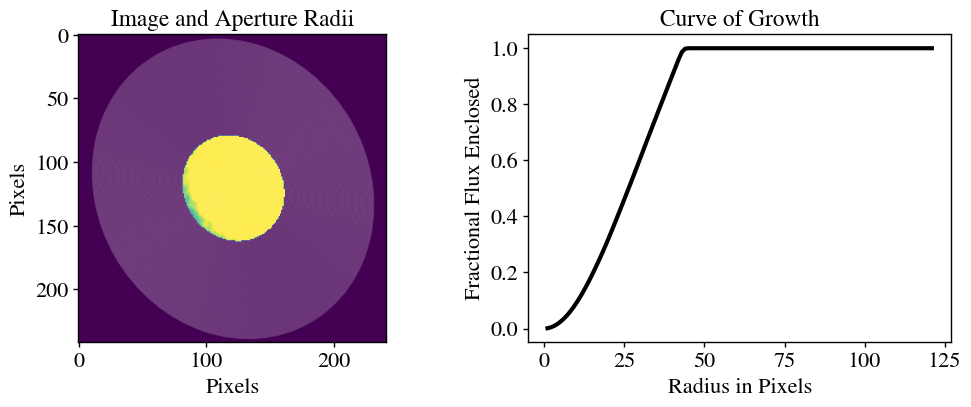

PSF SIZE is 1024
INFO: Using Elliptical Gaussian for Gaussian beam convolution.
# of components to be fitted = 3


2023-08-23 10:24:28	WARN	componentlist::close	componentlist closed


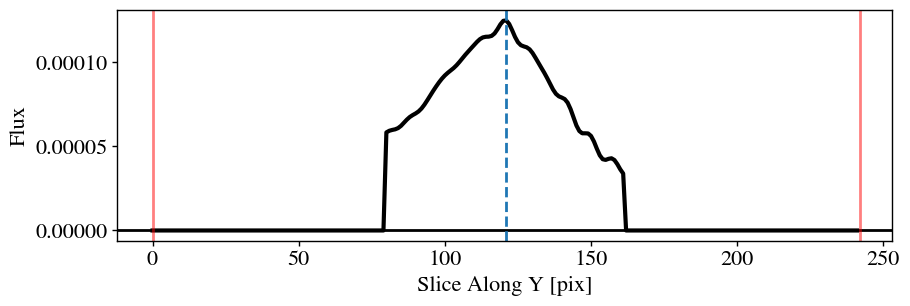

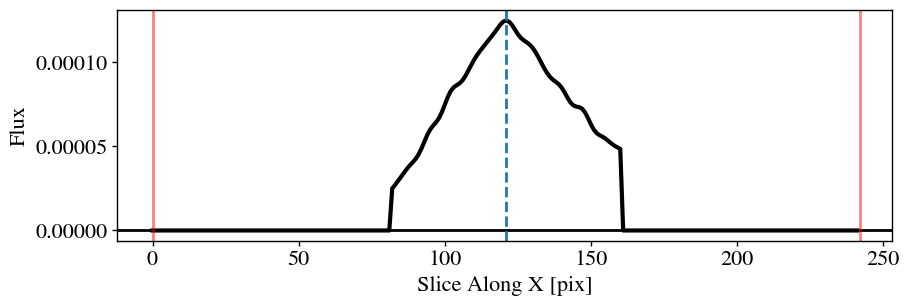

<Figure size 640x480 with 0 Axes>

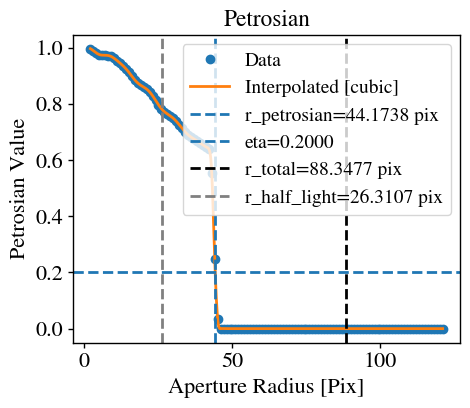

In [80]:
sources_photometries_new, n_components_new, psf_name,mask = \
    prepare_fit(crop_image,crop_residual,z=z_d['VV705'],
                bw=bspx/3,bh=bspx/3,fw=bspx/6,fh=bspx/6,
                # bw=bspx,bh=bspx,fw=bspx/2,fh=bspx/2,
                # bw=bspx/2,bh=bspx/2,fw=bspx,fh=bspx,
                sigma=10,ell_size_factor=3.0,
                deblend_cont = 0.000000001)

## First Fit Try 
The first try will fit these detected components to the data, and check the results. 
Be aware that since the emission structure is complex, the fit may not be adequate. 

Fitting clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..0.5-MFS-image.cutout_north.fits
rms res =  0.7591070563855148
rms data =  6.078438450334598 ; rms res =  4.614185519454027 ; ratio =  0.7591070563855148


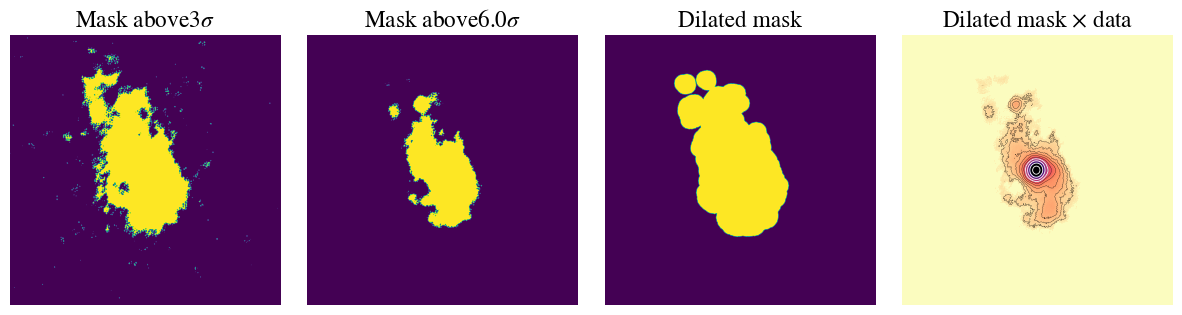

PSF SIZE is 1024
INFO: Using Elliptical Gaussian for Gaussian beam convolution.


2023-08-23 10:31:46	WARN	componentlist::close	componentlist closed


Using clean background for optmization...
---------------------------------------
<<< PERFORMING CONVOLUTION WITH GPU >>>
---------------------------------------
Limiting  x0
Limiting  y0
Fixing Sersic Index of component 0  to 0.5.
Limiting  x0
Limiting  y0
Fixing Sersic Index of component 1  to 0.5.
Limiting  x0
Limiting  y0
Fixing Sersic Index of component 2  to 0.5.
{'f1_x0': {'value': 508.9665927981824, 'min': 503.9665927981824, 'max': 513.9665927981823}, 'f1_y0': {'value': 510.22574656569464, 'min': 505.22574656569464, 'max': 515.2257465656946}, 'f1_PA': {'value': 63.75996569153195, 'min': -26.240034308468047, 'max': 153.75996569153196}, 'f1_ell': {'value': 0.04204544565610713, 'min': 0.008409089131221426, 'max': 0.5}, 'f1_n': {'value': 0.5, 'min': 0.49, 'max': 0.51}, 'f1_In': {'value': 0.0025613890854098522, 'min': 0.0002561389085409852, 'max': 0.1280694542704926}, 'f1_Rn': {'value': 29.52110422084417, 'min': 2.952110422084417, 'max': 88.56331266253251}, 'f1_cg': {'value': 0.0, '

Flux on compact (self rms) =  9.10307714913117
Flux on compact (data rms) =  8.858765325177178
Flux on extended (self rms) =  3.4887103583950867
Flux on extended (data rms) =  3.6025032140764823
Flux on extended2 (data rms) =  3.481110627413395
Flux on extended model (data rms) =  2.067384739012384
Flux on data =  11.973574330450392
Flux on residual =  1.0474242662608297


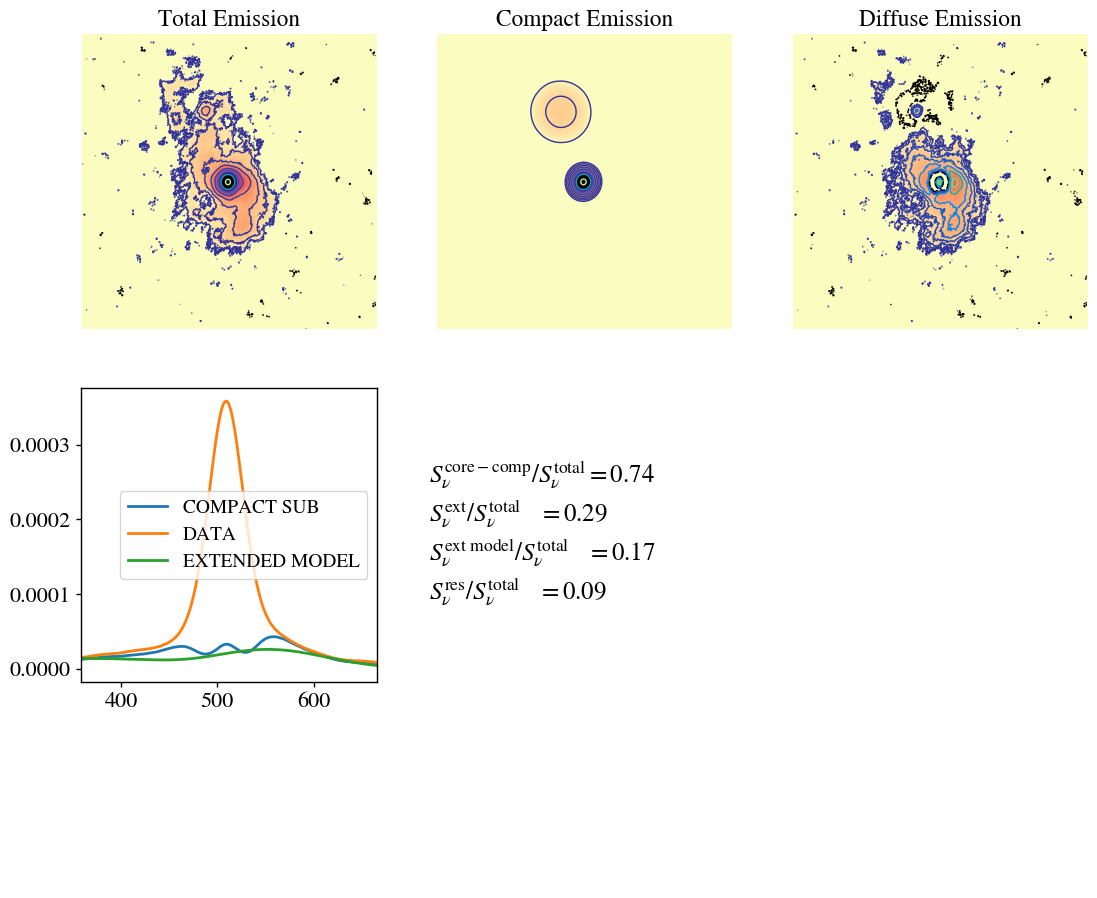

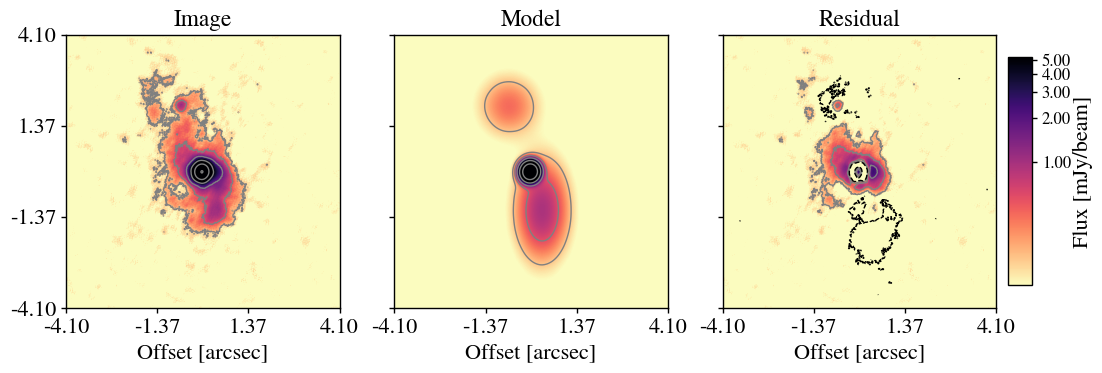

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:3590: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


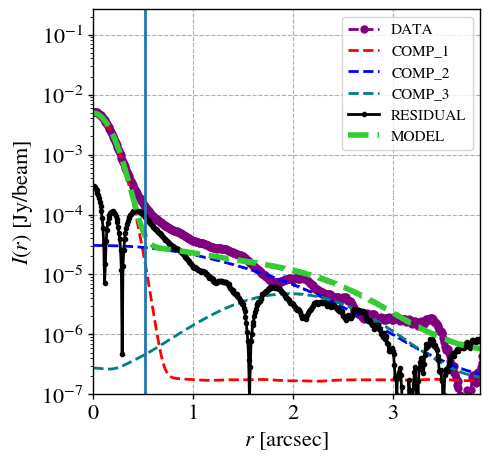

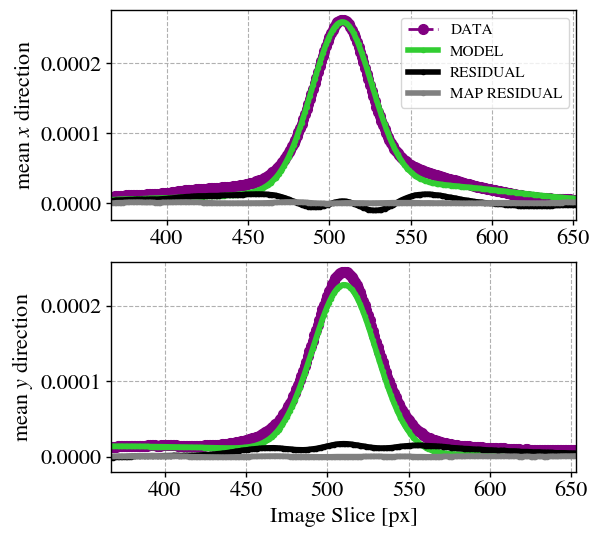

5.999
Using rms provided...
Inner Perimeter (%50): 148.24571657351277
Outer Perimeter (%90): 351.97842502555363
Outer Perimeter (%99): 3882.140782240518
128 512 384
ctr=(  507.50   510.50)     I=    0.00     q=    0.93     PA=   90.00
ctr=(  508.00   510.50)     I=    0.00     q=    0.97     PA=   90.01
ctr=(  507.50   510.50)     I=    0.00     q=    0.94     PA=   90.00
ctr=(  508.00   510.50)     I=    0.00     q=    0.97     PA=   90.00
ctr=(  507.50   510.50)     I=    0.00     q=    0.94     PA=   90.00
ctr=(  508.00   510.50)     I=    0.00     q=    0.97     PA=   90.00
ctr=(  507.50   510.50)     I=    0.00     q=    0.94     PA=   90.00
ctr=(  507.50   510.50)     I=    0.00     q=    0.94     PA=   90.00
ctr=(  507.51   510.50)     I=    0.00     q=    0.95     PA=   89.97
ctr=(  507.52   510.50)     I=    0.00     q=    0.95     PA=   89.92
ctr=(  507.53   510.49)     I=    0.00     q=    0.95     PA=   89.66
ctr=(  507.55   510.52)     I=    0.00     q=    0.95     PA=  17

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:277: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(gal), origin='lower')


Initial PA and q =  109.18691080960315 0.3602630952813217
Median PA and q =  170.3235000144026 0.9369017118699843
Inner-Mean PA and q =  89.9990851841436 0.9502185942595918
Outer-Mean PA and q =  170.37399296114478 0.9348368574831882
12.628271971179554 23.62196500040132 37.956166098116874 55.97147398292159
R50/R50_100 >>  0.028151145798204623
R50 >>  23.62196500040132
R50_100 >>  140.78875992972888
Gaussianity >>  0.4640194238325449
Sum of fluxes =  0.008600740027457473


<Figure size 640x480 with 0 Axes>

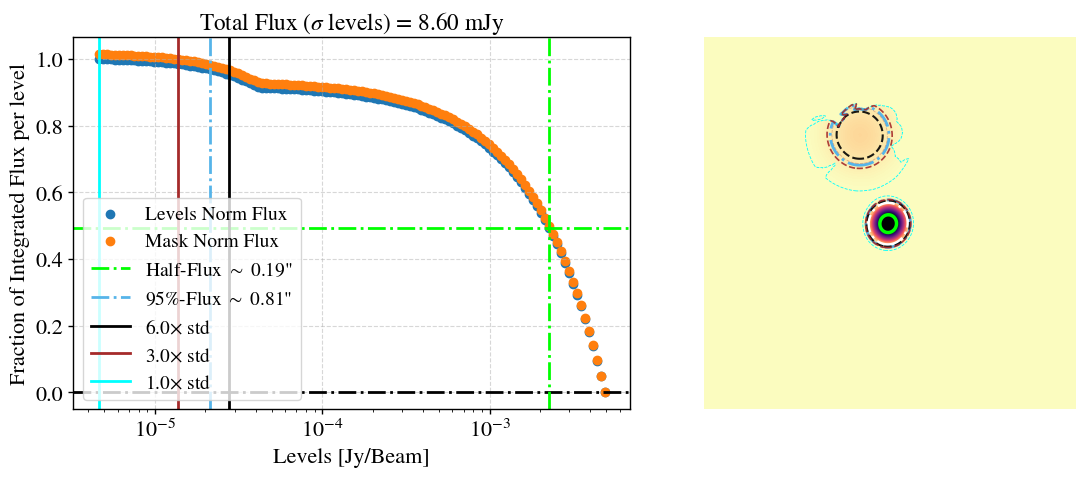

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:3590: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


D_a =  169.24419931373572 Mpc
Linear Distance =  6.564152262058192 pc
D_a =  169.24419931373572 Mpc
Linear Distance =  820.5190327572823 pc
5.999
Using rms provided...
Inner Perimeter (%50): 89.751885062508
Outer Perimeter (%90): 205.07346698270814
Outer Perimeter (%99): 3882.140782240518
128 512 384
ctr=(  506.50   509.50)     I=    0.01     q=    0.89     PA=  179.96
ctr=(  506.50   509.50)     I=    0.01     q=    1.00     PA=  175.60
ctr=(  507.00   509.50)     I=    0.01     q=    0.95     PA=  179.98
ctr=(  506.50   509.50)     I=    0.01     q=    0.90     PA=    0.01
ctr=(  506.50   509.50)     I=    0.01     q=    1.00     PA=  158.64
ctr=(  507.00   509.50)     I=    0.01     q=    0.95     PA=  180.00
ctr=(  506.50   509.50)     I=    0.01     q=    0.91     PA=    0.02
ctr=(  506.50   509.50)     I=    0.01     q=    1.00     PA=  121.67
ctr=(  506.99   509.50)     I=    0.01     q=    0.96     PA=  179.99
ctr=(  506.53   509.50)     I=    0.01     q=    1.00     PA=    0.1

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:277: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(gal), origin='lower')
/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:277: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(gal), origin='lower')


Initial PA and q =  109.28254114524789 0.3027756007220823
Median PA and q =  99.7550446328759 0.9478520951430315
Inner-Mean PA and q =  121.67030485371805 0.9521322748830363
Outer-Mean PA and q =  99.75026171035533 0.9477855304523314
7.442171739215616 14.228319915326999 22.99375395517827 32.41022407214287
R50/R50_100 >>  0.017680909621639655
R50 >>  14.228319915326999
R50_100 >>  107.00432194970975
Gaussianity >>  0.46977007602468895
Sum of fluxes =  0.008509843537091468


<Figure size 640x480 with 0 Axes>

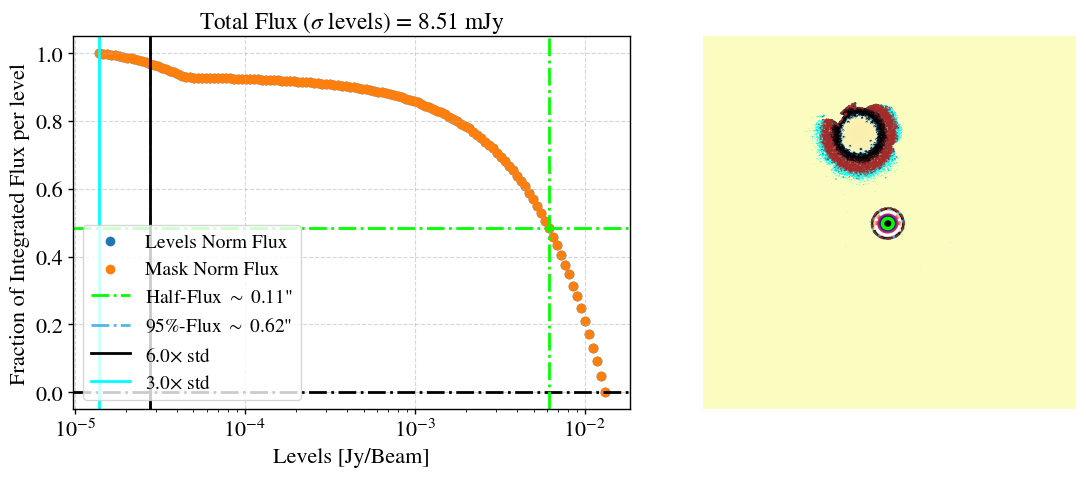

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:3590: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


D_a =  169.24419931373572 Mpc
Linear Distance =  6.564152262058192 pc
D_a =  169.24419931373572 Mpc
Linear Distance =  820.5190327572823 pc
5.999
Using rms provided...
Inner Perimeter (%50): 535.3302494753596
Outer Perimeter (%90): 891.712089192973
Outer Perimeter (%99): 3882.140782240518
128 512 384
ctr=(  553.00   373.00)     I=    0.00     q=    0.58     PA=   90.00
ctr=(  553.00   374.00)     I=    0.00     q=    0.58     PA=   90.00
ctr=(  552.50   375.50)     I=    0.00     q=    0.60     PA=   90.00
ctr=(  552.50   376.50)     I=    0.00     q=    0.60     PA=   90.00
ctr=(  552.00   377.50)     I=    0.00     q=    0.60     PA=   90.00
ctr=(  552.00   378.50)     I=    0.00     q=    0.61     PA=   90.00
ctr=(  552.00   379.00)     I=    0.00     q=    0.62     PA=   90.00
ctr=(  552.50   380.00)     I=    0.00     q=    0.62     PA=   90.00
ctr=(  552.50   381.00)     I=    0.00     q=    0.62     PA=   90.00
ctr=(  552.00   382.50)     I=    0.00     q=    0.62     PA=   90.0

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:12364: RuntimeWarning: divide by zero encountered in divide
  y0peak, x0peak = nd.maximum_position((image / rr2))


ctr=(  551.44   402.56)     I=    0.00     q=    0.71     PA=  178.28
ctr=(  551.19   404.62)     I=    0.00     q=    0.72     PA=  177.89
ctr=(  550.91   406.62)     I=    0.00     q=    0.73     PA=  177.46
ctr=(  550.68   407.89)     I=    0.00     q=    0.74     PA=  177.01
ctr=(  550.43   409.32)     I=    0.00     q=    0.74     PA=  176.57
ctr=(  550.44   410.89)     I=    0.00     q=    0.74     PA=  176.52
ctr=(  550.19   412.13)     I=    0.00     q=    0.74     PA=  176.00
ctr=(  550.20   413.68)     I=    0.00     q=    0.75     PA=  175.93
ctr=(  550.20   414.46)     I=    0.00     q=    0.75     PA=  175.88
ctr=(  549.66   415.97)     I=    0.00     q=    0.75     PA=  175.07
ctr=(  549.66   417.42)     I=    0.00     q=    0.75     PA=  174.98
ctr=(  549.67   418.29)     I=    0.00     q=    0.75     PA=  174.98
ctr=(  549.66   419.59)     I=    0.00     q=    0.75     PA=  174.83
ctr=(  549.11   421.13)     I=    0.00     q=    0.75     PA=  173.94
ctr=(  549.10   421.

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:277: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(gal), origin='lower')


Initial PA and q =  90.37381500378024 0.6310815029379325
Median PA and q =  90.01928371733663 0.6649875630853974
Inner-Mean PA and q =  90.00000001153639 0.6167214339605248
Outer-Mean PA and q =  141.27500206789617 0.6927004401473539
44.59596583634359 79.14556367991081 114.6915692043018 134.6263221269112
R50/R50_100 >>  0.2713109894806502
R50 >>  79.14556367991081
R50_100 >>  151.94726379428124
Gaussianity >>  0.6272722127885925
Sum of fluxes =  0.002136622949579149


<Figure size 640x480 with 0 Axes>

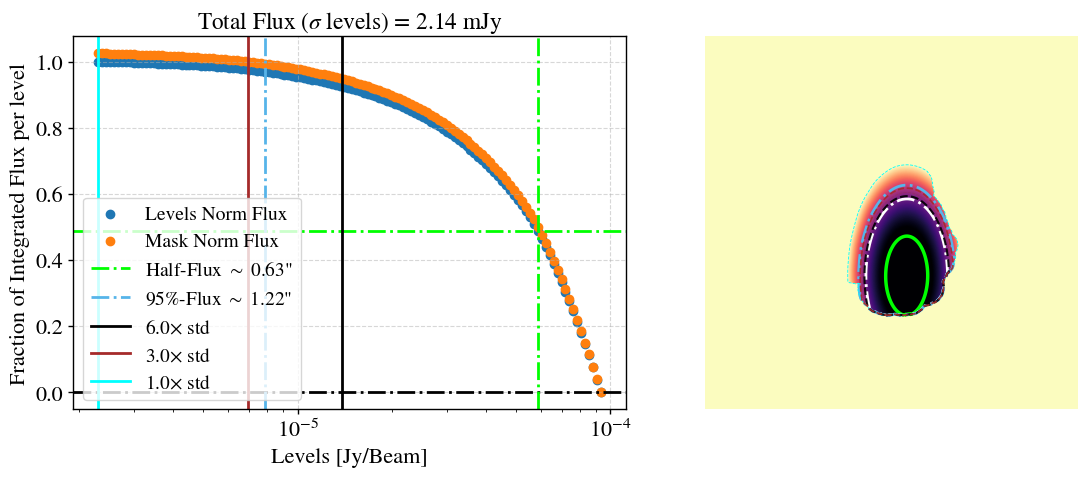

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:3590: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


D_a =  169.24419931373572 Mpc
Linear Distance =  6.564152262058192 pc
D_a =  169.24419931373572 Mpc
Linear Distance =  820.5190327572823 pc
5.999
Using rms provided...
Inner Perimeter (%50): 1568.1253488329417
Outer Perimeter (%90): 3227.6523155473824
Outer Perimeter (%99): 3882.140782240518
128 512 384
ctr=(  552.00   371.00)     I=    0.00     q=    0.57     PA=   90.00
ctr=(  551.50   371.50)     I=    0.00     q=    0.57     PA=   90.00
ctr=(  552.00   372.50)     I=    0.00     q=    0.57     PA=   90.00
ctr=(  552.00   373.00)     I=    0.00     q=    0.58     PA=   90.00
ctr=(  551.50   374.00)     I=    0.00     q=    0.58     PA=   90.00
ctr=(  551.50   374.50)     I=    0.00     q=    0.59     PA=   90.00
ctr=(  551.50   375.00)     I=    0.00     q=    0.58     PA=   90.00
ctr=(  551.50   376.00)     I=    0.00     q=    0.59     PA=   90.00
ctr=(  551.50   376.50)     I=    0.00     q=    0.60     PA=   90.00
ctr=(  551.50   377.00)     I=    0.00     q=    0.59     PA=   9

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:12364: RuntimeWarning: divide by zero encountered in divide
  y0peak, x0peak = nd.maximum_position((image / rr2))


ctr=(  550.85   388.67)     I=    0.00     q=    0.64     PA=   89.89
ctr=(  550.91   389.30)     I=    0.00     q=    0.65     PA=  179.78
ctr=(  550.96   389.66)     I=    0.00     q=    0.65     PA=  179.70
ctr=(  550.64   390.79)     I=    0.00     q=    0.65     PA=  179.60
ctr=(  550.70   391.61)     I=    0.00     q=    0.65     PA=  179.53
ctr=(  550.40   392.20)     I=    0.00     q=    0.66     PA=  179.39
ctr=(  550.79   393.00)     I=    0.00     q=    0.66     PA=  179.38
ctr=(  550.83   393.84)     I=    0.00     q=    0.67     PA=  179.29
ctr=(  550.59   394.66)     I=    0.00     q=    0.67     PA=  179.00
ctr=(  550.62   395.80)     I=    0.00     q=    0.67     PA=  178.97
ctr=(  550.63   396.63)     I=    0.00     q=    0.67     PA=  178.90
ctr=(  550.70   397.72)     I=    0.00     q=    0.69     PA=  178.73
ctr=(  550.67   399.09)     I=    0.00     q=    0.69     PA=  178.74
ctr=(  550.38   399.72)     I=    0.00     q=    0.70     PA=  178.42
ctr=(  550.41   401.

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:277: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(gal), origin='lower')
/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:277: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(gal), origin='lower')


Initial PA and q =  90.3151562187654 0.6229163391892176
Median PA and q =  165.51302579771385 0.7354972366754191
Inner-Mean PA and q =  89.99999999630316 0.60174889101711
Outer-Mean PA and q =  170.97430865546573 0.7439210198416386
45.272479025755025 76.48879465685201 110.28138615065679 128.3404198624363
R50/R50_100 >>  0.33039132857579406
R50 >>  76.48879465685201
R50_100 >>  133.07102343594738
Gaussianity >>  0.6159099992538174
Sum of fluxes =  0.002101190587290385


<Figure size 640x480 with 0 Axes>

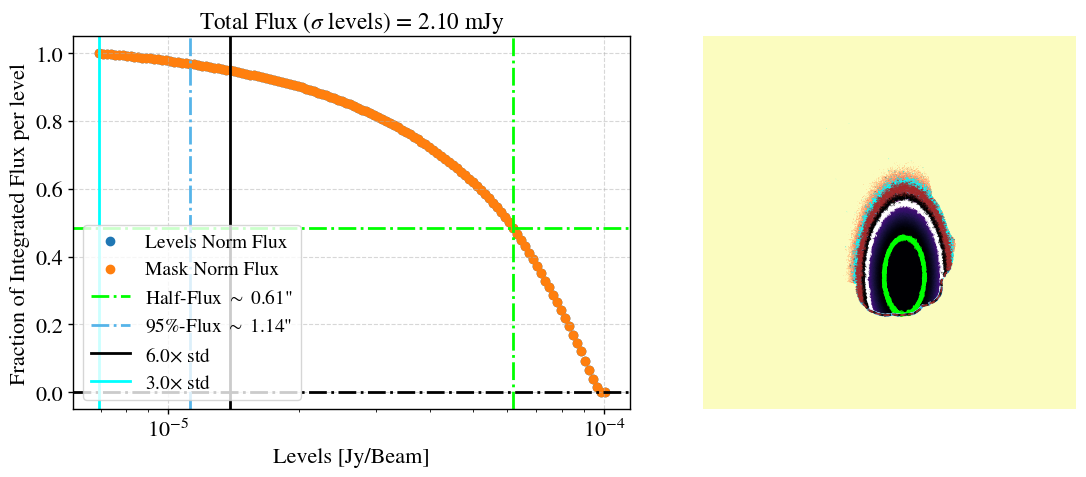

D_a =  169.24419931373572 Mpc
Linear Distance =  6.564152262058192 pc
D_a =  169.24419931373572 Mpc
Linear Distance =  820.5190327572823 pc


/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:3590: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


In [85]:
results_fit,lmfit_results, lmfit_results_1st_pass, errors_fit, models, \
    results_compact_conv_morpho,results_compact_deconv_morpho,results_ext_conv_morpho,results_ext_deconv_morpho = \
    run_image_fitting(imagelist = imagelist_vla[[-2]],aspect=None,
                      residuallist = residuallist_vla[[-2]],
                      comp_ids=['1','3'],#which IDs refers to compact components?
                      sources_photometries = sources_photometries_new,
                      n_components = n_components_new,z=z_d['VV705'],
                      convolution_mode='GPU',
                      method1 = 'least_squares',method2 = 'least_squares',
                      mask=mask,
                      save_name_append='_ls',
#                       save_name_append='_ls_n0G_cb',
                      #                       save_name_append='_ls_n10G0G',
                      fix_n = [True,True,True],
                      fix_value_n=[0.5,0.5,0.5],fix_geometry=True,#unstable if set to False. 
                      dr_fix=[5,5,5])


## Second Fit Attempt

In our example, we see that the morphology of the emission is asymetric. <br> 
It is clear that the component `ID1` can not be moddeled by a simple model component. <br> 
Therefore, we may want to fit an extra model-component together `ID1`. This can be done <br> 
by specifing the ID that we want to add the extra model-component with the argument `ids_to_add`. <br> 
In our case, we are going to add two extra model-components:
    - one to be fitted together `ID1`;
    - another to model the large-scale diffuse emission. 
    
To add these components, we simply use the argument `ids_to_add` and set, <br>
for example `ids_to_add = [1,1]` or `ids_to_add = [1,4]`. 
Why `4` in the last case? Well, we added one component to `ID1`, so we have now <br>
a new component `ID4` which represents a large scale structure. So, we can also append <br>
a new model-component to it. 

D_a =  169.24419931373572 Mpc
Linear Distance =  6.564152262058192 pc


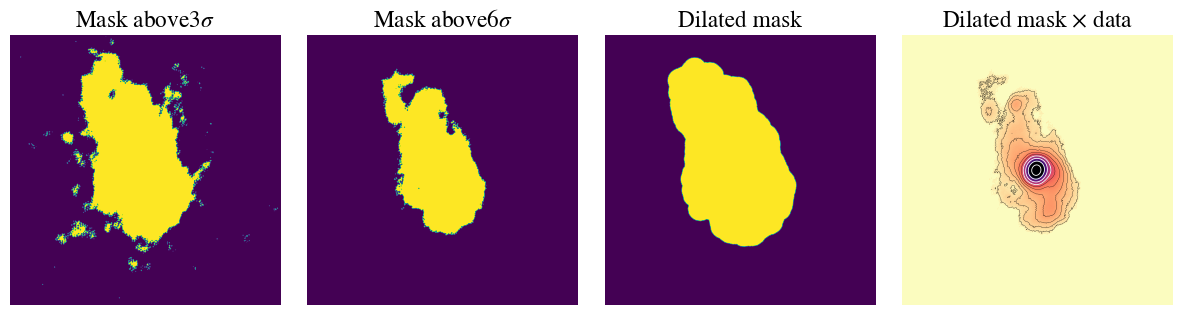

<Figure size 640x480 with 0 Axes>

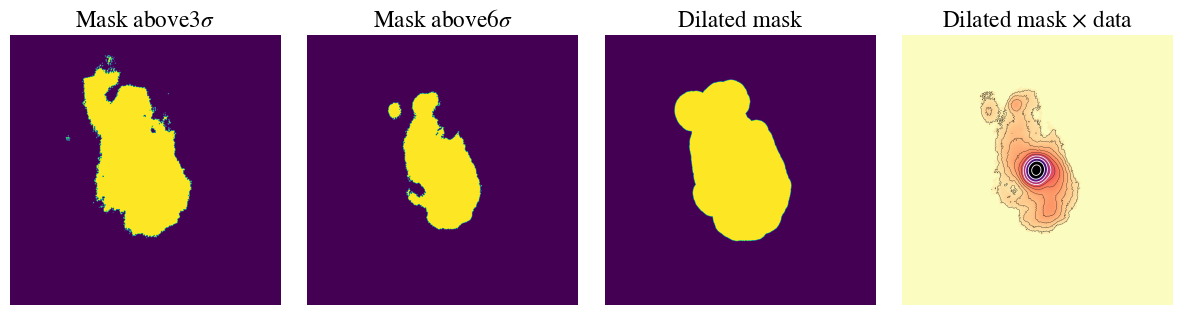

2.196838295276393e-06
1.7609556834941031e-06
object 0: flux = 0.001419 +/- 0.037670
object 1: flux = 0.134557 +/- 0.366821
object 2: flux = 0.002146 +/- 0.046329
1


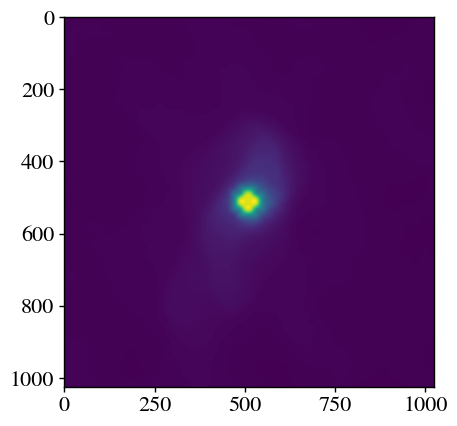

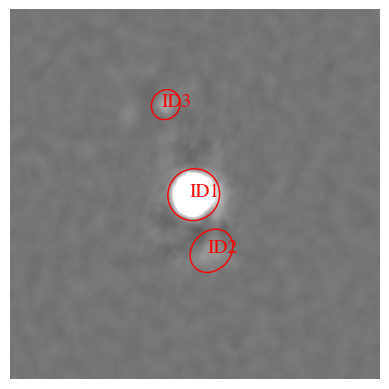

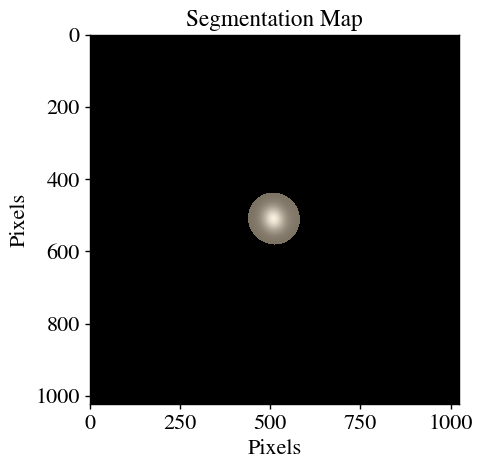

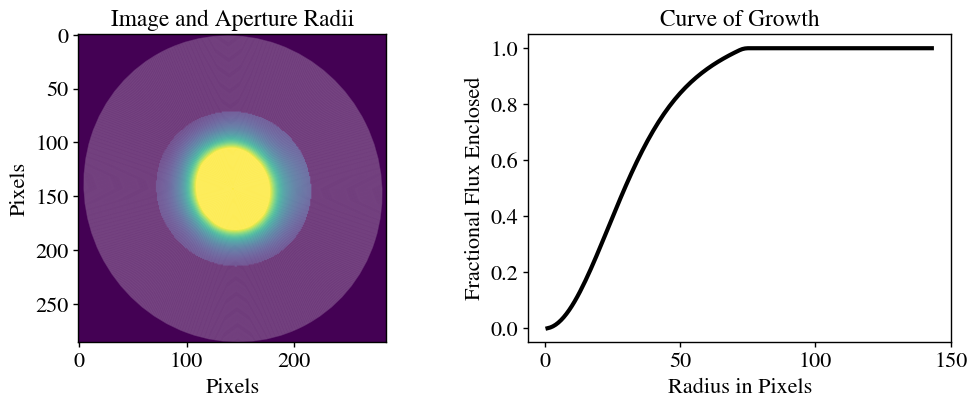

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:3590: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


1


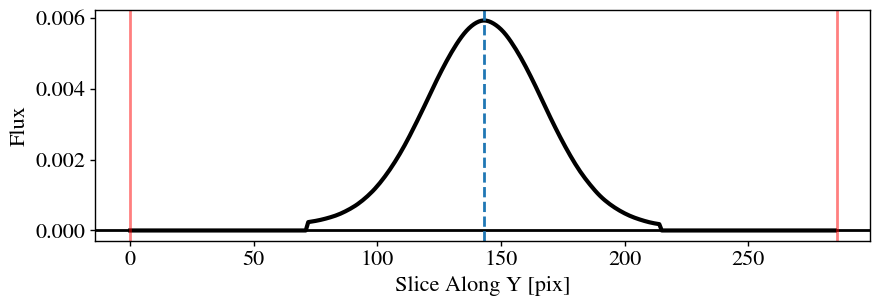

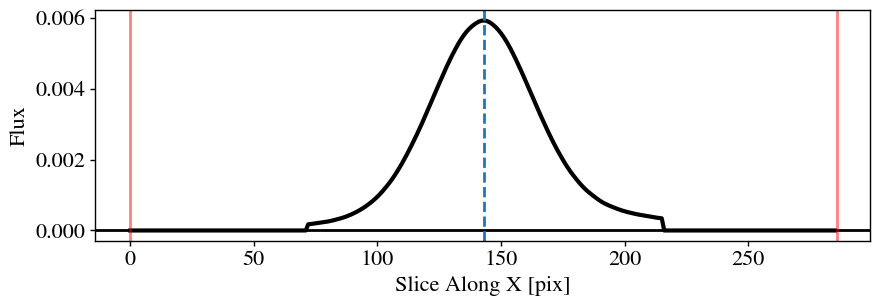

<Figure size 640x480 with 0 Axes>

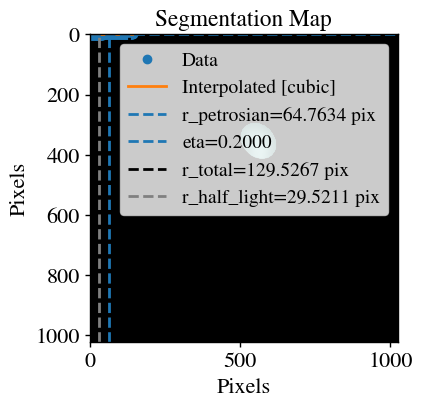

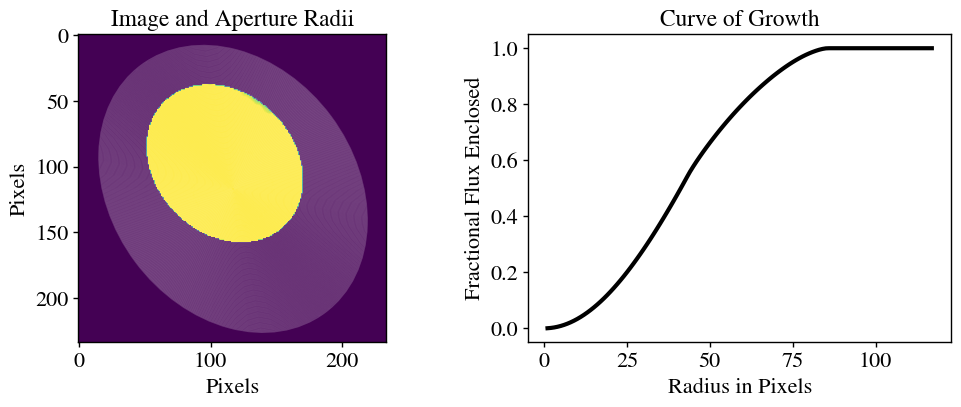

1


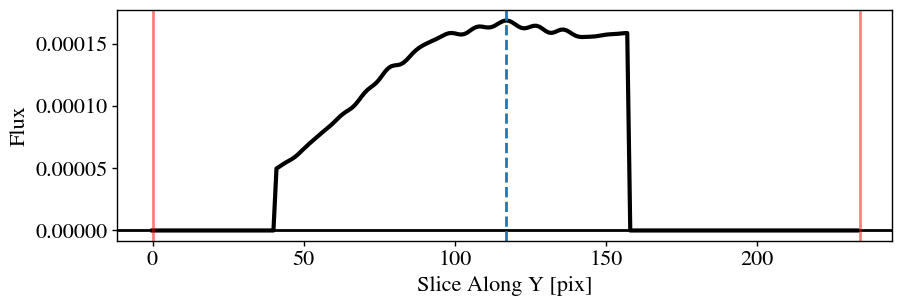

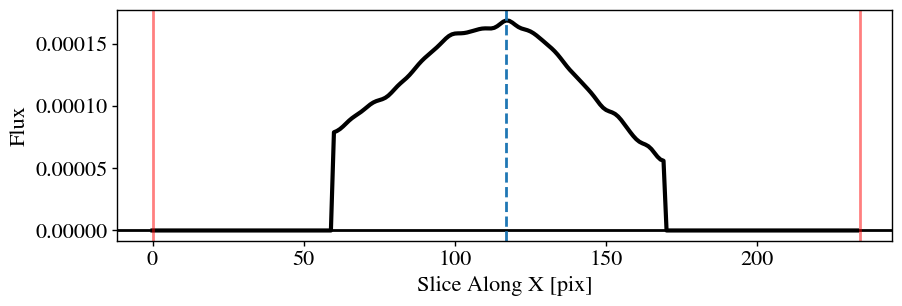

<Figure size 640x480 with 0 Axes>

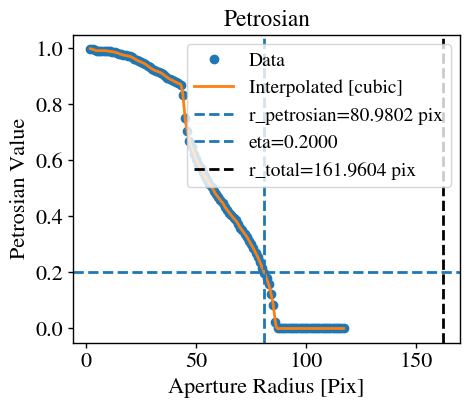

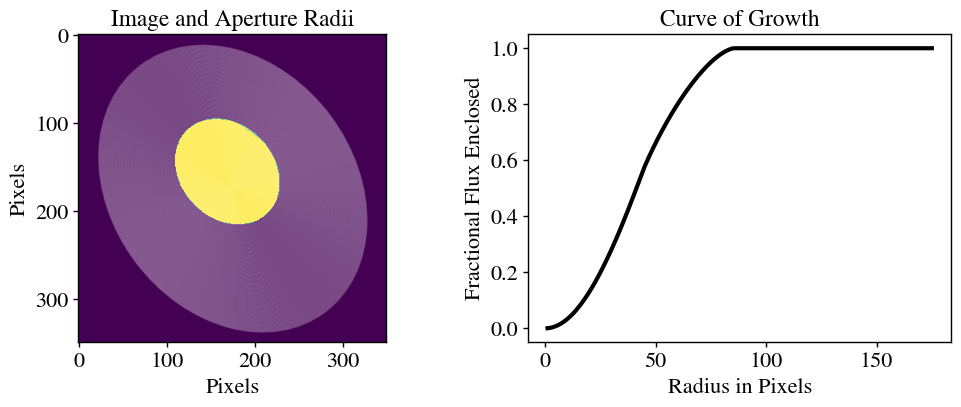

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:3590: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


1


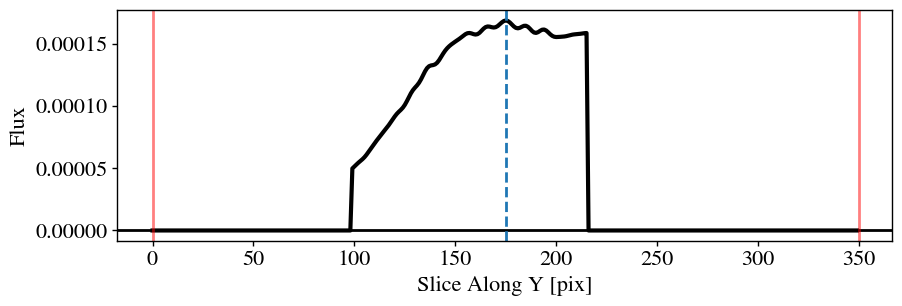

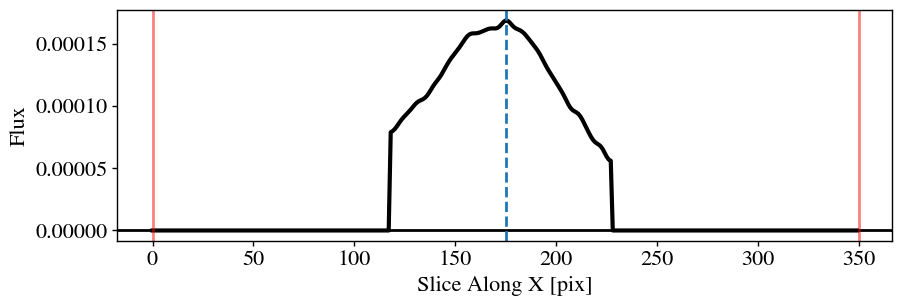

<Figure size 640x480 with 0 Axes>

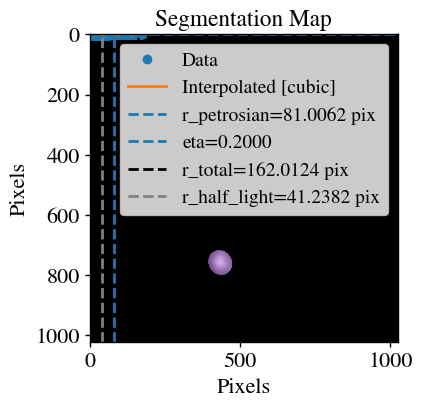

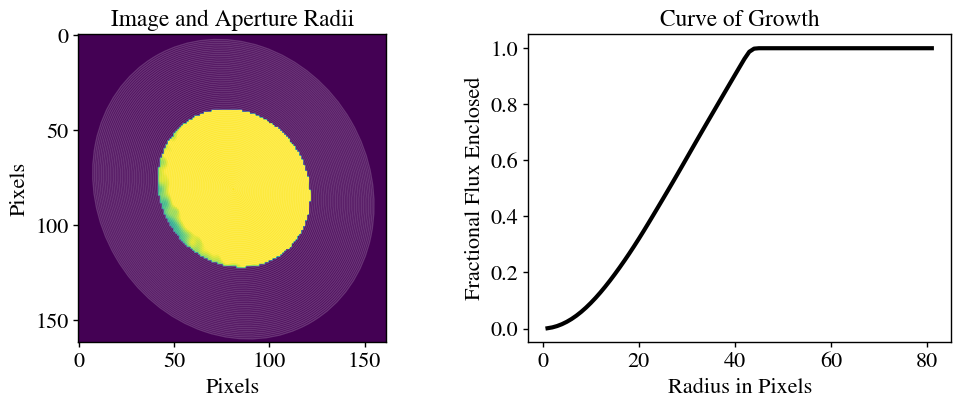

1


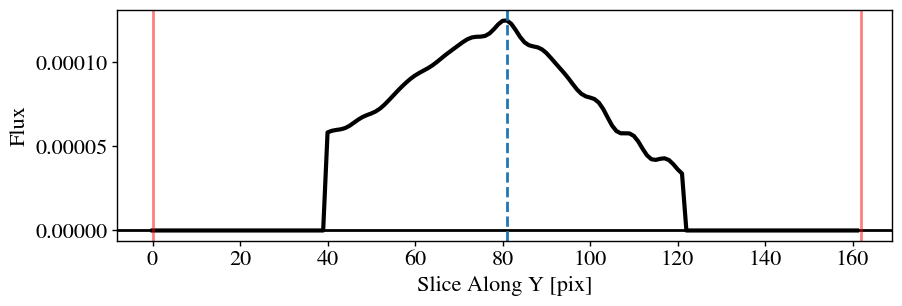

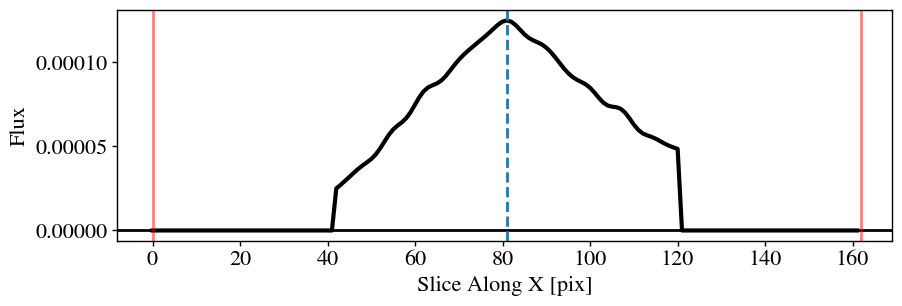

<Figure size 640x480 with 0 Axes>

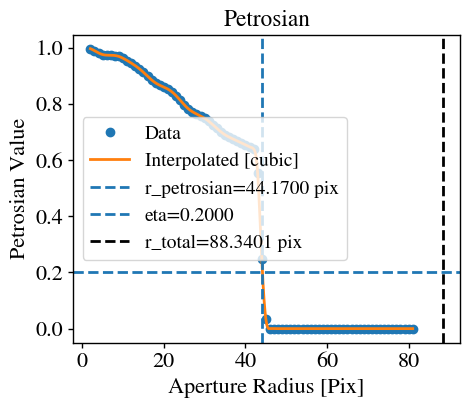

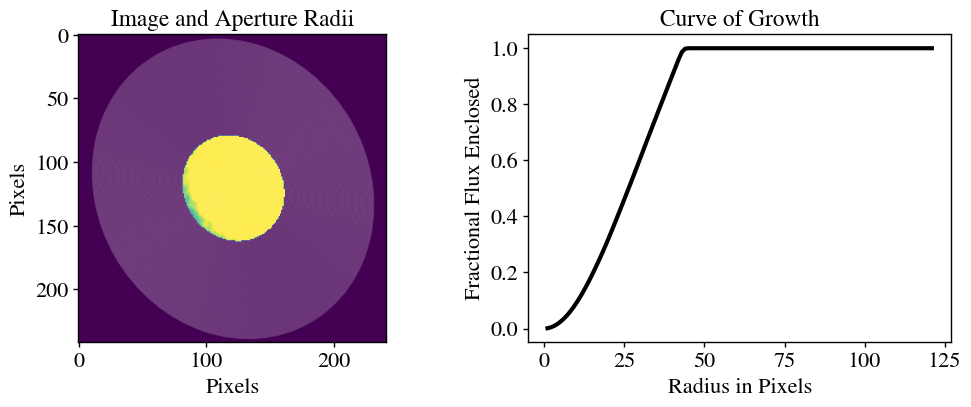

PSF SIZE is 1024
INFO: Using Elliptical Gaussian for Gaussian beam convolution.
# of components to be fitted = 3
# of components to be fitted = 4
# of components to be fitted = 5


2023-08-23 10:47:59	WARN	componentlist::close	componentlist closed


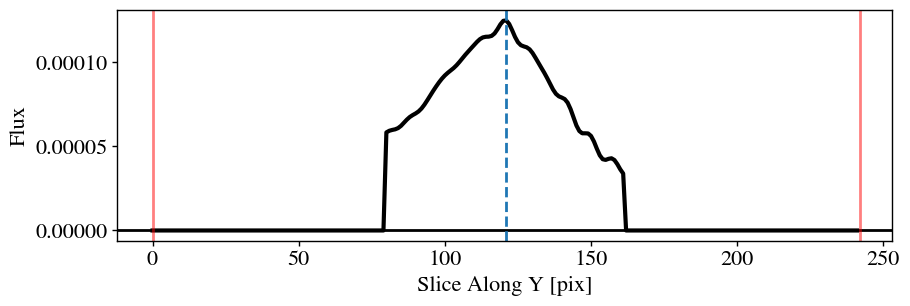

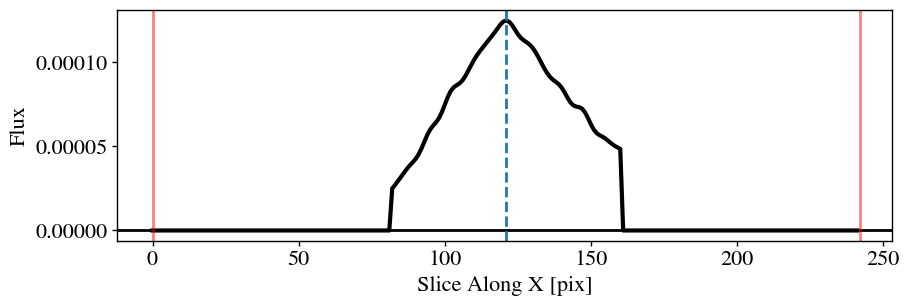

<Figure size 640x480 with 0 Axes>

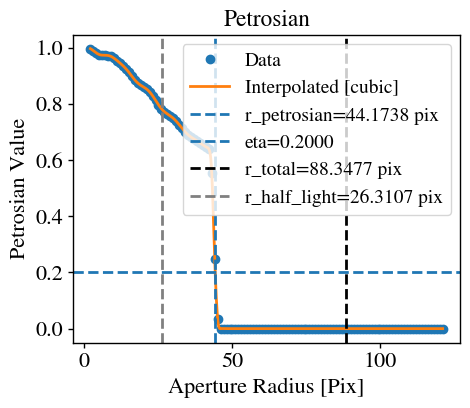

In [95]:
sources_photometries_new, n_components_new, psf_name,mask = \
    prepare_fit(crop_image,crop_residual,z=z_d['VV705'],
                bw=bspx/3,bh=bspx/3,fw=bspx/6,fh=bspx/6,
                # bw=bspx,bh=bspx,fw=bspx/2,fh=bspx/2,
                # bw=bspx/2,bh=bspx/2,fw=bspx,fh=bspx,
                sigma=10,ell_size_factor=3.0,
                deblend_cont = 0.0000000000000001,
                ids_to_add=[1,4])

In [89]:
# now we have the total number of components to be fitted to the data (3 detected + 2 manually added). 
n_components_new

5

In [90]:
# we also have the properties for each region. 
# Note that the properties for the manually added component are a copy from ID1, except that the effective radii
# is multiplied by 4 and the effective intensity divided by 10. 
# Check more info from the function `add_extra_component`.
sources_photometries_new

{'c1_PA': 63.75996569153195,
 'c1_q': 0.9579545543438929,
 'c1_area': 16188.0,
 'c1_Re': 71.78300939319278,
 'c1_x0c': 508.9665927981824,
 'c1_y0c': 510.22574656569464,
 'c1_label': 1,
 'c1_R50': 29.52110422084417,
 'c1_R20': 16.419683936787358,
 'c1_R80': 46.59871974394879,
 'c1_C1': 0.4530091919105359,
 'c1_Snu': 21.077567000000005,
 'c1_Rp': 64.7633526705341,
 'c1_Rpidx': 129,
 'c1_rlast': 143,
 'c1_I50': 0.0025613890854098522,
 'c2_PA': 53.4054593755422,
 'c2_q': 0.7907405467055485,
 'c2_area': 10881.0,
 'c2_Re': 58.85176183909728,
 'c2_x0c': 557.1395773578104,
 'c2_y0c': 359.96232264635734,
 'c2_label': 1,
 'c2_R50': 41.2382476495299,
 'c2_R20': 24.95999199839968,
 'c2_R80': 59.8619723944789,
 'c2_C1': 0.37990658054028825,
 'c2_Snu': 1.2043010000000005,
 'c2_Rp': 81.00620124024805,
 'c2_Rpidx': 162,
 'c2_rlast': 175,
 'c2_I50': 9.306839715731364e-05,
 'c3_PA': 59.93252912231897,
 'c3_q': 0.8815822867014519,
 'c3_area': 5179.0,
 'c3_Re': 40.60205537341493,
 'c3_x0c': 432.8572317465

In [91]:
# np.sqrt((sources_photometries_new['c1_x0c']-sources_photometries_new['c2_x0c'])**2+(sources_photometries_new['c1_y0c']-sources_photometries_new['c2_y0c'])**2)*pix_to_pc/1000

In [92]:
# %env XLA_PYTHON_CLIENT_MEM_FRACTION=0.25
# %env TF_CPP_MIN_LOG_LEVEL=0

In [93]:
# imview(crop_image)

Fitting clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..1.0-MFS-image.cutout_north.fits
rms res =  0.6380795802619506
rms data =  6.430414371954692 ; rms res =  4.103116103367264 ; ratio =  0.6380795802619506


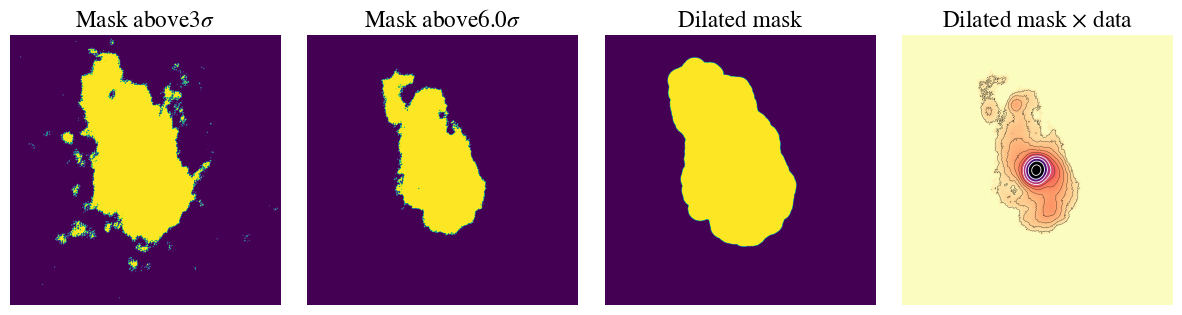

PSF SIZE is 1024
INFO: Using Elliptical Gaussian for Gaussian beam convolution.


2023-08-23 10:56:10	WARN	componentlist::close	componentlist closed


Using clean background for optmization...
---------------------------------------
<<< PERFORMING CONVOLUTION WITH GPU >>>
---------------------------------------
Limiting  x0
Limiting  y0
Fixing Sersic Index of component 0  to 0.5.
Limiting  x0
Limiting  y0
Fixing Sersic Index of component 1  to 0.5.
Limiting  x0
Limiting  y0
Fixing Sersic Index of component 2  to 0.5.
Limiting  x0
Limiting  y0
Fixing Sersic Index of component 3  to 0.5.
Limiting  x0
Limiting  y0
Fixing Sersic Index of component 4  to 0.5.
{'f1_x0': {'value': 508.9665927981824, 'min': 503.9665927981824, 'max': 513.9665927981823}, 'f1_y0': {'value': 510.22574656569464, 'min': 505.22574656569464, 'max': 515.2257465656946}, 'f1_PA': {'value': 63.75996569153195, 'min': -26.240034308468047, 'max': 153.75996569153196}, 'f1_ell': {'value': 0.04204544565610713, 'min': 0.008409089131221426, 'max': 0.5}, 'f1_n': {'value': 0.5, 'min': 0.49, 'max': 0.51}, 'f1_In': {'value': 0.0025613890854098522, 'min': 0.0002561389085409852, 'max

Flux on compact (self rms) =  6.873620073960548
Flux on compact (data rms) =  6.777387350287087
Flux on extended (self rms) =  5.634515558631442
Flux on extended (data rms) =  5.9326865557673285
Flux on extended2 (data rms) =  5.646678579707943
Flux on extended model (data rms) =  5.638398718066781
Flux on data =  12.434175022644247
Flux on residual =  0.0183889542903799


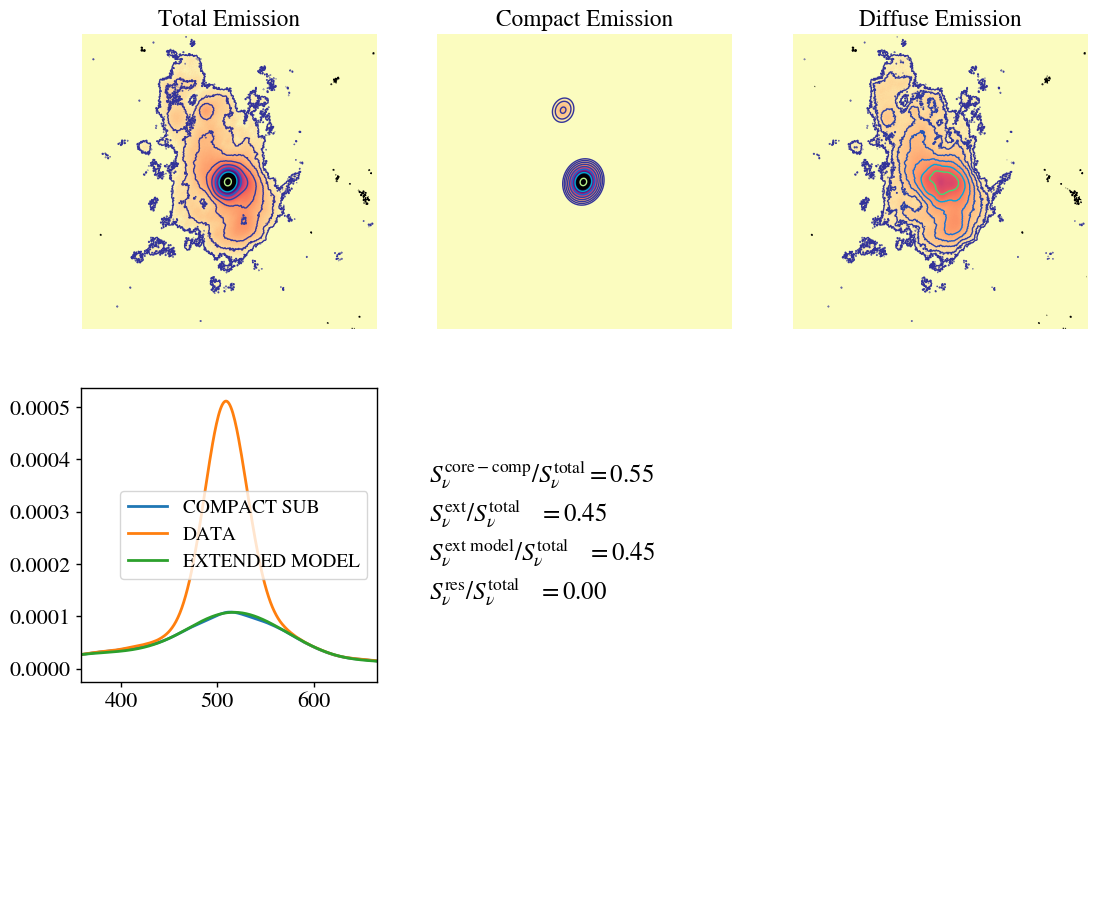

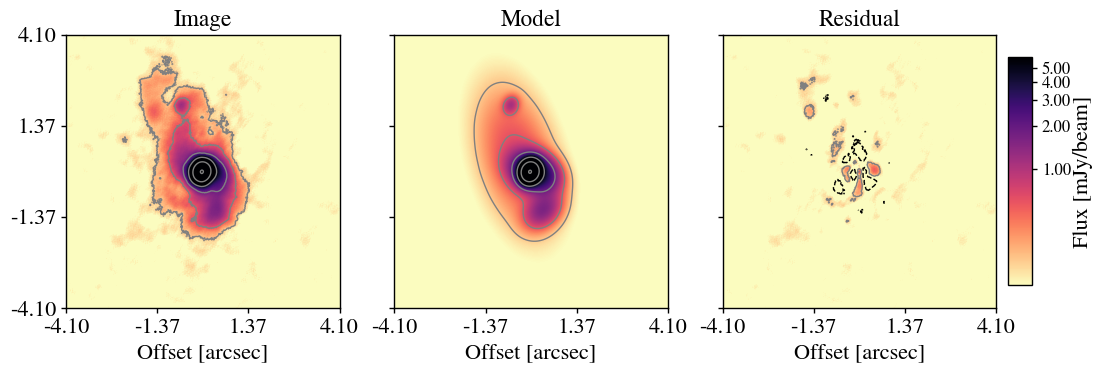

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:3590: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


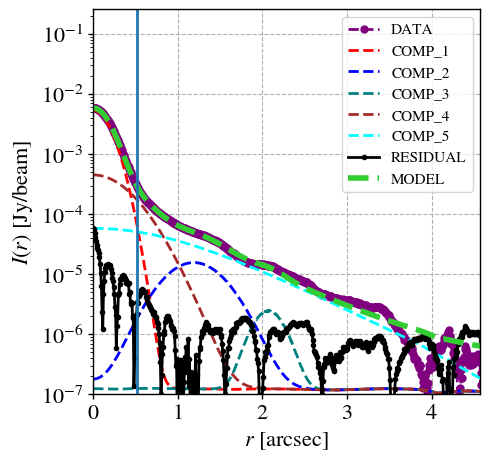

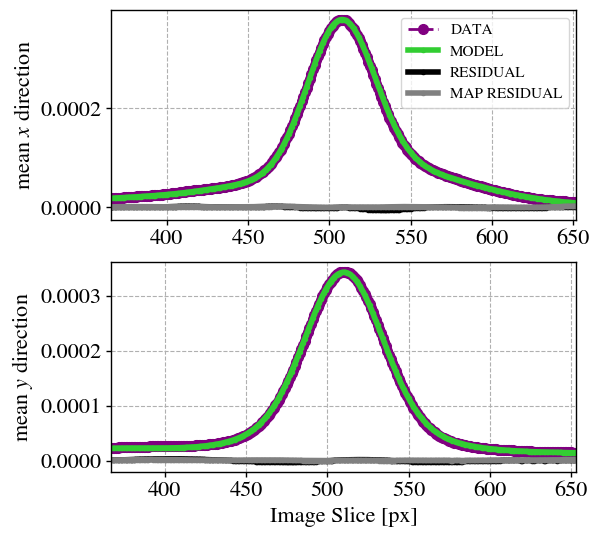

5.999
Using rms provided...
Inner Perimeter (%50): 160.08250555339032
Outer Perimeter (%90): 305.87674286169624
Outer Perimeter (%99): 3882.140782240518
128 512 384
ctr=(  507.00   510.50)     I=    0.00     q=    0.91     PA=   90.00
ctr=(  507.50   510.50)     I=    0.00     q=    0.89     PA=   90.00
ctr=(  507.00   510.00)     I=    0.00     q=    0.89     PA=   90.00
ctr=(  507.50   510.50)     I=    0.00     q=    0.89     PA=   90.00
ctr=(  507.50   510.50)     I=    0.00     q=    0.90     PA=   90.00
ctr=(  507.00   510.00)     I=    0.00     q=    0.90     PA=   90.00
ctr=(  507.50   510.50)     I=    0.00     q=    0.90     PA=   90.00
ctr=(  507.50   510.50)     I=    0.00     q=    0.86     PA=   90.00
ctr=(  507.02   510.49)     I=    0.00     q=    0.89     PA=   89.92
ctr=(  507.03   510.47)     I=    0.00     q=    0.90     PA=  179.71
ctr=(  507.04   510.05)     I=    0.00     q=    0.88     PA=  178.67
ctr=(  507.05   510.07)     I=    0.00     q=    0.89     PA=  17

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:277: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(gal), origin='lower')


Initial PA and q =  102.12630406947167 0.5791380480443112
Median PA and q =  132.13535664618942 0.8626381968146146
Inner-Mean PA and q =  89.99979786839705 0.8945396623206237
Outer-Mean PA and q =  162.5315013708851 0.8588143140731178
14.625465582862905 25.357168021907675 39.36410199588825 48.51374339754611
R50/R50_100 >>  0.07357762074743207
R50 >>  25.357168021907675
R50_100 >>  93.48197481487964
Gaussianity >>  0.5076395968224113
Sum of fluxes =  0.006763366012248074


<Figure size 640x480 with 0 Axes>

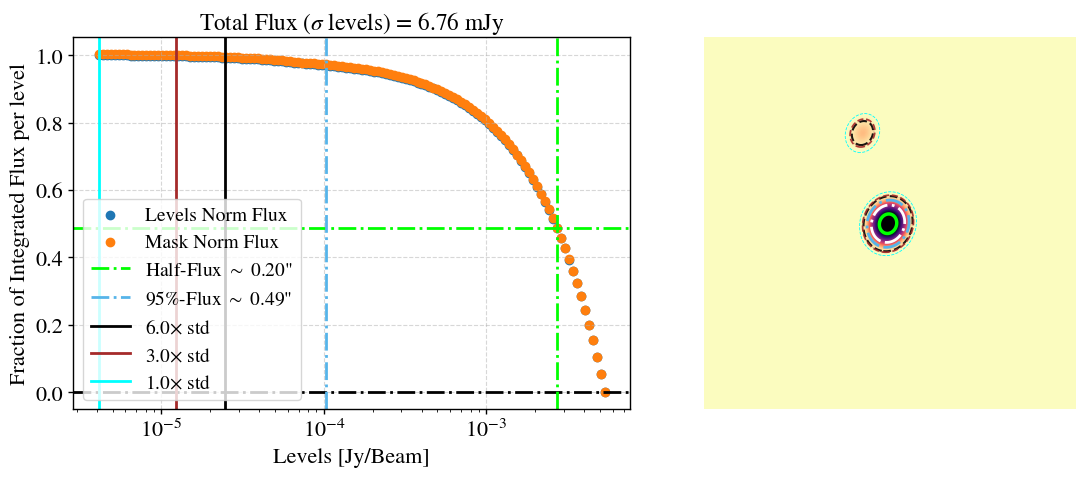

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:3590: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


D_a =  169.24419931373572 Mpc
Linear Distance =  6.564152262058192 pc
D_a =  169.24419931373572 Mpc
Linear Distance =  820.5190327572823 pc
5.999
Using rms provided...
Inner Perimeter (%50): 68.43450159294527
Outer Perimeter (%90): 136.6389653897629
Outer Perimeter (%99): 3882.140782240518
128 512 384
ctr=(  506.00   509.00)     I=    0.02     q=    0.86     PA=  179.98
ctr=(  506.50   509.50)     I=    0.02     q=    0.87     PA=    0.06
ctr=(  506.50   509.00)     I=    0.02     q=    0.94     PA=  179.84
ctr=(  506.50   509.00)     I=    0.02     q=    0.94     PA=  179.84
ctr=(  506.00   509.50)     I=    0.02     q=    0.94     PA=    0.00
ctr=(  506.50   509.50)     I=    0.02     q=    0.89     PA=  179.96
ctr=(  506.50   509.00)     I=    0.02     q=    0.94     PA=  179.99
ctr=(  506.01   509.50)     I=    0.02     q=    0.95     PA=    0.06
ctr=(  506.49   509.02)     I=    0.02     q=    0.95     PA=    0.23
ctr=(  506.06   509.46)     I=    0.02     q=    0.95     PA=   90.

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:277: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(gal), origin='lower')
/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:277: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(gal), origin='lower')


Initial PA and q =  105.90380675105591 0.35477056696009796
Median PA and q =  113.42692177407272 0.9039288150748099
Inner-Mean PA and q =  135.27068225611487 0.9390163829518551
Outer-Mean PA and q =  113.42692177407272 0.903809611938504
5.641895835477563 10.86705883733894 17.205469890442554 21.572414181094846
R50/R50_100 >>  0.07194105099864262
R50 >>  10.86705883733894
R50_100 >>  40.515726367051705
Gaussianity >>  0.5116007638256227
Sum of fluxes =  0.0067658278296594855


<Figure size 640x480 with 0 Axes>

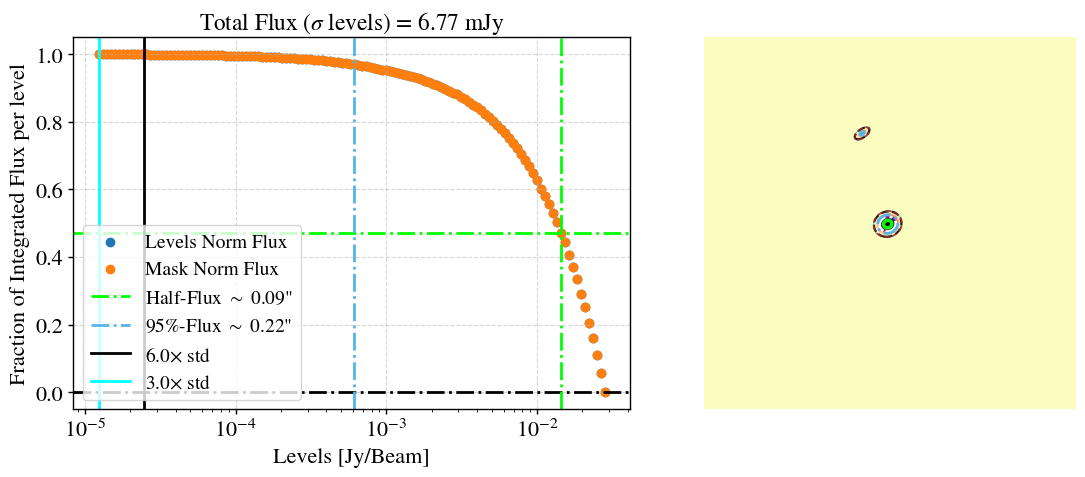

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:3590: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


D_a =  169.24419931373572 Mpc
Linear Distance =  6.564152262058192 pc
D_a =  169.24419931373572 Mpc
Linear Distance =  820.5190327572823 pc
5.999
Using rms provided...
Inner Perimeter (%50): 698.4427146245081
Outer Perimeter (%90): 1310.846845490185
Outer Perimeter (%99): 3882.140782240518
128 512 384
ctr=(  523.50   508.00)     I=    0.00     q=    0.89     PA=   89.02
ctr=(  523.51   508.01)     I=    0.00     q=    0.87     PA=   89.11
ctr=(  523.50   508.00)     I=    0.00     q=    0.87     PA=   89.24
ctr=(  523.53   507.53)     I=    0.00     q=    0.89     PA=   88.82
ctr=(  523.04   507.54)     I=    0.00     q=    0.88     PA=   88.85
ctr=(  523.00   508.00)     I=    0.00     q=    0.89     PA=   88.52
ctr=(  523.00   508.00)     I=    0.00     q=    0.89     PA=   88.55
ctr=(  522.52   508.02)     I=    0.00     q=    0.89     PA=   88.51
ctr=(  522.56   507.55)     I=    0.00     q=    0.90     PA=   87.98
ctr=(  522.55   507.54)     I=    0.00     q=    0.90     PA=   88.

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:12364: RuntimeWarning: divide by zero encountered in divide
  y0peak, x0peak = nd.maximum_position((image / rr2))


ctr=(  529.92   484.88)     I=    0.00     q=    0.63     PA=  104.18
ctr=(  529.03   484.68)     I=    0.00     q=    0.63     PA=  104.36
ctr=(  528.13   484.65)     I=    0.00     q=    0.62     PA=  103.99
ctr=(  527.19   484.88)     I=    0.00     q=    0.63     PA=  104.34
ctr=(  525.79   485.46)     I=    0.00     q=    0.63     PA=  104.51
ctr=(  524.00   486.33)     I=    0.00     q=    0.63     PA=  105.07
ctr=(  522.25   487.12)     I=    0.00     q=    0.63     PA=  105.64
ctr=(  519.88   488.58)     I=    0.00     q=    0.62     PA=  106.01
ctr=(  517.51   490.34)     I=    0.00     q=    0.62     PA=  106.54
ctr=(  514.68   492.59)     I=    0.00     q=    0.62     PA=  107.34
ctr=(  511.16   495.98)     I=    0.00     q=    0.61     PA=  108.42
ctr=(  507.11   500.20)     I=    0.00     q=    0.61     PA=  109.29
ctr=(  503.11   504.59)     I=    0.00     q=    0.60     PA=  109.44
ctr=(  497.30   510.63)     I=    0.00     q=    0.60     PA=  108.08
ctr=(  489.87   518.

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:168: RuntimeWarning: Mean of empty slice.
  remove_indexes = np.where(np.logical_or(abs(y - y.mean()) >
/home/sagauga/miniconda3/envs/morphen38/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:169: RuntimeWarning: Mean of empty slice.
  abs(y - y.mean()).mean() * 1.5, \
/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:170: RuntimeWarning: Mean of empty slice.
  abs(x - x.mean()) >
/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:171: RuntimeWarning: Mean of empty slice.
  abs(x - x.mean()).mean() * 1.5) == True)[0]
/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomp

Initial PA and q =  112.5473953022825 0.5385135924564612
Median PA and q =  91.4234196494271 0.5595542323827196
Inner-Mean PA and q =  88.81532717476493 0.8311468002497578
Outer-Mean PA and q =  91.88510734598046 0.5427478654415991
43.57428681098879 88.18880569056685 152.5107865143379 189.52991575402277
R50/R50_100 >>  0.16101884802952418
R50 >>  88.18880569056685
R50_100 >>  219.7733881286094
Gaussianity >>  0.26858804616480186
Sum of fluxes =  0.005638398126737772


<Figure size 640x480 with 0 Axes>

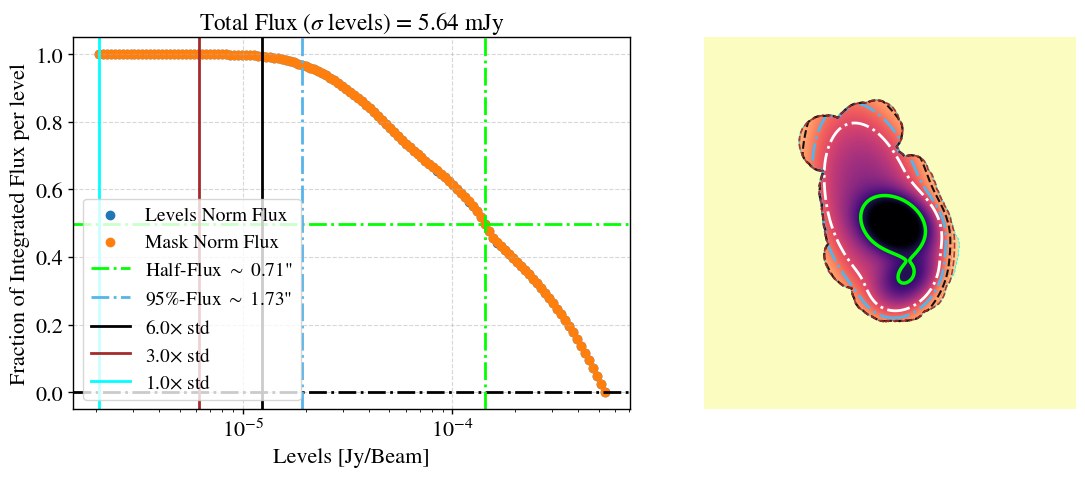

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:3590: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


D_a =  169.24419931373572 Mpc
Linear Distance =  6.564152262058192 pc
D_a =  169.24419931373572 Mpc
Linear Distance =  820.5190327572823 pc
5.999
Using rms provided...
Inner Perimeter (%50): 875.5412454108803
Outer Perimeter (%90): 9745.434747335745
Outer Perimeter (%99): 3882.140782240518
128 512 384
ctr=(  522.99   507.49)     I=    0.00     q=    0.80     PA=   87.91
ctr=(  522.99   507.49)     I=    0.00     q=    0.80     PA=   87.78
ctr=(  522.94   507.45)     I=    0.00     q=    0.81     PA=   87.33
ctr=(  522.99   507.49)     I=    0.00     q=    0.81     PA=   87.22
ctr=(  522.52   507.02)     I=    0.00     q=    0.82     PA=   87.66
ctr=(  522.51   507.51)     I=    0.00     q=    0.81     PA=   87.92
ctr=(  522.51   507.51)     I=    0.00     q=    0.81     PA=   87.67
ctr=(  522.49   507.49)     I=    0.00     q=    0.82     PA=   87.14
ctr=(  522.56   507.05)     I=    0.00     q=    0.81     PA=   87.42
ctr=(  522.46   507.47)     I=    0.00     q=    0.80     PA=   87.

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:12364: RuntimeWarning: divide by zero encountered in divide
  y0peak, x0peak = nd.maximum_position((image / rr2))


ctr=(  534.63   481.91)     I=    0.00     q=    0.60     PA=  105.93
ctr=(  534.84   480.85)     I=    0.00     q=    0.60     PA=   15.36
ctr=(  534.67   479.94)     I=    0.00     q=    0.59     PA=  104.35
ctr=(  534.87   478.88)     I=    0.00     q=    0.59     PA=  103.85
ctr=(  534.76   477.50)     I=    0.00     q=    0.59     PA=  102.79
ctr=(  534.27   477.13)     I=    0.00     q=    0.59     PA=   12.87
ctr=(  533.94   476.70)     I=    0.00     q=    0.59     PA=   12.26
ctr=(  533.41   476.43)     I=    0.00     q=    0.59     PA=   12.41
ctr=(  533.02   476.43)     I=    0.00     q=    0.59     PA=   12.00
ctr=(  532.33   476.61)     I=    0.00     q=    0.59     PA=   12.31
ctr=(  531.37   476.64)     I=    0.00     q=    0.59     PA=   12.23
ctr=(  530.14   477.48)     I=    0.00     q=    0.59     PA=   12.54
ctr=(  528.31   478.40)     I=    0.00     q=    0.59     PA=   13.16
ctr=(  526.51   479.72)     I=    0.00     q=    0.59     PA=   13.89
ctr=(  524.80   480.

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:277: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(gal), origin='lower')
/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:277: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(gal), origin='lower')


Initial PA and q =  112.7316141532676 0.524986038818939
Median PA and q =  90.75193500051316 0.5841619146749085
Inner-Mean PA and q =  87.374396058303 0.809101592690856
Outer-Mean PA and q =  91.81825653076184 0.5386709843274884
38.990357992890814 81.35879843748879 148.5598059993117 186.1013357454141
R50/R50_100 >>  0.13522388836144672
R50 >>  81.35879843748879
R50_100 >>  221.24721674433715
Gaussianity >>  0.23807884828551387
Sum of fluxes =  0.005661354235171448


<Figure size 640x480 with 0 Axes>

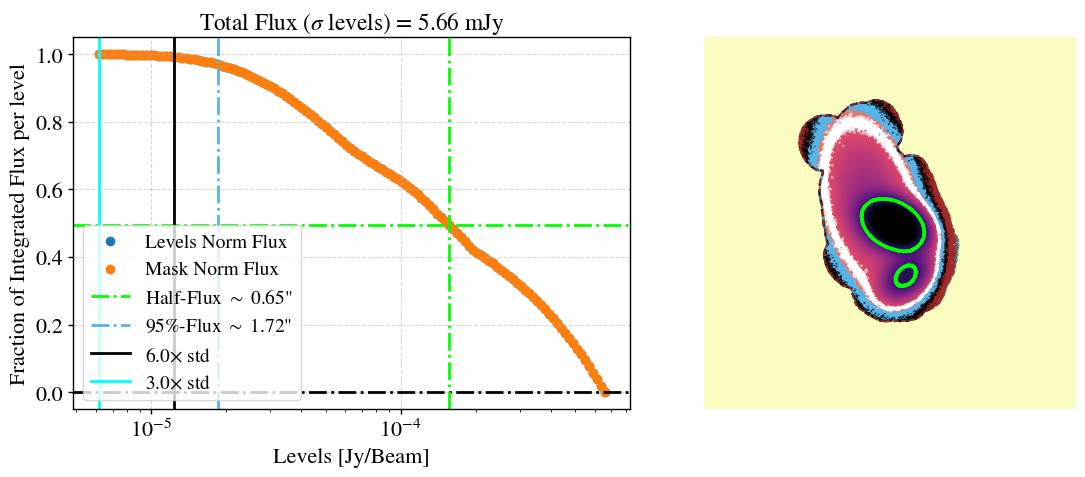

D_a =  169.24419931373572 Mpc
Linear Distance =  6.564152262058192 pc
D_a =  169.24419931373572 Mpc
Linear Distance =  820.5190327572823 pc


/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:3590: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


In [101]:
results_fit,lmfit_results, lmfit_results_1st_pass, errors_fit, models, \
    results_compact_conv_morpho,results_compact_deconv_morpho,results_ext_conv_morpho,results_ext_deconv_morpho = \
    run_image_fitting(imagelist = imagelist_vla[[-1]],aspect=None,
                      residuallist = residuallist_vla[[-1]],comp_ids=['1','3'],
                      sources_photometries = sources_photometries_new,
                      n_components = n_components_new,z=z_d['VV705'],
                      convolution_mode='GPU',
                      mask=mask,
                      save_name_append='_ls',
#                       save_name_append='_ls_n0G_cb',
                      #                       save_name_append='_ls_n10G0G',
                      fix_n = [True,True,True,True,True],
                      fix_value_n=[0.5,0.5,0.5,0.5,0.5],fix_geometry=True,
                      dr_fix=[5,5,5,50,50])

In [102]:
results_fit

f1_x0       f1_y0      f1_PA    f1_ell      f1_n     f1_In      f1_Rn  \
0  506.294278  509.287605  22.534169  0.100904  0.509998  0.014216  11.568966   

     f1_cg       f2_x0       f2_y0  ...  f5_cg       s_a  \
0 -0.00335  557.454126  364.962322  ...  -0.01  0.911999   

                                          #imagename  \
0  clean_image_VV705_combined_w_0.5_4096_0.008arc...   

                                        residualname  flux_data  \
0  clean_image_VV705_combined_w_0.5_4096_0.008arc...  12.434175   

   flux_density_ext  flux_density_ext2  flux_density_extended_model  \
0          5.932687           5.646679                     5.638399   

   flux_density_compact  flux_res  
0              6.777387  0.018389  

[1 rows x 49 columns]

In [103]:
lmfit_results[0]

Parameters([('f1_x0', <Parameter 'f1_x0', value=506.2942784931063 +/- 0.0019, bounds=[503.9665927981824:513.9665927981823]>), ('f1_y0', <Parameter 'f1_y0', value=509.28760477876847 +/- 0.00146, bounds=[505.22574656569464:515.2257465656946]>), ('f1_PA', <Parameter 'f1_PA', value=22.53416944180047 +/- 0.126, bounds=[-26.240034308468047:153.75996569153196]>), ('f1_ell', <Parameter 'f1_ell', value=0.10090422752382597 +/- 0.000347, bounds=[0.008409089131221426:0.5]>), ('f1_n', <Parameter 'f1_n', value=0.5099983904231218 +/- 0.0071, bounds=[0.49:0.51]>), ('f1_In', <Parameter 'f1_In', value=0.01421608117117086 +/- 0.000147, bounds=[0.0002561389085409852:0.1280694542704926]>), ('f1_Rn', <Parameter 'f1_Rn', value=11.568965530705434 +/- 0.344, bounds=[2.952110422084417:88.56331266253251]>), ('f1_cg', <Parameter 'f1_cg', value=-0.0033503118749961635 +/- 0.0197, bounds=[-0.01:0.01]>), ('f2_x0', <Parameter 'f2_x0', value=557.4541262253027 +/- 0.0513, bounds=[552.1395773578104:562.1395773578104]>), ('f2_y0', <Parameter 'f2_y0', value=364.96232164262045 +/- 0.0627, bounds=[354.96232264635734:364.96232264635734]>), ('f2_PA', <Parameter 'f2_PA', value=41.91909669101636 +/- 0.168, bounds=[-36.5945406244578:143.4054593755422]>), ('f2_ell', <Parameter 'f2_ell', value=0.30831645751097936 +/- 0.00138, bounds=[0.041851890658890306:0.5]>), ('f2_n', <Parameter 'f2_n', value=0.509999999901601 +/- 0.00525, bounds=[0.49:0.51]>), ('f2_In', <Parameter 'f2_In', value=8.266695354026977e-05 +/- 7.33e-07, bounds=[9.306839715731365e-06:0.004653419857865682]>), ('f2_Rn', <Parameter 'f2_Rn', value=51.52154480935317 +/- 1.92, bounds=[4.123824764952991:123.7147429485897]>), ('f2_cg', <Parameter 'f2_cg', value=-0.009999999900190888 +/- 0.0165, bounds=[-0.01:0.01]>), ('f3_x0', <Parameter 'f3_x0', value=435.8530067257461 +/- 0.0662, bounds=[427.8572317465938:437.8572317465938]>), ('f3_y0', <Parameter 'f3_y0', value=758.9587345297206 +/- 0.074, bounds=[753.2465258833081:763.2465258833081]>), ('f3_PA', <Parameter 'f3_PA', value=35.1079576086449 +/- 1.97, bounds=[-30.067470877681032:149.93252912231895]>), ('f3_ell', <Parameter 'f3_ell', value=0.4966485200910487 +/- 0.0364, bounds=[0.023683542659709622:0.5]>), ('f3_n', <Parameter 'f3_n', value=0.507154256464023 +/- 0.116, bounds=[0.49:0.51]>), ('f3_In', <Parameter 'f3_In', value=0.00045159455933496174 +/- 3.84e-05, bounds=[6.4941874349890655e-06:0.0032470937174945325]>), ('f3_Rn', <Parameter 'f3_Rn', value=9.677514377733804 +/- 1.16, bounds=[2.631066213242649:78.93198639727946]>), ('f3_cg', <Parameter 'f3_cg', value=-0.008898308888469405 +/- 0.0799, bounds=[-0.01:0.01]>), ('f4_x0', <Parameter 'f4_x0', value=525.3316732353431 +/- 0.0361, bounds=[458.9665927981824:558.9665927981823]>), ('f4_y0', <Parameter 'f4_y0', value=506.76055073108506 +/- 0.0189, bounds=[460.22574656569464:560.2257465656946]>), ('f4_PA', <Parameter 'f4_PA', value=153.75996567787692 +/- 0.0493, bounds=[-26.240034308468047:153.75996569153196]>), ('f4_ell', <Parameter 'f4_ell', value=0.3126543013409188 +/- 0.000432, bounds=[0.008409089131221426:0.5]>), ('f4_n', <Parameter 'f4_n', value=0.490000000099683 +/- 0.00157, bounds=[0.49:0.51]>), ('f4_In', <Parameter 'f4_In', value=0.0003144951672224362 +/- 8.5e-07, bounds=[1.2806945427049262e-05:0.00640347271352463]>), ('f4_Rn', <Parameter 'f4_Rn', value=55.81145367172368 +/- 0.554, bounds=[8.856331266253251:265.68993798759755]>), ('f4_cg', <Parameter 'f4_cg', value=-0.009999991479734604 +/- 0.00429, bounds=[-0.01:0.01]>), ('f5_x0', <Parameter 'f5_x0', value=458.96659284304826 +/- 0.126, bounds=[458.9665927981824:558.9665927981823]>), ('f5_y0', <Parameter 'f5_y0', value=560.2257465103328 +/- 0.221, bounds=[460.22574656569464:560.2257465656946]>), ('f5_PA', <Parameter 'f5_PA', value=105.17948747188854 +/- 0.0474, bounds=[-26.240034308468047:153.75996569153196]>), ('f5_ell', <Parameter 'f5_ell', value=0.4999999997284632 +/- 0.000576, bounds=[0.008409089131221426:0.5]>), ('f5_n', <Parameter 'f5_n', value=0.509999997

In [104]:
lmfit_results_1st_pass[0]

Parameters([('f1_x0', <Parameter 'f1_x0', value=506.29426232522655 +/- 0.0019, bounds=[503.9665927981824:513.9665927981823]>), ('f1_y0', <Parameter 'f1_y0', value=509.28757642417605 +/- 0.00146, bounds=[505.22574656569464:515.2257465656946]>), ('f1_PA', <Parameter 'f1_PA', value=22.575625926413974 +/- 0.126, bounds=[-26.240034308468047:153.75996569153196]>), ('f1_ell', <Parameter 'f1_ell', value=0.1009053734629624 +/- 0.000346, bounds=[0.008409089131221426:0.5]>), ('f1_n', <Parameter 'f1_n', value=0.5099983868823613 +/- 0.00709, bounds=[0.49:0.51]>), ('f1_In', <Parameter 'f1_In', value=0.014215940301662188 +/- 0.000147, bounds=[0.0002561389085409852:0.1280694542704926]>), ('f1_Rn', <Parameter 'f1_Rn', value=11.569029357236179 +/- 0.344, bounds=[2.952110422084417:88.56331266253251]>), ('f1_cg', <Parameter 'f1_cg', value=-0.0033489065000195137 +/- 0.0197, bounds=[-0.01:0.01]>), ('f2_x0', <Parameter 'f2_x0', value=557.4540049628428 +/- 0.0512, bounds=[552.1395773578104:562.1395773578104]>), ('f2_y0', <Parameter 'f2_y0', value=364.9623216269412 +/- 0.0627, bounds=[354.96232264635734:364.96232264635734]>), ('f2_PA', <Parameter 'f2_PA', value=41.957578644095875 +/- 0.168, bounds=[-36.5945406244578:143.4054593755422]>), ('f2_ell', <Parameter 'f2_ell', value=0.3083608706313636 +/- 0.00138, bounds=[0.041851890658890306:0.5]>), ('f2_n', <Parameter 'f2_n', value=0.5099999999843887 +/- 0.00527, bounds=[0.49:0.51]>), ('f2_In', <Parameter 'f2_In', value=8.266279665090387e-05 +/- 7.35e-07, bounds=[9.306839715731365e-06:0.004653419857865682]>), ('f2_Rn', <Parameter 'f2_Rn', value=51.524157054502716 +/- 1.91, bounds=[4.123824764952991:123.7147429485897]>), ('f2_cg', <Parameter 'f2_cg', value=-0.009999999999487679 +/- 0.0164, bounds=[-0.01:0.01]>), ('f3_x0', <Parameter 'f3_x0', value=435.8532018817251 +/- 0.0661, bounds=[427.8572317465938:437.8572317465938]>), ('f3_y0', <Parameter 'f3_y0', value=758.9589022323635 +/- 0.0741, bounds=[753.2465258833081:763.2465258833081]>), ('f3_PA', <Parameter 'f3_PA', value=35.85031102617554 +/- 1.94, bounds=[-30.067470877681032:149.93252912231895]>), ('f3_ell', <Parameter 'f3_ell', value=0.49664682801294896 +/- 0.0362, bounds=[0.023683542659709622:0.5]>), ('f3_n', <Parameter 'f3_n', value=0.5071766362457413 +/- 0.114, bounds=[0.49:0.51]>), ('f3_In', <Parameter 'f3_In', value=0.00045124805257159347 +/- 3.85e-05, bounds=[6.4941874349890655e-06:0.0032470937174945325]>), ('f3_Rn', <Parameter 'f3_Rn', value=9.680133229206435 +/- 1.14, bounds=[2.631066213242649:78.93198639727946]>), ('f3_cg', <Parameter 'f3_cg', value=-0.008903733041814752 +/- 0.0786, bounds=[-0.01:0.01]>), ('f4_x0', <Parameter 'f4_x0', value=525.3311493431004 +/- 0.0362, bounds=[458.9665927981824:558.9665927981823]>), ('f4_y0', <Parameter 'f4_y0', value=506.760820871794 +/- 0.019, bounds=[460.22574656569464:560.2257465656946]>), ('f4_PA', <Parameter 'f4_PA', value=153.7599656795876 +/- 0.0493, bounds=[-26.240034308468047:153.75996569153196]>), ('f4_ell', <Parameter 'f4_ell', value=0.31267129787068904 +/- 0.000432, bounds=[0.008409089131221426:0.5]>), ('f4_n', <Parameter 'f4_n', value=0.4900000000015603 +/- 0.00157, bounds=[0.49:0.51]>), ('f4_In', <Parameter 'f4_In', value=0.0003145034530007113 +/- 8.5e-07, bounds=[1.2806945427049262e-05:0.00640347271352463]>), ('f4_Rn', <Parameter 'f4_Rn', value=55.81110392255303 +/- 0.552, bounds=[8.856331266253251:265.68993798759755]>), ('f4_cg', <Parameter 'f4_cg', value=-0.009999991463669776 +/- 0.00427, bounds=[-0.01:0.01]>), ('f5_x0', <Parameter 'f5_x0', value=458.96659279818584 +/- 0.126, bounds=[458.9665927981824:558.9665927981823]>), ('f5_y0', <Parameter 'f5_y0', value=560.2257465607859 +/- 0.221, bounds=[460.22574656569464:560.2257465656946]>), ('f5_PA', <Parameter 'f5_PA', value=105.18042230137482 +/- 0.0474, bounds=[-26.240034308468047:153.75996569153196]>), ('f5_ell', <Parameter 'f5_ell', value=0.4999999997241825 +/- 0.000577, bounds=[0.008409089131221426:0.5]>), ('f5_n', <Parameter 'f5_n', value=0.509

## Third Attempt: Change the Sersic Index variation.

Next, I am going to set the Sersic Index of the large-scale structure to 1.0 instead of 0.5

Fitting clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..1.0-MFS-image.cutout_north.fits
rms res =  0.6380795802619506
rms data =  6.430414371954692 ; rms res =  4.103116103367264 ; ratio =  0.6380795802619506


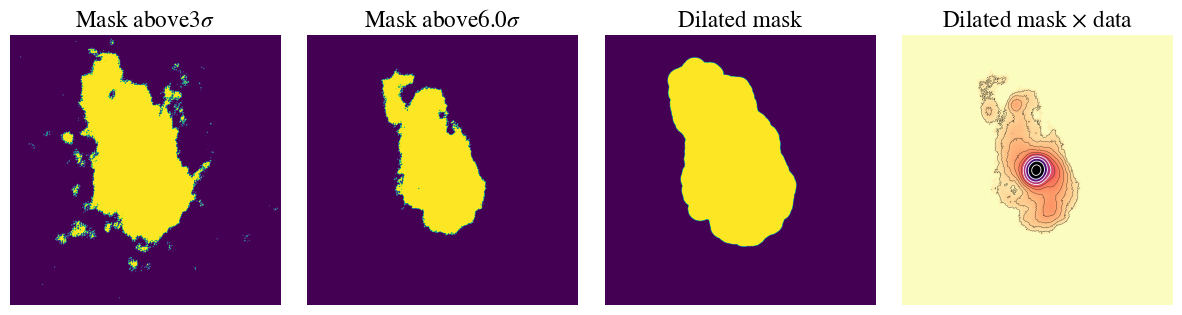

PSF SIZE is 1024
INFO: Using Elliptical Gaussian for Gaussian beam convolution.


2023-08-23 10:53:50	WARN	componentlist::close	componentlist closed


Using clean background for optmization...
---------------------------------------
<<< PERFORMING CONVOLUTION WITH GPU >>>
---------------------------------------
Limiting  x0
Limiting  y0
Fixing Sersic Index of component 0  to 0.5.
Limiting  x0
Limiting  y0
Fixing Sersic Index of component 1  to 0.5.
Limiting  x0
Limiting  y0
Fixing Sersic Index of component 2  to 0.5.
Limiting  x0
Limiting  y0
Fixing Sersic Index of component 3  to 0.5.
Limiting  x0
Limiting  y0
Fixing Sersic Index of component 4  to 0.5.
{'f1_x0': {'value': 508.9665927981824, 'min': 503.9665927981824, 'max': 513.9665927981823}, 'f1_y0': {'value': 510.22574656569464, 'min': 505.22574656569464, 'max': 515.2257465656946}, 'f1_PA': {'value': 63.75996569153195, 'min': -26.240034308468047, 'max': 153.75996569153196}, 'f1_ell': {'value': 0.04204544565610713, 'min': 0.008409089131221426, 'max': 0.5}, 'f1_n': {'value': 0.5, 'min': 0.49, 'max': 0.51}, 'f1_In': {'value': 0.0025613890854098522, 'min': 0.0002561389085409852, 'max

Flux on compact (self rms) =  6.92093665583922
Flux on compact (data rms) =  6.910435544989908
Flux on extended (self rms) =  5.445989427998258
Flux on extended (data rms) =  5.8149582261852535
Flux on extended2 (data rms) =  5.522765619644656
Flux on extended model (data rms) =  5.477229860148635
Flux on data =  12.434175022644247
Flux on residual =  0.046509617505703815


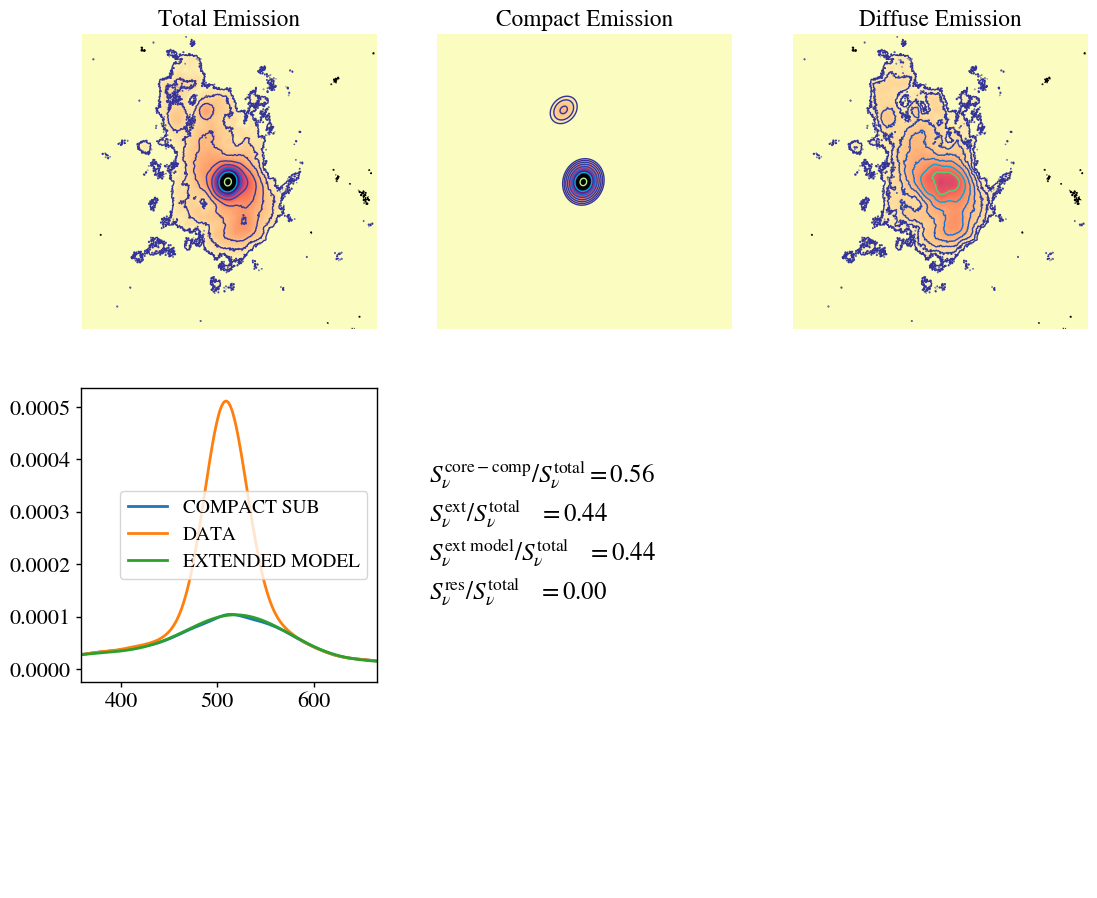

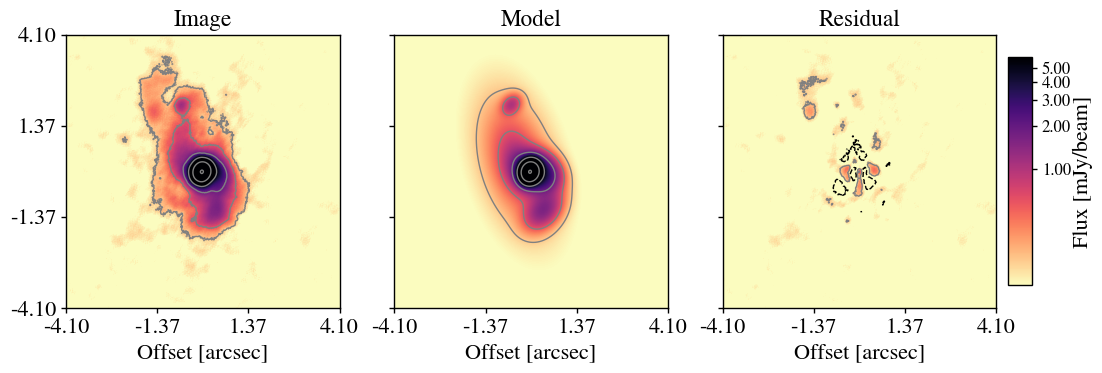

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:3590: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


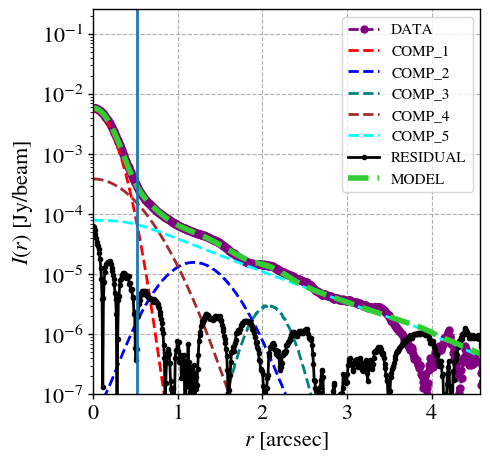

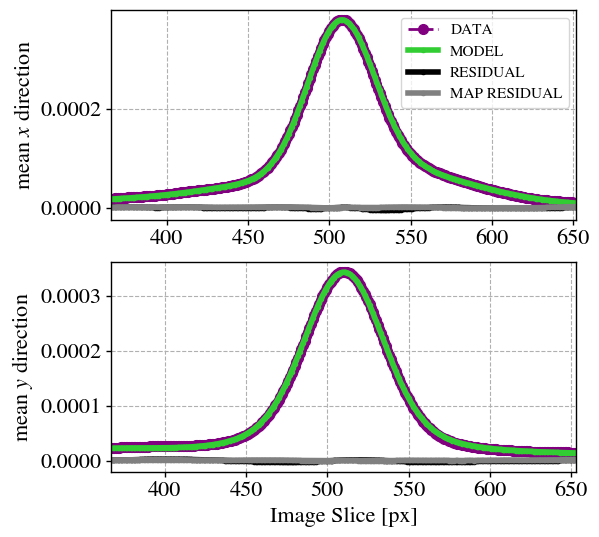

5.999
Using rms provided...
Inner Perimeter (%50): 160.6378659206601
Outer Perimeter (%90): 310.22434102484016
Outer Perimeter (%99): 3882.140782240518
128 512 384
ctr=(  507.00   510.50)     I=    0.00     q=    0.91     PA=   90.00
ctr=(  507.50   510.50)     I=    0.00     q=    0.89     PA=   90.00
ctr=(  507.00   510.50)     I=    0.00     q=    0.87     PA=   90.00
ctr=(  507.50   510.00)     I=    0.00     q=    0.87     PA=   90.00
ctr=(  507.50   510.50)     I=    0.00     q=    0.90     PA=   90.00
ctr=(  507.00   510.00)     I=    0.00     q=    0.90     PA=   90.00
ctr=(  507.50   510.50)     I=    0.00     q=    0.90     PA=   90.00
ctr=(  507.00   510.50)     I=    0.00     q=    0.89     PA=   90.00
ctr=(  507.01   510.49)     I=    0.00     q=    0.89     PA=   89.93
ctr=(  507.03   510.03)     I=    0.00     q=    0.88     PA=  179.70
ctr=(  507.03   510.06)     I=    0.00     q=    0.88     PA=  179.45
ctr=(  507.39   510.13)     I=    0.00     q=    0.90     PA=  176

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:277: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(gal), origin='lower')


Initial PA and q =  102.27714648184863 0.5243894348674657
Median PA and q =  100.28084594943249 0.866096953388741
Inner-Mean PA and q =  89.99979786839705 0.888658217788803
Outer-Mean PA and q =  102.07845806725592 0.8581634921779648
14.679774962390475 25.451141789397465 39.56574301402518 49.28834599938094
R50/R50_100 >>  0.06685502151844673
R50 >>  25.451141789397465
R50_100 >>  98.43289402201079
Gaussianity >>  0.5072940335511089
Sum of fluxes =  0.006898384864621106


<Figure size 640x480 with 0 Axes>

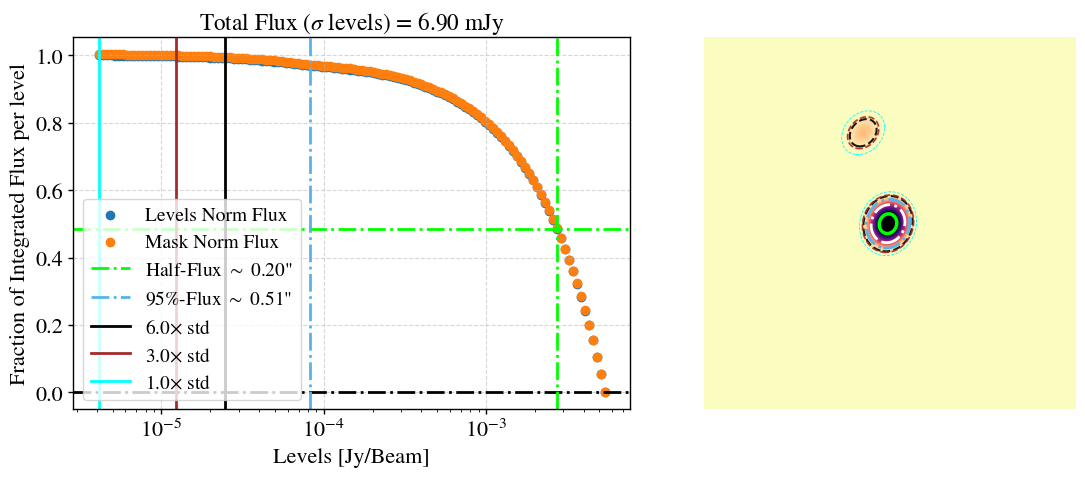

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:3590: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


D_a =  169.24419931373572 Mpc
Linear Distance =  6.564152262058192 pc
D_a =  169.24419931373572 Mpc
Linear Distance =  820.5190327572823 pc
5.999
Using rms provided...
Inner Perimeter (%50): 72.78209975608914
Outer Perimeter (%90): 139.87584281836718
Outer Perimeter (%99): 3882.140782240518
128 512 384
ctr=(  506.00   509.50)     I=    0.02     q=    0.93     PA=  179.91
ctr=(  506.00   509.50)     I=    0.02     q=    0.93     PA=  179.91
ctr=(  506.50   509.00)     I=    0.02     q=    0.94     PA=  179.84
ctr=(  506.00   509.50)     I=    0.02     q=    0.94     PA=    0.00
ctr=(  506.00   509.50)     I=    0.02     q=    0.94     PA=    0.00
ctr=(  506.50   509.00)     I=    0.02     q=    0.94     PA=  179.99
ctr=(  506.50   509.00)     I=    0.02     q=    0.94     PA=  179.99
ctr=(  506.01   509.50)     I=    0.02     q=    0.95     PA=    0.06
ctr=(  506.48   509.03)     I=    0.02     q=    0.95     PA=    0.05
ctr=(  506.06   509.47)     I=    0.02     q=    0.95     PA=   90

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:277: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(gal), origin='lower')
/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:277: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(gal), origin='lower')


Initial PA and q =  105.14033655728979 0.2987167028206935
Median PA and q =  102.92439972056182 0.9155288727994353
Inner-Mean PA and q =  95.5865180322894 0.9445194249436574
Outer-Mean PA and q =  102.92887344349099 0.9114920285013677
5.641895835477563 11.562445770562215 17.841241161527712 22.262266119785785
R50/R50_100 >>  0.05401234567901234
R50 >>  11.562445770562215
R50_100 >>  49.75115752387231
Gaussianity >>  0.4824958651593852
Sum of fluxes =  0.006900269758973157


<Figure size 640x480 with 0 Axes>

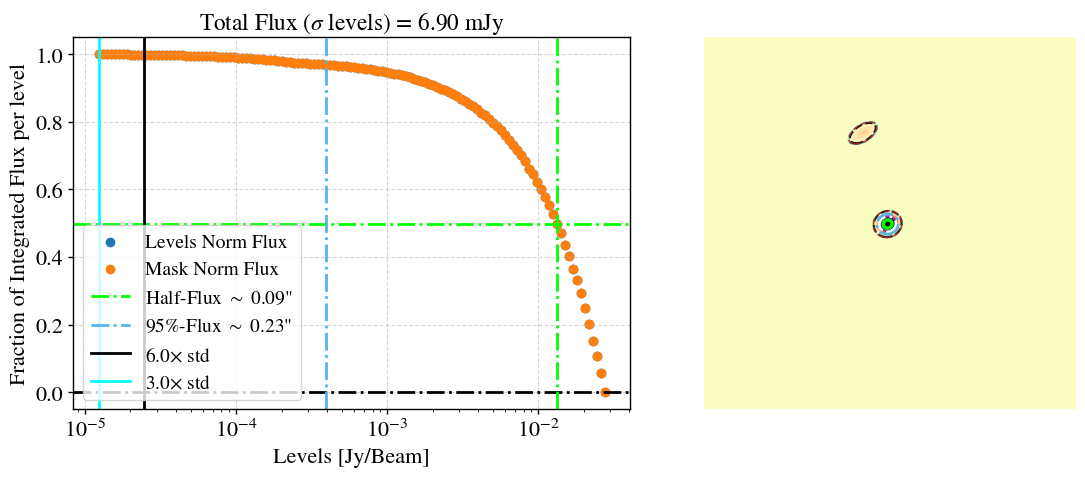

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:3590: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


D_a =  169.24419931373572 Mpc
Linear Distance =  6.564152262058192 pc
D_a =  169.24419931373572 Mpc
Linear Distance =  820.5190327572823 pc
5.999
Using rms provided...
Inner Perimeter (%50): 708.5739542564775
Outer Perimeter (%90): 1276.8119901023324
Outer Perimeter (%99): 3882.140782240518
128 512 384
ctr=(  526.01   507.01)     I=    0.00     q=    0.88     PA=  179.85
ctr=(  525.51   507.51)     I=    0.00     q=    0.88     PA=  179.85
ctr=(  525.04   507.53)     I=    0.00     q=    0.87     PA=   89.63
ctr=(  525.01   507.51)     I=    0.00     q=    0.88     PA=  179.87
ctr=(  524.56   507.05)     I=    0.00     q=    0.88     PA=   89.43
ctr=(  524.52   507.52)     I=    0.00     q=    0.89     PA=   89.49
ctr=(  524.05   507.55)     I=    0.00     q=    0.89     PA=   89.23
ctr=(  523.55   507.54)     I=    0.00     q=    0.88     PA=   89.31
ctr=(  523.59   507.08)     I=    0.00     q=    0.89     PA=   88.89
ctr=(  523.56   507.05)     I=    0.00     q=    0.89     PA=   89

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:12364: RuntimeWarning: divide by zero encountered in divide
  y0peak, x0peak = nd.maximum_position((image / rr2))


ctr=(  521.19   488.60)     I=    0.00     q=    0.63     PA=  106.91
ctr=(  519.75   489.09)     I=    0.00     q=    0.63     PA=  107.08
ctr=(  518.25   489.73)     I=    0.00     q=    0.63     PA=  107.32
ctr=(  516.42   490.32)     I=    0.00     q=    0.63     PA=  107.25
ctr=(  514.93   490.97)     I=    0.00     q=    0.62     PA=  107.44
ctr=(  513.17   491.73)     I=    0.00     q=    0.62     PA=  107.91
ctr=(  510.87   493.61)     I=    0.00     q=    0.62     PA=  108.52
ctr=(  508.25   495.93)     I=    0.00     q=    0.62     PA=  109.07
ctr=(  505.61   498.07)     I=    0.00     q=    0.62     PA=  109.89
ctr=(  502.36   501.03)     I=    0.00     q=    0.62     PA=  109.75
ctr=(  497.84   504.86)     I=    0.00     q=    0.62     PA=  108.50
ctr=(  492.94   509.48)     I=    0.00     q=    0.61     PA=  106.34
ctr=(  487.76   514.12)     I=    0.00     q=    0.61     PA=  104.42
ctr=(  482.87   518.87)     I=    0.00     q=    0.60     PA=  102.16
ctr=(  479.27   522.

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:168: RuntimeWarning: Mean of empty slice.
  remove_indexes = np.where(np.logical_or(abs(y - y.mean()) >
/home/sagauga/miniconda3/envs/morphen38/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:169: RuntimeWarning: Mean of empty slice.
  abs(y - y.mean()).mean() * 1.5, \
/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:170: RuntimeWarning: Mean of empty slice.
  abs(x - x.mean()) >
/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:171: RuntimeWarning: Mean of empty slice.
  abs(x - x.mean()).mean() * 1.5) == True)[0]
/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomp

Initial PA and q =  112.92837863528058 0.5511387968796351
Median PA and q =  94.88431349188541 0.5787786467167934
Inner-Mean PA and q =  89.55880787065374 0.8227282447572959
Outer-Mean PA and q =  94.9477493781566 0.5543694420651961
43.53774652212117 87.78180748160295 150.81284629426162 186.9392614579929
R50/R50_100 >>  0.15929983877866616
R50 >>  87.78180748160295
R50_100 >>  219.936267709352
Gaussianity >>  0.284144184100442
Sum of fluxes =  0.005477230456664204


<Figure size 640x480 with 0 Axes>

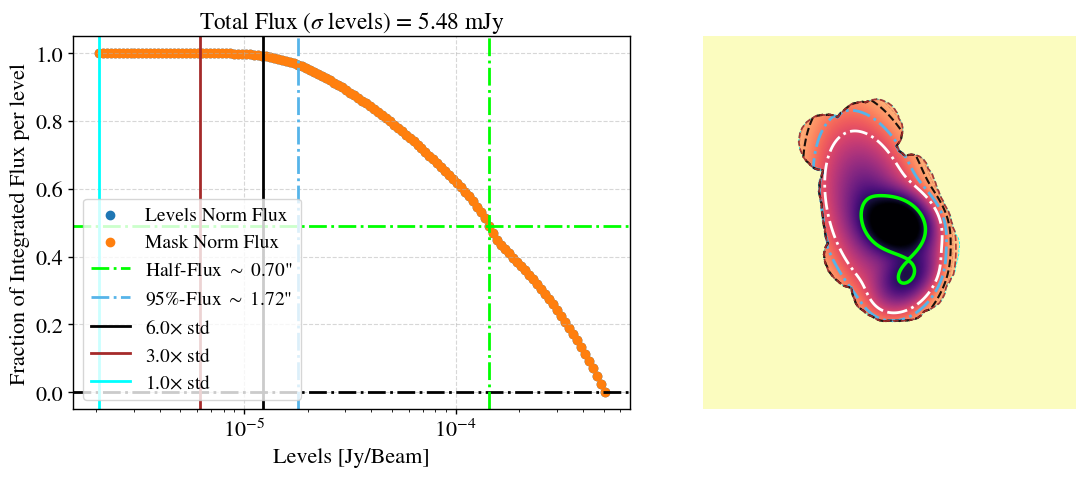

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:3590: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


D_a =  169.24419931373572 Mpc
Linear Distance =  6.564152262058192 pc
D_a =  169.24419931373572 Mpc
Linear Distance =  820.5190327572823 pc
5.999
Using rms provided...
Inner Perimeter (%50): 680.3785568663667
Outer Perimeter (%90): 1672.8815404140864
Outer Perimeter (%99): 3882.140782240518
128 512 384
ctr=(  526.04   506.54)     I=    0.00     q=    0.80     PA=   89.46
ctr=(  526.06   506.54)     I=    0.00     q=    0.81     PA=   89.18
ctr=(  525.59   506.57)     I=    0.00     q=    0.80     PA=   88.83
ctr=(  525.10   506.58)     I=    0.00     q=    0.81     PA=   88.87
ctr=(  524.59   507.07)     I=    0.00     q=    0.80     PA=   88.94
ctr=(  524.56   507.05)     I=    0.00     q=    0.80     PA=   88.81
ctr=(  524.57   507.06)     I=    0.00     q=    0.81     PA=   88.61
ctr=(  524.02   507.52)     I=    0.00     q=    0.81     PA=   88.91
ctr=(  523.58   507.56)     I=    0.00     q=    0.80     PA=   88.42
ctr=(  523.61   507.09)     I=    0.00     q=    0.80     PA=   88

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:12364: RuntimeWarning: divide by zero encountered in divide
  y0peak, x0peak = nd.maximum_position((image / rr2))


ctr=(  528.47   483.71)     I=    0.00     q=    0.61     PA=  107.18
ctr=(  527.52   483.72)     I=    0.00     q=    0.61     PA=  107.01
ctr=(  526.54   483.73)     I=    0.00     q=    0.60     PA=  106.89
ctr=(  525.55   484.14)     I=    0.00     q=    0.61     PA=  107.00
ctr=(  524.91   484.14)     I=    0.00     q=    0.61     PA=  107.20
ctr=(  523.46   484.46)     I=    0.00     q=    0.60     PA=  107.46
ctr=(  522.37   485.00)     I=    0.00     q=    0.60     PA=  107.60
ctr=(  520.46   485.46)     I=    0.00     q=    0.60     PA=  107.61
ctr=(  519.33   485.93)     I=    0.00     q=    0.60     PA=  107.74
ctr=(  517.79   486.78)     I=    0.00     q=    0.60     PA=  108.20
ctr=(  515.77   488.40)     I=    0.00     q=    0.60     PA=  108.59
ctr=(  513.30   490.40)     I=    0.00     q=    0.61     PA=  109.28
ctr=(  511.51   491.74)     I=    0.00     q=    0.61     PA=  109.64
ctr=(  509.31   493.55)     I=    0.00     q=    0.62     PA=  109.81
ctr=(  506.95   495.

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:277: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(gal), origin='lower')


Initial PA and q =  113.16361512698462 0.537452783915386
Median PA and q =  95.98094465922227 0.5657380546830814
Inner-Mean PA and q =  88.86872917640773 0.7998609462564817
Outer-Mean PA and q =  96.97037431461949 0.5420903204929527
40.60205537341493 81.86583324928485 146.67735645721268 183.91715081853215
R50/R50_100 >>  0.1358860506240884
R50 >>  81.86583324928485
R50_100 >>  222.0829656336425
Gaussianity >>  0.2516151560392012
Sum of fluxes =  0.005497708627280335


<Figure size 640x480 with 0 Axes>

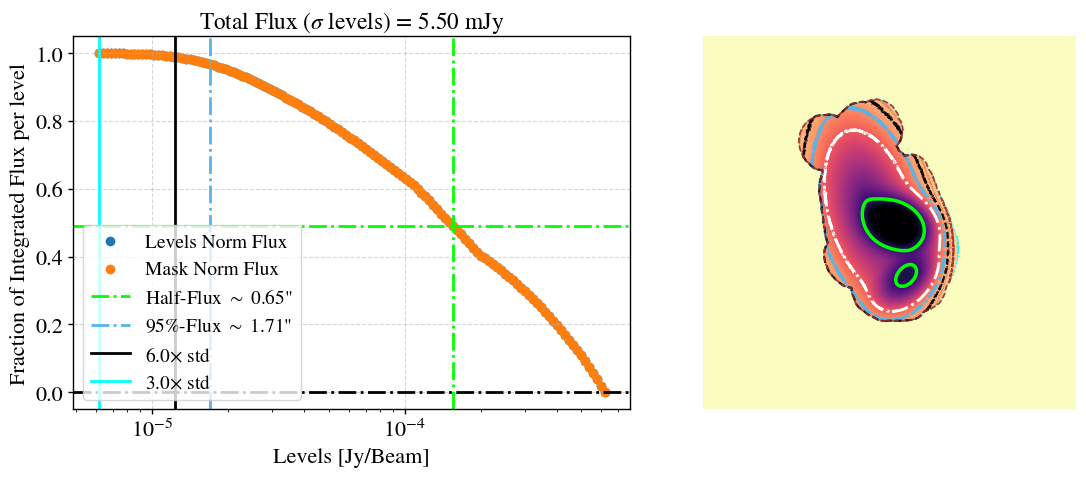

D_a =  169.24419931373572 Mpc
Linear Distance =  6.564152262058192 pc
D_a =  169.24419931373572 Mpc
Linear Distance =  820.5190327572823 pc


/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:3590: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


In [100]:
results_fit,lmfit_results, lmfit_results_1st_pass, errors_fit, models, \
    results_compact_conv_morpho,results_compact_deconv_morpho,results_ext_conv_morpho,results_ext_deconv_morpho = \
    run_image_fitting(imagelist = imagelist_vla[[-1]],aspect=None,
                      residuallist = residuallist_vla[[-1]],comp_ids=['1','3'],
                      sources_photometries = sources_photometries_new,
                      n_components = n_components_new,z=z_d['VV705'],
                      convolution_mode='GPU',
                      mask=mask,
                      save_name_append='_ls',
                      fix_n = [True,True,True,True,True],
                      fix_value_n=[0.5,0.5,0.5,0.5,1.0],fix_geometry=True,
                      dr_fix=[5,5,5,50,50])

We can also keep free the Sersic Index of the brighter component (`ID1`).

Fitting clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..1.0-MFS-image.cutout_north.fits
rms res =  0.6380795802619506
rms data =  6.430414371954692 ; rms res =  4.103116103367264 ; ratio =  0.6380795802619506


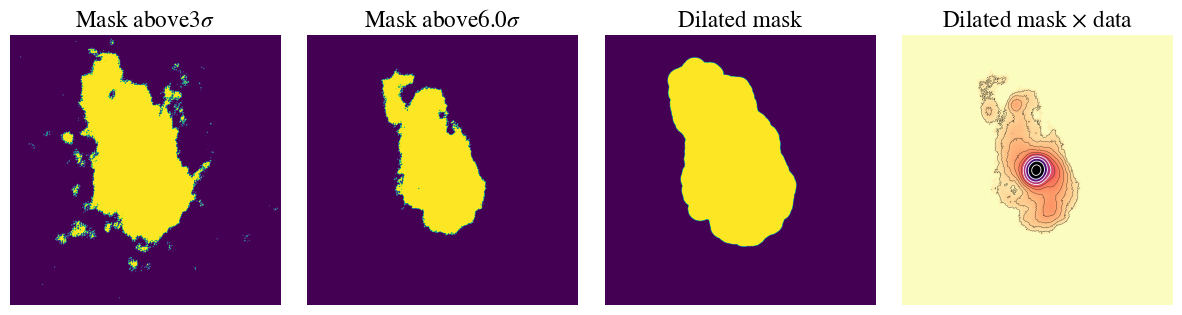

PSF SIZE is 1024
INFO: Using Elliptical Gaussian for Gaussian beam convolution.


2023-08-23 10:58:42	WARN	componentlist::close	componentlist closed


Using clean background for optmization...
---------------------------------------
<<< PERFORMING CONVOLUTION WITH GPU >>>
---------------------------------------
Limiting  x0
Limiting  y0
Limiting  x0
Limiting  y0
Fixing Sersic Index of component 1  to 0.5.
Limiting  x0
Limiting  y0
Fixing Sersic Index of component 2  to 0.5.
Limiting  x0
Limiting  y0
Fixing Sersic Index of component 3  to 0.5.
Limiting  x0
Limiting  y0
Fixing Sersic Index of component 4  to 0.5.
{'f1_x0': {'value': 508.9665927981824, 'min': 503.9665927981824, 'max': 513.9665927981823}, 'f1_y0': {'value': 510.22574656569464, 'min': 505.22574656569464, 'max': 515.2257465656946}, 'f1_PA': {'value': 63.75996569153195, 'min': -26.240034308468047, 'max': 153.75996569153196}, 'f1_ell': {'value': 0.04204544565610713, 'min': 0.008409089131221426, 'max': 0.5}, 'f1_n': {'value': 0.5, 'min': 0.3, 'max': 8.0}, 'f1_In': {'value': 0.0025613890854098522, 'min': 0.0002561389085409852, 'max': 0.1280694542704926}, 'f1_Rn': {'value': 29.

Flux on compact (self rms) =  7.993067282575626
Flux on compact (data rms) =  7.981337709710736
Flux on extended (self rms) =  4.374135044653246
Flux on extended (data rms) =  4.74334281093082
Flux on extended2 (data rms) =  4.450820244618636
Flux on extended model (data rms) =  4.416442512557375
Flux on data =  12.434175022644247
Flux on residual =  0.036394800376136516


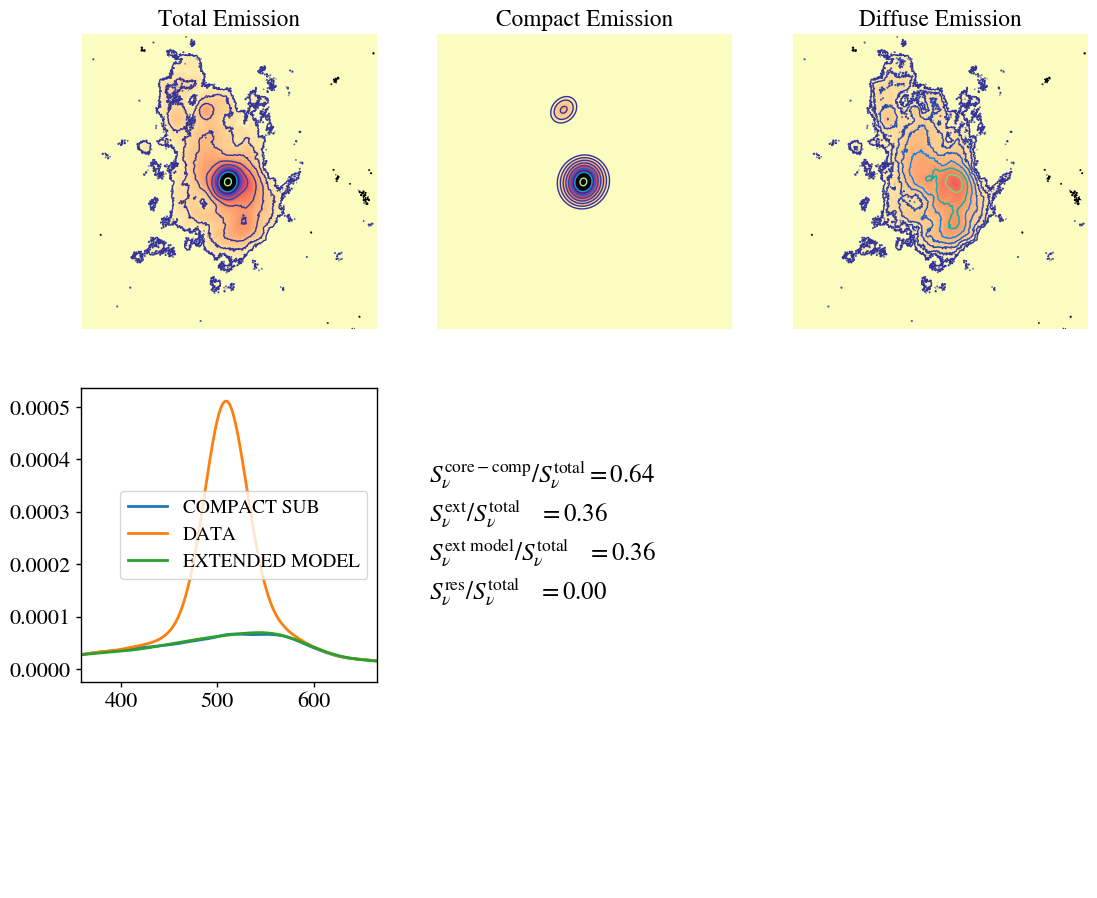

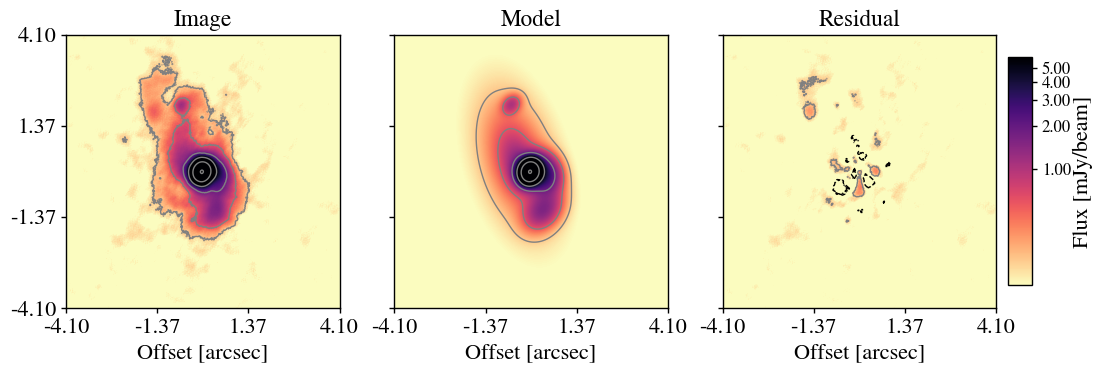

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:3590: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


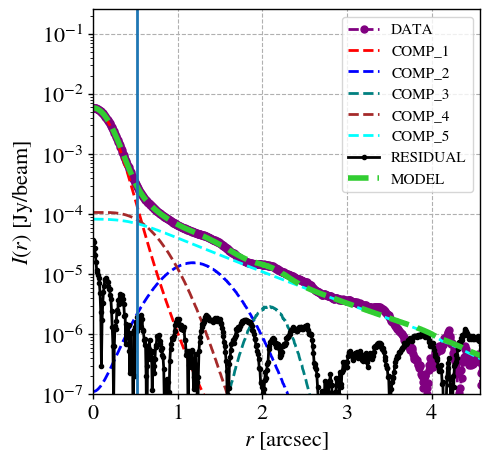

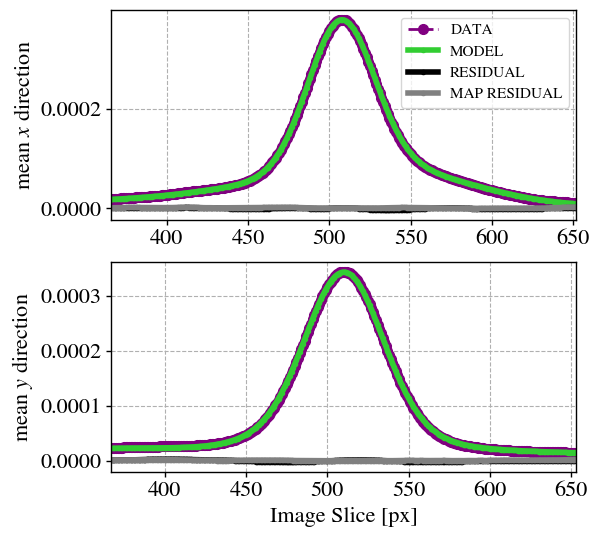

5.999
Using rms provided...
Inner Perimeter (%50): 170.57853600260063
Outer Perimeter (%90): 348.1861872296796
Outer Perimeter (%99): 3882.140782240518
128 512 384
ctr=(  507.50   510.50)     I=    0.00     q=    0.89     PA=   90.00
ctr=(  507.00   510.00)     I=    0.00     q=    0.89     PA=   90.00
ctr=(  507.50   510.50)     I=    0.00     q=    0.89     PA=   90.00
ctr=(  507.00   510.50)     I=    0.00     q=    0.87     PA=   90.00
ctr=(  507.50   510.00)     I=    0.00     q=    0.88     PA=   90.00
ctr=(  507.50   510.50)     I=    0.00     q=    0.90     PA=   90.00
ctr=(  507.50   510.50)     I=    0.00     q=    0.86     PA=   90.00
ctr=(  507.50   510.50)     I=    0.00     q=    0.91     PA=   90.00
ctr=(  507.48   510.49)     I=    0.00     q=    0.87     PA=   89.93
ctr=(  507.47   510.48)     I=    0.00     q=    0.88     PA=  179.72
ctr=(  507.09   510.46)     I=    0.00     q=    0.90     PA=  178.95
ctr=(  507.07   510.07)     I=    0.00     q=    0.89     PA=  177

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:277: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(gal), origin='lower')


Initial PA and q =  101.81235393294067 0.6098601554172233
Median PA and q =  161.78090275283137 0.8849200563829862
Inner-Mean PA and q =  90.0001319261984 0.8894919657500642
Outer-Mean PA and q =  162.09819336271113 0.8846357925491746
14.93771167933152 27.028155482603687 43.21485973875537 55.27906391541368
R50/R50_100 >>  0.053115163858544714
R50 >>  27.028155482603687
R50_100 >>  117.27546018766769
Gaussianity >>  0.4767304893795405
Sum of fluxes =  0.00795792180843085


<Figure size 640x480 with 0 Axes>

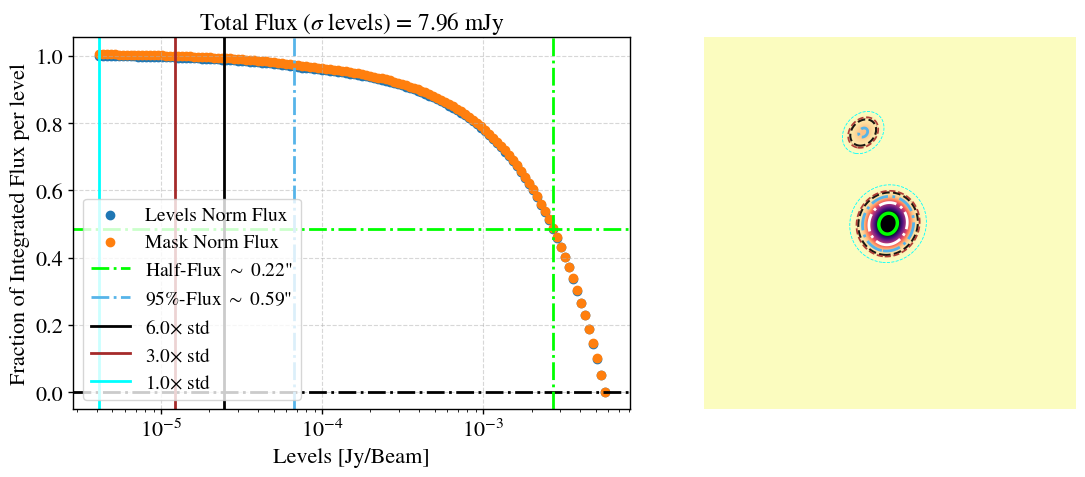

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:3590: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


D_a =  169.24419931373572 Mpc
Linear Distance =  6.564152262058192 pc
D_a =  169.24419931373572 Mpc
Linear Distance =  820.5190327572823 pc
5.999
Using rms provided...
Inner Perimeter (%50): 70.33062049088231
Outer Perimeter (%90): 221.02781632960193
Outer Perimeter (%99): 3882.140782240518
128 512 384
ctr=(  506.50   509.00)     I=    0.08     q=    0.47     PA=   14.20
ctr=(  506.50   509.50)     I=    0.08     q=    0.75     PA=   56.55
ctr=(  506.50   509.50)     I=    0.08     q=    0.75     PA=   56.55
non real ellipse
ctr=(  506.00   509.00)     I=    0.07     q=    0.63     PA=    5.71
ctr=(  506.49   509.48)     I=    0.06     q=    0.77     PA=   64.40
ctr=(  506.49   509.48)     I=    0.06     q=    0.77     PA=   64.40
ctr=(  506.50   509.50)     I=    0.06     q=    0.80     PA=  167.09
ctr=(  506.04   509.50)     I=    0.06     q=    0.93     PA=  136.34
ctr=(  506.04   509.04)     I=    0.05     q=    0.97     PA=  128.26
ctr=(  506.47   509.47)     I=    0.05     q=    

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:262: RuntimeWarning: invalid value encountered in divide
  qmedian = np.nanmedian(BB / AA)
/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:264: RuntimeWarning: invalid value encountered in divide
  qmi = np.nanmedian((BB / AA)[:rsplit])
/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:265: RuntimeWarning: invalid value encountered in divide
  qmo = np.nanmedian((BB / AA)[rsplit:])
/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:277: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(gal), origin='lower')
/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:277: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(gal), origin='lower')


Initial PA and q =  105.34194577003119 0.4548874559729912
Median PA and q =  102.50401558658837 0.9507176185827819
Inner-Mean PA and q =  90.67200752892005 0.9301275587936914
Outer-Mean PA and q =  105.46860543974994 0.9552592064157267
4.652426491681278 11.255546841497692 23.43934434990072 35.088782249586586
R50/R50_100 >>  0.018447276940903826
R50 >>  11.255546841497692
R50_100 >>  82.87059668190693
Gaussianity >>  0.08628658547584264
Sum of fluxes =  0.007935495007873123


<Figure size 640x480 with 0 Axes>

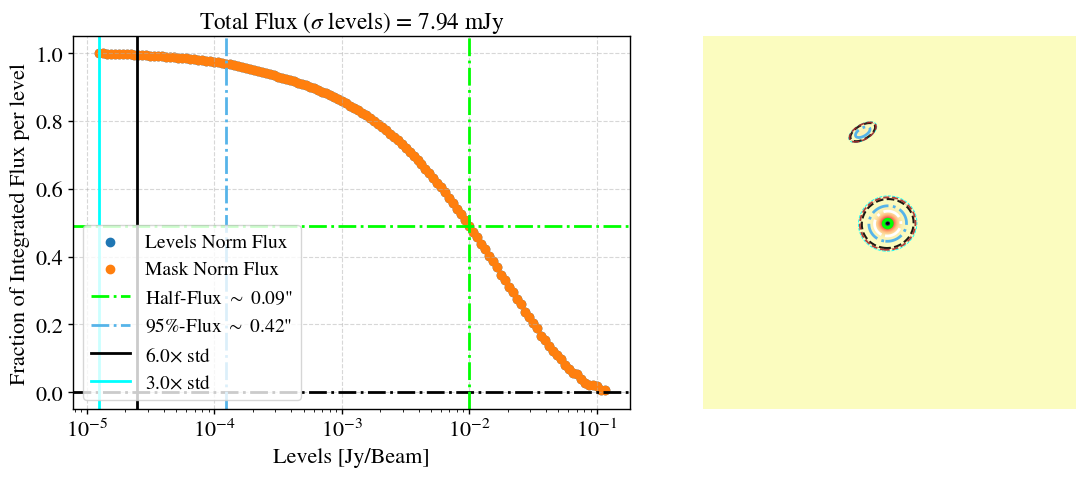

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:3590: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


D_a =  169.24419931373572 Mpc
Linear Distance =  6.564152262058192 pc
D_a =  169.24419931373572 Mpc
Linear Distance =  820.5190327572823 pc
5.999
Using rms provided...
Inner Perimeter (%50): 778.2702778878927
Outer Perimeter (%90): 1337.7573008785441
Outer Perimeter (%99): 3882.140782240518
128 512 384
ctr=(  551.93   494.53)     I=    0.00     q=    0.80     PA=    3.25
ctr=(  553.00   489.62)     I=    0.00     q=    0.66     PA=    5.90
ctr=(  553.13   486.14)     I=    0.00     q=    0.58     PA=    6.43
ctr=(  552.24   484.13)     I=    0.00     q=    0.55     PA=    7.25
ctr=(  550.27   483.75)     I=    0.00     q=    0.56     PA=    9.32
ctr=(  548.96   483.31)     I=    0.00     q=    0.57     PA=  100.38
ctr=(  547.35   483.61)     I=    0.00     q=    0.58     PA=  101.02
ctr=(  545.22   483.96)     I=    0.00     q=    0.58     PA=  101.48
ctr=(  543.91   483.93)     I=    0.00     q=    0.59     PA=  101.89
ctr=(  542.12   484.05)     I=    0.00     q=    0.59     PA=  102

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:12364: RuntimeWarning: divide by zero encountered in divide
  y0peak, x0peak = nd.maximum_position((image / rr2))


ctr=(  508.40   496.79)     I=    0.00     q=    0.61     PA=  105.26
ctr=(  504.03   500.56)     I=    0.00     q=    0.61     PA=  104.39
ctr=(  497.85   506.55)     I=    0.00     q=    0.60     PA=  102.18
ctr=(  491.36   512.76)     I=    0.00     q=    0.60     PA=   98.93
ctr=(  487.42   516.79)     I=    0.00     q=    0.59     PA=   97.37
ctr=(  484.05   520.09)     I=    0.00     q=    0.59     PA=   96.81
ctr=(  481.46   522.84)     I=    0.00     q=    0.58     PA=   96.50
ctr=(  478.95   525.60)     I=    0.00     q=    0.58     PA=   96.52
ctr=(  476.50   528.49)     I=    0.00     q=    0.57     PA=   96.25
ctr=(  474.30   530.77)     I=    0.00     q=    0.57     PA=   95.97
ctr=(  471.68   533.75)     I=    0.00     q=    0.57     PA=   95.93
ctr=(  469.81   536.24)     I=    0.00     q=    0.57     PA=   95.76
ctr=(  467.75   538.72)     I=    0.00     q=    0.56     PA=   95.47
ctr=(  466.00   541.12)     I=    0.00     q=    0.56     PA=   95.33
ctr=(  463.95   543.

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:168: RuntimeWarning: Mean of empty slice.
  remove_indexes = np.where(np.logical_or(abs(y - y.mean()) >
/home/sagauga/miniconda3/envs/morphen38/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:169: RuntimeWarning: Mean of empty slice.
  abs(y - y.mean()).mean() * 1.5, \
/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:170: RuntimeWarning: Mean of empty slice.
  abs(x - x.mean()) >
/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:171: RuntimeWarning: Mean of empty slice.
  abs(x - x.mean()).mean() * 1.5) == True)[0]
/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomp

Initial PA and q =  112.92981440380048 0.5309887635024612
Median PA and q =  95.38121803707634 0.5568425481039354
Inner-Mean PA and q =  102.98350846050948 0.6105249201703493
Outer-Mean PA and q =  94.63214317157176 0.5408887646649577
52.931688223499215 102.85131232777691 161.4992066977842 195.0978674408603
R50/R50_100 >>  0.2324961522317056
R50 >>  102.85131232777691
R50_100 >>  213.30545030802904
Gaussianity >>  0.317303376846834
Sum of fluxes =  0.004416441481742044


<Figure size 640x480 with 0 Axes>

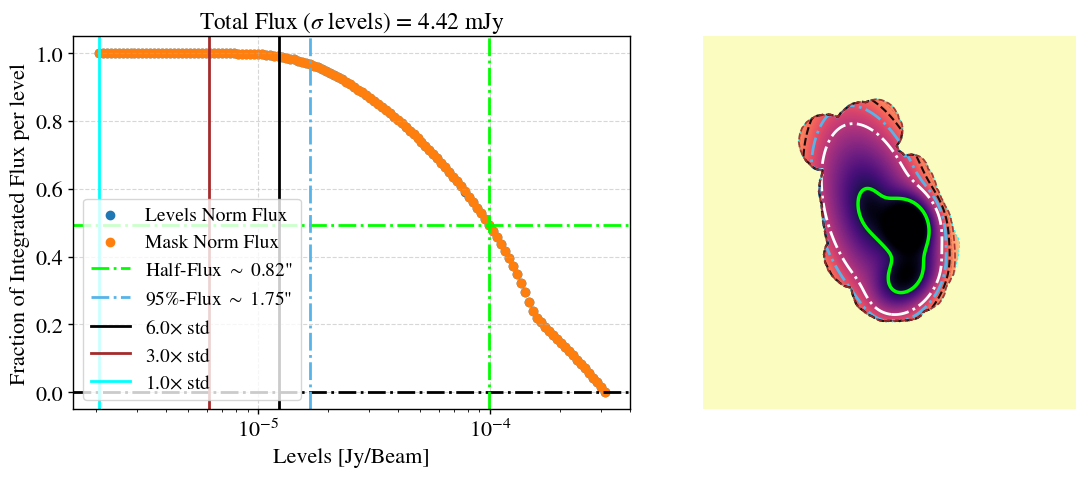

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:3590: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


D_a =  169.24419931373572 Mpc
Linear Distance =  6.564152262058192 pc
D_a =  169.24419931373572 Mpc
Linear Distance =  820.5190327572823 pc
5.999
Using rms provided...
Inner Perimeter (%50): 823.7607831555645
Outer Perimeter (%90): 1753.3039322908398
Outer Perimeter (%99): 3882.140782240518
128 512 384
ctr=(  554.51   498.02)     I=    0.00     q=    0.89     PA=    0.26
ctr=(  554.01   498.02)     I=    0.00     q=    0.88     PA=    0.23
ctr=(  554.60   493.86)     I=    0.00     q=    0.73     PA=    3.75
ctr=(  555.17   492.13)     I=    0.00     q=    0.63     PA=    5.13
ctr=(  554.71   492.36)     I=    0.00     q=    0.62     PA=    5.06
ctr=(  554.32   492.06)     I=    0.00     q=    0.61     PA=    5.26
ctr=(  553.55   492.54)     I=    0.00     q=    0.63     PA=    6.29
ctr=(  552.30   493.44)     I=    0.00     q=    0.63     PA=    7.33
ctr=(  551.15   493.85)     I=    0.00     q=    0.64     PA=    9.23
ctr=(  550.00   491.21)     I=    0.00     q=    0.58     PA=  100

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:12364: RuntimeWarning: divide by zero encountered in divide
  y0peak, x0peak = nd.maximum_position((image / rr2))


ctr=(  522.82   486.83)     I=    0.00     q=    0.59     PA=  106.53
ctr=(  520.75   487.56)     I=    0.00     q=    0.59     PA=  106.70
ctr=(  519.63   487.79)     I=    0.00     q=    0.59     PA=  106.65
ctr=(  517.55   488.54)     I=    0.00     q=    0.59     PA=  106.79
ctr=(  515.83   489.20)     I=    0.00     q=    0.59     PA=  106.58
ctr=(  513.98   490.78)     I=    0.00     q=    0.59     PA=  106.98
ctr=(  510.88   492.95)     I=    0.00     q=    0.60     PA=  106.65
ctr=(  508.47   495.06)     I=    0.00     q=    0.60     PA=  106.09
ctr=(  505.52   497.77)     I=    0.00     q=    0.60     PA=  105.73
ctr=(  502.42   500.12)     I=    0.00     q=    0.60     PA=  104.91
ctr=(  499.44   502.74)     I=    0.00     q=    0.60     PA=  103.61
ctr=(  496.30   505.56)     I=    0.00     q=    0.60     PA=   13.00
ctr=(  493.28   508.11)     I=    0.00     q=    0.60     PA=   12.36
ctr=(  490.14   510.96)     I=    0.00     q=    0.59     PA=  101.53
ctr=(  486.29   514.

/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/fitEllipse2018.py:277: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(gal), origin='lower')


Initial PA and q =  113.06936079707083 0.5200398372862793
Median PA and q =  97.84114642715528 0.5420945936687271
Inner-Mean PA and q =  103.76505033718232 0.5885841180037943
Outer-Mean PA and q =  96.24371312857481 0.5377354778681471
48.6087881472299 99.2428561575031 158.78704633759662 192.46060593127973
R50/R50_100 >>  0.21362735689480192
R50 >>  99.2428561575031
R50_100 >>  214.71917060371305
Gaussianity >>  0.2613921329211183
Sum of fluxes =  0.004437135270911732


<Figure size 640x480 with 0 Axes>

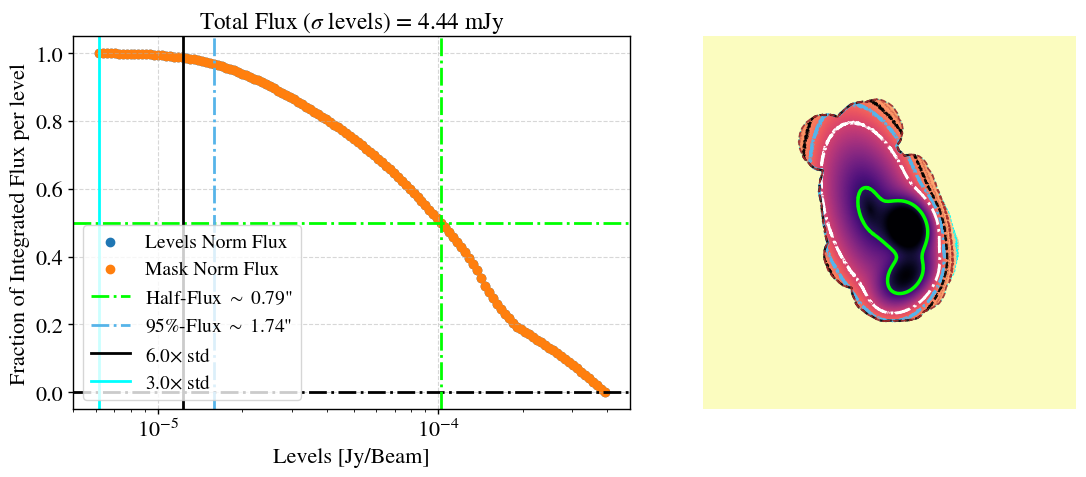

D_a =  169.24419931373572 Mpc
Linear Distance =  6.564152262058192 pc
D_a =  169.24419931373572 Mpc
Linear Distance =  820.5190327572823 pc


/run/media/sagauga/ssd_3/cloud/pcloud-arch/PhD/GitHub/morphen/image_decomposition/../../phd_lucatelli_work/analysis/libs.py:3590: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


In [105]:
results_fit,lmfit_results, lmfit_results_1st_pass, errors_fit, models, \
    results_compact_conv_morpho,results_compact_deconv_morpho,results_ext_conv_morpho,results_ext_deconv_morpho = \
    run_image_fitting(imagelist = imagelist_vla[[-1]],aspect=None,
                      residuallist = residuallist_vla[[-1]],comp_ids=['1','3'],
                      sources_photometries = sources_photometries_new,
                      n_components = n_components_new,z=z_d['VV705'],
                      convolution_mode='GPU',
                      mask=mask,
                      save_name_append='_ls',
                      fix_n = [False,True,True,True,True],
                      fix_value_n=[0.5,0.5,0.5,0.5,1.0],fix_geometry=True,
                      dr_fix=[5,5,5,50,50])